### Import modules and packages. define functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
import glob

#### Specify experiment directory

In [4]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/' #master folder

#### Make dictionary for later storage of results

In [5]:
results = {"filename":[],"Autofluorescencedir":[],
           "earlychannelno":[],"latechannelno":[],"synapsechannelno":[],"exp_id":[],
           "Earlycontroldir":[],"Latecontroldir":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "Late plus early colour - spots mask":[],
           "Synapse colour - spots mask":[],
           "exp condition":[],
           #results on raw whole images
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Synapse colour - Raw mean intensity":[],
           "Mean colour bias of a pixel (early=-1<x<1=late) - Whole raw image":[],
           "Mean correlation coefficient early/late - Whole raw image":[],
           #results on early or late or synapse spots
           "Early colour - Mean intensity of spots":[], 
           "Late colour - Mean intensity of spots":[], 
           "Synapse colour - Mean intensity of spots":[],
           "Early colour - Mean intensity of spots Normd to early ctrl":[],
           "Late colour - Mean intensity of spots Normd to late ctrl":[],
           "Early colour - Total no. of spots in FOV":[],
           "Late colour - Total no. of spots in FOV":[],
           "Synapse colour - Total no. of spots in FOV":[],
           "Early colour - Mean spot area [nm]":[],
           "Late colour - Mean spot area [nm]":[],
           "Synapse colour - Mean spot area [nm]":[],
           #based on -late or early- and synapse spots
           "Early colour - Mean intensity of spots only under synapses":[],
           "Late colour - Mean intensity of spots only under synapses":[],
           "Early colour - Mean intensity of spots Normd to early ctrl - masked by synapses":[],
           "Late colour - Mean intensity of spots Normd to late ctrl - masked by synapses":[],
           "Early colour spots normd to early ctrl, corr to Synapse spots":[],
           "Late colour spots normd to late ctrl, corr to Synapse spots":[],
           #based on late+early spots
           "Mean colour bias of a pixel (early=-1<x<1=late) - under late+early spots":[],
            #based on late+early and synapse spots
           "Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late)":[],
           "Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late) - early and late normd to corresponding ctrls":[]}


histogram_results={"filename":[],"exp condition":[],
           "Early colour - Flattened histogram":[],
           "Late colour - Flattened histogram":[],
           "Synapse colour - Flattened histogram":[]}
                   
regionprops_results={"filename":[],
           "exp condition":[],"Early colour - regionprops":[],
           "Late colour - regionprops":[],
           "Synapse colour - regionprops":[],
           "Late + early colour combined - regionprops":[]}
    
synapse_results={"filename":[],
           "exp condition":[],
           "Early colour - Mean intensity":[], #based on spot segmentation
           "Late colour - Mean intensity":[],#based on spot segmentation
           "Synapse colour - Mean intensity":[],#based on spot segmentation
           "Synapse Area":[], 
           "Mean colour bias of synapse (early=-1<x<1=late)":[],
           "Is new synapse (1=new, 0=old)":[],
           "Correlation between late colour and synapse intensity":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if "_use" in str(filelist[i]):
        if ("Agg" in str(filelist[i]))==False:
            if filelist[i].endswith(".nd2"): #& ("60x" in str(filelist[i]))==True:
                results["filename"].append(filelist[i])
                histogram_results["filename"].append(filelist[i])
                regionprops_results["filename"].append(filelist[i])
                results["exp condition"].append(filelist[i].split('/')[-2])
                histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                channeldir="/".join(filelist[i].split("/")[:-2])
                exec(open(channeldir+"/channels.txt").read())
                results["earlychannelno"].append(earlychannelno)
                results["latechannelno"].append(latechannelno)
                results["synapsechannelno"].append(synapsechannelno)
                results["exp_id"].append(channeldir)
                autofdir=channeldir+"/Ctrl_Autofluorescence"
                autofdircheck=Path(channeldir+"/Ctrl_Autofluorescence")
                if autofdircheck.exists():
                    results["Autofluorescencedir"].append(autofdir)
                else:
                    results["Autofluorescencedir"].append(0) 
                results["Earlycontroldir"].append(glob.glob(channeldir+'/*_earlycontrol'))
                results["Latecontroldir"].append(glob.glob(channeldir+'/*_latecontrol'))               

In [6]:
results["Latecontroldir"][150]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180220_Turnover_Bic_TNR_nb580first_nb653psecond_use/Livectrl_onlysecondcolour_1day_latecontrol']

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180705_Turnover_Bic_TNR_Timepoints_nb580first_635second_use/12hr_Bic/20180705_19_011.nd2


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180620_Turnover_Bic_TNR_Timepoints_nb635first_580second_use/Fixedctrl_early_immediatemount_earlycontrol/20180620_02_2_003.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180220_Turnover_Bic_TNR_nb580first_nb653psecond_use/3DayBic/10_60x_014.nd2


/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


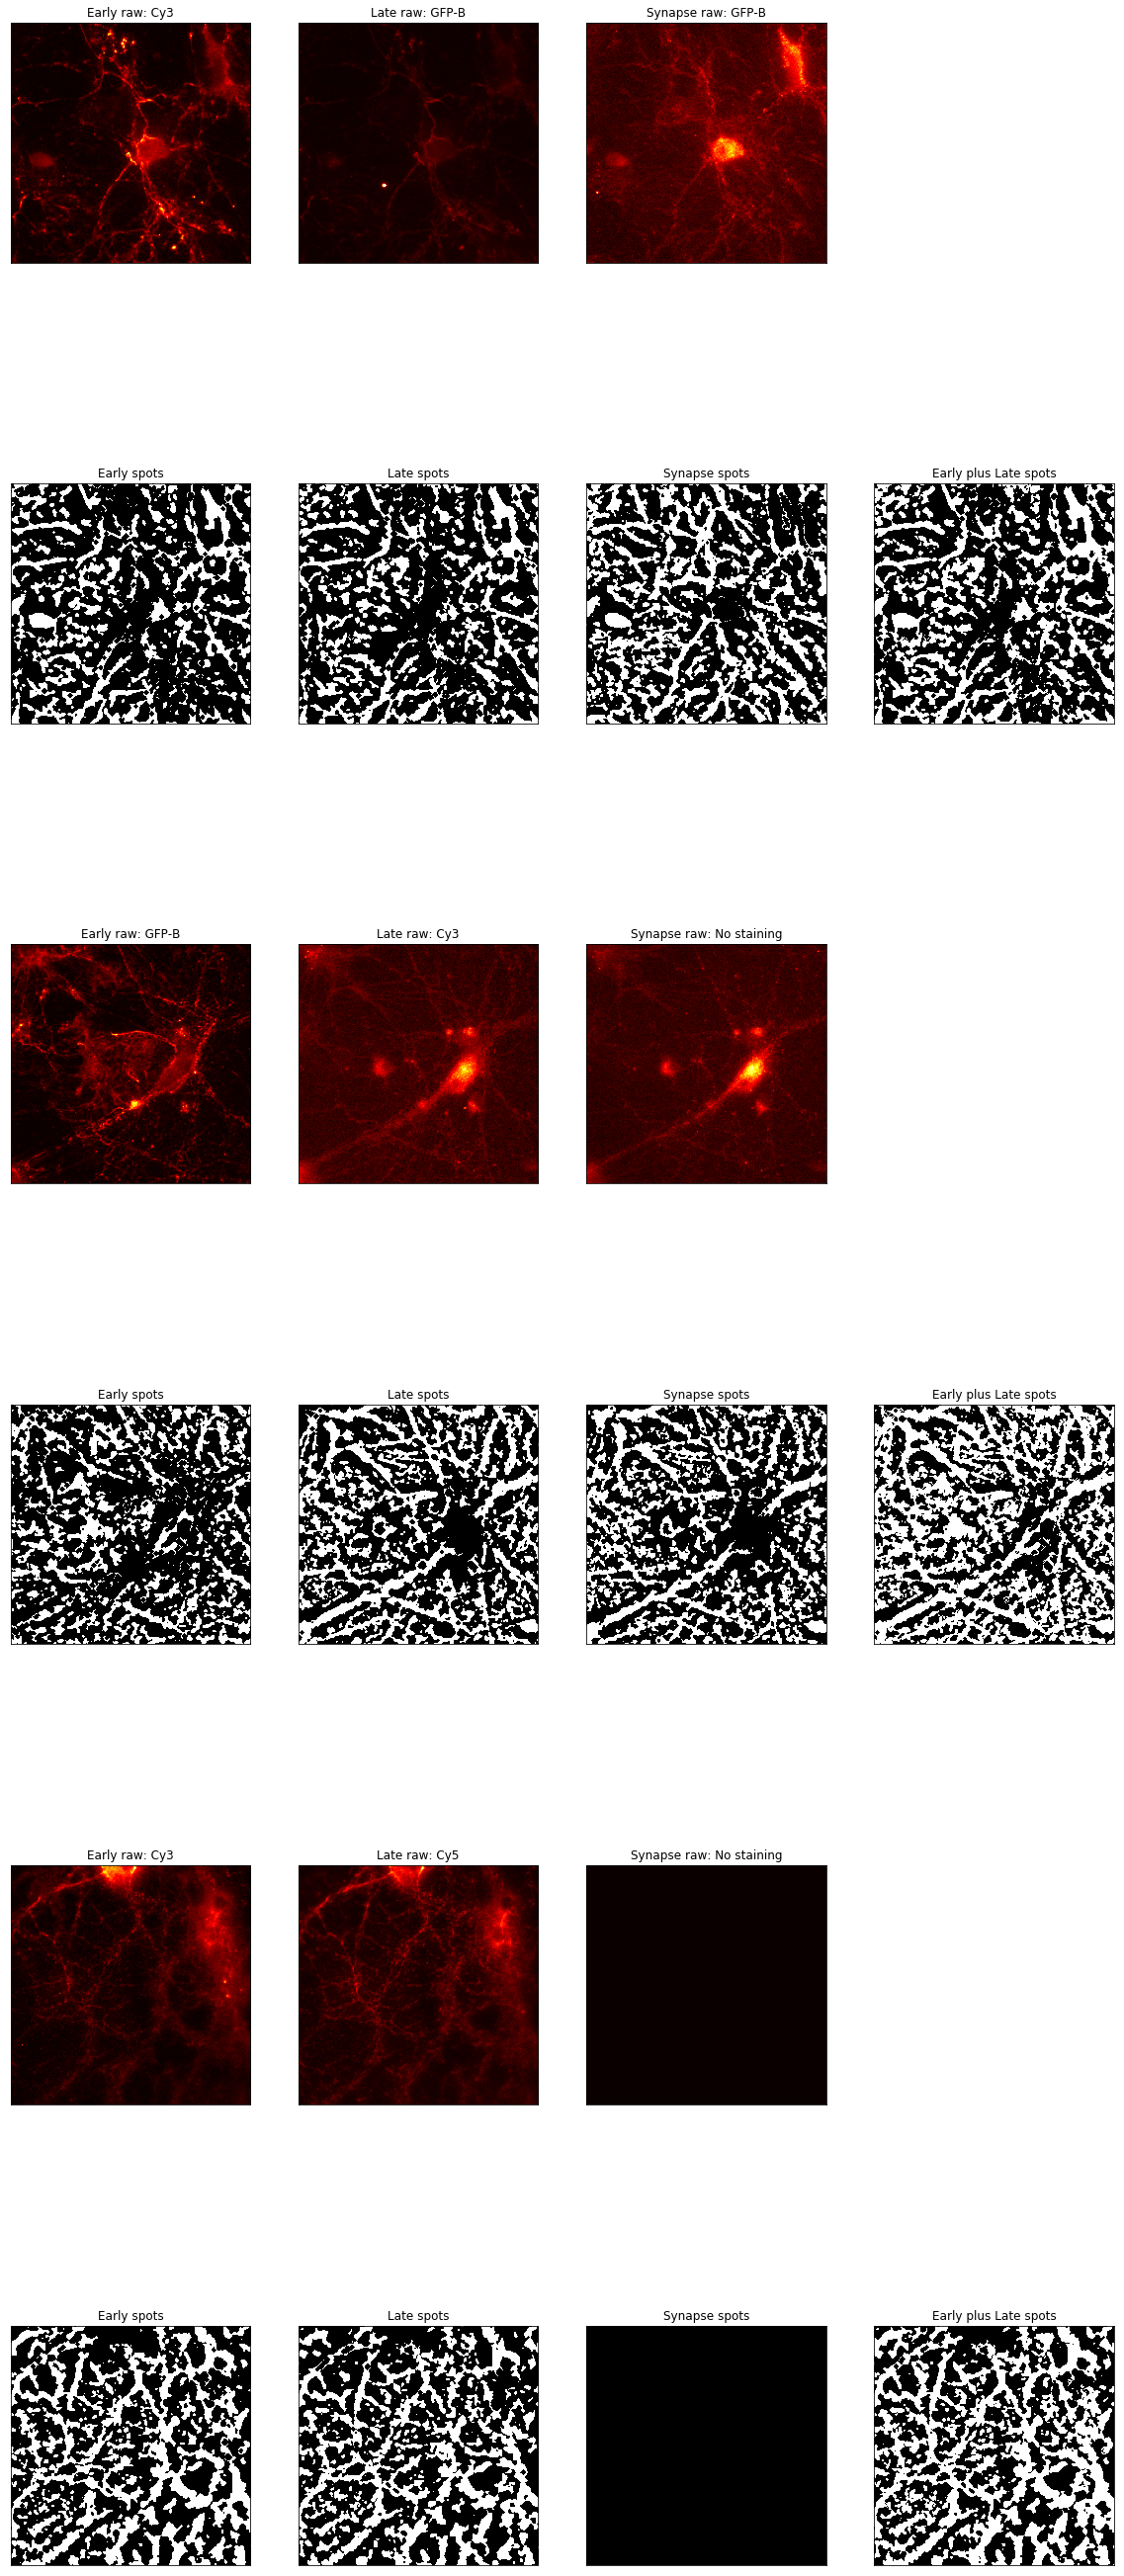

In [7]:
fig=plt.figure(figsize=(20,50))
figno=1
for im in range(0,3):
    randomno=np.random.randint(1,len(results["filename"]))
    early_channel_no=results["earlychannelno"][randomno]
    late_channel_no=results["latechannelno"][randomno]
    synapse_channel_no=results["synapsechannelno"][randomno]
    with ND2Reader(results["filename"][randomno]) as images:
        print(results["filename"][randomno])
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_channel_no>0:
            synapse_image=images[synapse_channel_no-1]
            [channel1name, channel2name, channel3name]=early_image.metadata['channels']
            if early_channel_no==1:
                early_channelname=channel1name
                if late_channel_no==2:
                    late_channelname=channel2name
                    synapse_channelname=channel3name
                else:
                    late_channelname=channel3name
                    synapse_channelname=channel2name
            if early_channel_no==2:
                early_channelname=channel2name
                if late_channel_no==3:
                    late_channelname=channel3name
                    synapse_channelname=channel1name
                else:
                    late_channelname=channel1name
                    synapse_channelname=channel3name
            if early_channel_no==3:
                early_channelname=channel3name
                if late_channel_no==2:
                    late_channelname=channel2name
                    synapse_channelname=channel1name
                else:
                    late_channelname=channel1name
                    synapse_channelname=channel2name
        else:
            synapse_image=np.zeros((512,512))        
            [channel1name, channel2name]=early_image.metadata['channels']
        if early_channel_no==1:
            early_channelname=channel1name
            late_channelname=channel2name
        else:
            early_channelname=channel2name
            late_channelname=channel1name
            synapse_channelname='No staining'
    #smoothing with gaussian filter for noise reduction
    #can play with sigma
    sigmagauss=2 #should be roughly half the size of the object you are detecting
    early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
    late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
    synapse_smooth=ndi.filters.gaussian_filter(synapse_image,sigmagauss)
    #adaptive thresholding - bg found by mean filter with SE
    istruct=51 #for SE
    struct = (np.mgrid[:istruct,:istruct][0] - np.floor(istruct/2))**2 + (np.mgrid[:istruct,:istruct][1] - np.floor(istruct/2))**2 <= np.floor(istruct/2)**2
    bg_early = rank.mean(early_smooth, selem=struct)
    bg_late = rank.mean(late_smooth, selem=struct)
    bg_synapse = rank.mean(synapse_smooth, selem=struct)
    early_denoised = early_smooth >= bg_early
    late_denoised= late_smooth >= bg_late
    synapse_denoised = synapse_smooth >= bg_synapse
    
    early_not_toobright=np.logical_not(ndi.morphology.binary_dilation(early_image>np.percentile(early_image,99),iterations=5))
    late_not_toobright=np.logical_not(ndi.morphology.binary_dilation(late_image>np.percentile(late_image,99),iterations=5))
    synapse_not_toobright=np.logical_not(ndi.morphology.binary_dilation(synapse_image>np.percentile(synapse_image,99),iterations=3))

    #final spots
    early_spots=early_not_toobright & early_denoised
    late_spots=late_not_toobright & late_denoised
    synapse_spots=synapse_not_toobright & synapse_denoised
    lateplusearly_spots = np.add(late_spots,early_spots)
    lateplusearly_spots[lateplusearly_spots==2]=1

    #figures    
    fig.add_subplot(6,4,figno)
    plt.imshow(early_image,interpolation='none',cmap='hot',vmin=1.5*early_image.min(),vmax=0.95*early_image.max())
    plt.title('Early raw: '+early_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+1)
    plt.imshow(late_image,interpolation='none',cmap='hot')
    plt.title('Late raw: '+late_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+2)
    plt.imshow(synapse_image,interpolation='none',cmap='hot')
    plt.title('Synapse raw: '+synapse_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+4)
    plt.imshow(early_spots,interpolation='none',cmap='gray')
    plt.title('Early spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+5)
    plt.imshow(late_spots,interpolation='none',cmap='gray')
    plt.title('Late spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+6)
    plt.imshow(synapse_spots,interpolation='none',cmap='gray')
    plt.title('Synapse spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+7)
    plt.imshow(lateplusearly_spots,interpolation='none',cmap='gray')
    plt.title('Early plus Late spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    figno=figno+8 

#### After optimizing, run below to make segmentation masks for all images

In [8]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
#for im in range(1672,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    early_channel_no=results["earlychannelno"][im]
    late_channel_no=results["latechannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_channel_no>0:
            synapse_image=images[synapse_channel_no-1]
        else:
            synapse_image=np.zeros((512,512))       
    #smoothing with gaussian filter for noise reduction
    early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
    late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
    synapse_smooth=ndi.filters.gaussian_filter(synapse_image,sigmagauss)
    #adaptive thresholding - bg found by mean filter with SE
    struct = (np.mgrid[:istruct,:istruct][0] - np.floor(istruct/2))**2 + (np.mgrid[:istruct,:istruct][1] - np.floor(istruct/2))**2 <= np.floor(istruct/2)**2
    bg_early = rank.mean(early_smooth, selem=struct)
    bg_late = rank.mean(late_smooth, selem=struct)
    bg_synapse = rank.mean(synapse_smooth, selem=struct)
    early_denoised = early_smooth >= bg_early
    late_denoised= late_smooth >= bg_late
    synapse_denoised = synapse_smooth >= bg_synapse
    
    early_not_toobright=np.logical_not(ndi.morphology.binary_dilation(early_image>np.percentile(early_image,99),iterations=5))
    late_not_toobright=np.logical_not(ndi.morphology.binary_dilation(late_image>np.percentile(late_image,99),iterations=5))
    synapse_not_toobright=np.logical_not(ndi.morphology.binary_dilation(synapse_image>np.percentile(synapse_image,99),iterations=3))

    #final spots
    early_spots=early_not_toobright & early_denoised
    late_spots=late_not_toobright & late_denoised
    synapse_spots=synapse_not_toobright & synapse_denoised
    lateplusearly_spots = np.add(late_spots,early_spots)
    lateplusearly_spots[lateplusearly_spots==2]=1
    
    results["Early colour - spots mask"].append(early_spots)
    results["Late colour - spots mask"].append(late_spots)
    results["Synapse colour - spots mask"].append(synapse_spots)
    results["Late plus early colour - spots mask"].append(lateplusearly_spots)          
os.system('say "Segmentation complete"')

Total number of images: 1912
Calculating image no 1of 1912


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Calculating image no 2of 1912


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Calculating image no 3of 1912
Calculating image no 4of 1912
Calculating image no 5of 1912
Calculating image no 6of 1912
Calculating image no 7of 1912
Calculating image no 8of 1912
Calculating image no 9of 1912
Calculating image no 10of 1912
Calculating image no 11of 1912
Calculating image no 12of 1912
Calculating image no 13of 1912
Calculating image no 14of 1912
Calculating image no 15of 1912
Calculating image no 16of 1912
Calculating image no 17of 1912
Calculating image no 18of 1912
Calculating image no 19of 1912
Calculating image no 20of 1912
Calculating image no 21of 1912
Calculating image no 22of 1912
Calculating image no 23of 1912
Calculating image no 24of 1912
Calculating image no 25of 1912
Calculating image no 26of 1912
Calculating image no 27of 1912


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Calculating image no 28of 1912
Calculating image no 29of 1912
Calculating image no 30of 1912
Calculating image no 31of 1912
Calculating image no 32of 1912
Calculating image no 33of 1912
Calculating image no 34of 1912
Calculating image no 35of 1912
Calculating image no 36of 1912
Calculating image no 37of 1912
Calculating image no 38of 1912
Calculating image no 39of 1912
Calculating image no 40of 1912
Calculating image no 41of 1912
Calculating image no 42of 1912
Calculating image no 43of 1912
Calculating image no 44of 1912
Calculating image no 45of 1912
Calculating image no 46of 1912
Calculating image no 47of 1912
Calculating image no 48of 1912
Calculating image no 49of 1912
Calculating image no 50of 1912
Calculating image no 51of 1912
Calculating image no 52of 1912
Calculating image no 53of 1912
Calculating image no 54of 1912
Calculating image no 55of 1912
Calculating image no 56of 1912
Calculating image no 57of 1912
Calculating image no 58of 1912
Calculating image no 59of 1912
Calculat

Calculating image no 287of 1912
Calculating image no 288of 1912
Calculating image no 289of 1912
Calculating image no 290of 1912
Calculating image no 291of 1912
Calculating image no 292of 1912
Calculating image no 293of 1912
Calculating image no 294of 1912
Calculating image no 295of 1912
Calculating image no 296of 1912
Calculating image no 297of 1912
Calculating image no 298of 1912
Calculating image no 299of 1912
Calculating image no 300of 1912
Calculating image no 301of 1912
Calculating image no 302of 1912
Calculating image no 303of 1912
Calculating image no 304of 1912
Calculating image no 305of 1912
Calculating image no 306of 1912
Calculating image no 307of 1912
Calculating image no 308of 1912
Calculating image no 309of 1912
Calculating image no 310of 1912
Calculating image no 311of 1912
Calculating image no 312of 1912
Calculating image no 313of 1912
Calculating image no 314of 1912
Calculating image no 315of 1912
Calculating image no 316of 1912
Calculating image no 317of 1912
Calculat

Calculating image no 544of 1912
Calculating image no 545of 1912
Calculating image no 546of 1912
Calculating image no 547of 1912
Calculating image no 548of 1912
Calculating image no 549of 1912
Calculating image no 550of 1912
Calculating image no 551of 1912
Calculating image no 552of 1912
Calculating image no 553of 1912
Calculating image no 554of 1912
Calculating image no 555of 1912
Calculating image no 556of 1912
Calculating image no 557of 1912
Calculating image no 558of 1912
Calculating image no 559of 1912
Calculating image no 560of 1912
Calculating image no 561of 1912
Calculating image no 562of 1912
Calculating image no 563of 1912
Calculating image no 564of 1912
Calculating image no 565of 1912
Calculating image no 566of 1912
Calculating image no 567of 1912
Calculating image no 568of 1912
Calculating image no 569of 1912
Calculating image no 570of 1912
Calculating image no 571of 1912
Calculating image no 572of 1912
Calculating image no 573of 1912
Calculating image no 574of 1912
Calculat

Calculating image no 801of 1912
Calculating image no 802of 1912
Calculating image no 803of 1912
Calculating image no 804of 1912
Calculating image no 805of 1912
Calculating image no 806of 1912
Calculating image no 807of 1912
Calculating image no 808of 1912
Calculating image no 809of 1912
Calculating image no 810of 1912
Calculating image no 811of 1912
Calculating image no 812of 1912
Calculating image no 813of 1912
Calculating image no 814of 1912
Calculating image no 815of 1912
Calculating image no 816of 1912
Calculating image no 817of 1912
Calculating image no 818of 1912
Calculating image no 819of 1912
Calculating image no 820of 1912
Calculating image no 821of 1912
Calculating image no 822of 1912
Calculating image no 823of 1912
Calculating image no 824of 1912
Calculating image no 825of 1912
Calculating image no 826of 1912
Calculating image no 827of 1912
Calculating image no 828of 1912
Calculating image no 829of 1912
Calculating image no 830of 1912
Calculating image no 831of 1912
Calculat

Calculating image no 1056of 1912
Calculating image no 1057of 1912
Calculating image no 1058of 1912
Calculating image no 1059of 1912
Calculating image no 1060of 1912
Calculating image no 1061of 1912
Calculating image no 1062of 1912
Calculating image no 1063of 1912
Calculating image no 1064of 1912
Calculating image no 1065of 1912
Calculating image no 1066of 1912
Calculating image no 1067of 1912
Calculating image no 1068of 1912
Calculating image no 1069of 1912
Calculating image no 1070of 1912
Calculating image no 1071of 1912
Calculating image no 1072of 1912
Calculating image no 1073of 1912
Calculating image no 1074of 1912
Calculating image no 1075of 1912
Calculating image no 1076of 1912
Calculating image no 1077of 1912
Calculating image no 1078of 1912
Calculating image no 1079of 1912
Calculating image no 1080of 1912
Calculating image no 1081of 1912
Calculating image no 1082of 1912
Calculating image no 1083of 1912
Calculating image no 1084of 1912
Calculating image no 1085of 1912
Calculatin

Calculating image no 1305of 1912
Calculating image no 1306of 1912
Calculating image no 1307of 1912
Calculating image no 1308of 1912
Calculating image no 1309of 1912
Calculating image no 1310of 1912
Calculating image no 1311of 1912
Calculating image no 1312of 1912
Calculating image no 1313of 1912
Calculating image no 1314of 1912
Calculating image no 1315of 1912
Calculating image no 1316of 1912
Calculating image no 1317of 1912
Calculating image no 1318of 1912
Calculating image no 1319of 1912
Calculating image no 1320of 1912
Calculating image no 1321of 1912
Calculating image no 1322of 1912
Calculating image no 1323of 1912
Calculating image no 1324of 1912
Calculating image no 1325of 1912
Calculating image no 1326of 1912
Calculating image no 1327of 1912
Calculating image no 1328of 1912
Calculating image no 1329of 1912
Calculating image no 1330of 1912
Calculating image no 1331of 1912
Calculating image no 1332of 1912
Calculating image no 1333of 1912
Calculating image no 1334of 1912
Calculatin

Calculating image no 1554of 1912
Calculating image no 1555of 1912
Calculating image no 1556of 1912
Calculating image no 1557of 1912
Calculating image no 1558of 1912
Calculating image no 1559of 1912
Calculating image no 1560of 1912
Calculating image no 1561of 1912
Calculating image no 1562of 1912
Calculating image no 1563of 1912
Calculating image no 1564of 1912
Calculating image no 1565of 1912
Calculating image no 1566of 1912
Calculating image no 1567of 1912
Calculating image no 1568of 1912
Calculating image no 1569of 1912
Calculating image no 1570of 1912
Calculating image no 1571of 1912
Calculating image no 1572of 1912
Calculating image no 1573of 1912
Calculating image no 1574of 1912
Calculating image no 1575of 1912
Calculating image no 1576of 1912
Calculating image no 1577of 1912
Calculating image no 1578of 1912
Calculating image no 1579of 1912
Calculating image no 1580of 1912
Calculating image no 1581of 1912
Calculating image no 1582of 1912
Calculating image no 1583of 1912
Calculatin

Calculating image no 1803of 1912
Calculating image no 1804of 1912
Calculating image no 1805of 1912
Calculating image no 1806of 1912
Calculating image no 1807of 1912
Calculating image no 1808of 1912
Calculating image no 1809of 1912
Calculating image no 1810of 1912
Calculating image no 1811of 1912
Calculating image no 1812of 1912
Calculating image no 1813of 1912
Calculating image no 1814of 1912
Calculating image no 1815of 1912
Calculating image no 1816of 1912
Calculating image no 1817of 1912
Calculating image no 1818of 1912
Calculating image no 1819of 1912
Calculating image no 1820of 1912
Calculating image no 1821of 1912
Calculating image no 1822of 1912
Calculating image no 1823of 1912
Calculating image no 1824of 1912
Calculating image no 1825of 1912
Calculating image no 1826of 1912
Calculating image no 1827of 1912
Calculating image no 1828of 1912
Calculating image no 1829of 1912
Calculating image no 1830of 1912
Calculating image no 1831of 1912
Calculating image no 1832of 1912
Calculatin

0

### Make folder for results and save segmentation

In [9]:
resultsbackup2=deepcopy(results)

In [94]:
results=deepcopy(resultsbackup2)

In [23]:
# Store data (serialize)
output = open('myfile.pkl', 'wb')
pickle.dump(resultsbackup2, output)
output.close()

In [ ]:
# Load data (deserialize)
pkl_file = open('myfile.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

### Calculate mean intensity of controls - under spots

In [26]:
Controls_intensity={"exp_id":[],"earlycontrol_meanint":[],"latecontrol_meanint":[]}

for exps in list(set(results["exp_id"])):
    print(exps)
    type(exps)
    
    exec(open(exps+"/channels.txt").read())
    early_chanel_no=earlychannelno
    late_channel_no=latechannelno
    
    ctrlearlys={"filename":[]}
    pathearly=os.path.dirname(glob.glob(exps+'/*_earlycontrol')[0])
    filelistearly = []
    for root, _, filenames in os.walk(pathearly):
         for filename in filenames:
             filelistearly.append(os.path.join(root, filename)) #make a list of all images in early control folder
    for l in range(0,len(filelistearly)):
        if filelistearly[l].endswith(".nd2"): 
            ctrlearlys["filename"].append(filelistearly[l])
    earlycolour_ctrls=np.zeros((len(ctrlearlys["filename"]),1)) #make empty vector to store mean intensity of each image
    earlycolour_spotsonly_ctrls=np.zeros((len(ctrlearlys["filename"]),1))
    for im in range(0,len(ctrlearlys["filename"])):
        with ND2Reader(ctrlearlys["filename"][im]) as images:
            early_image_ctrl=images[early_channel_no-1]
        #convert to array
        early_image_ctrl=early_image_ctrl.astype(np.int16)
        #normalize intensity to value between 0 and 1
        early_image_ctrl=np.divide(early_image_ctrl,16383.)
        #append raw mean intensity to vector
        earlycolour_ctrls[im]=np.mean(early_image_ctrl)
        ##### calculate the intensity for the cleaned image separately- i.e. only for the spots #########
        early_spots=results["Early colour - spots mask"][im] #read the spots mask
        spots_early_labels,_ = ndi.label(early_spots) #label the spots with unique IDs
        early_spots_intensities=np.zeros((len(np.unique(spots_early_labels)),1)) #make empty vector to store intensity results
        for spotno in np.unique(spots_early_labels)[1:]: #loop over early spots
            early_spots_mask = spots_early_labels==spotno
            early_spots_intensities[spotno]=np.nanmean(early_image_ctrl[early_spots_mask])
        earlycolour_spotsonly_ctrls[im]=np.nanmean(early_spots_intensities)
        
    ctrllates={"filename":[]}
    pathlate=os.path.dirname(glob.glob(exps+'/*_latecontrol')[0])
    filelistlate = []
    for root, _, filenames in os.walk(pathlate):
         for filename in filenames:
             filelistlate.append(os.path.join(root, filename)) #make a list of all images in early control folder
    for l in range(0,len(filelistlate)):
        if filelistlate[l].endswith(".nd2"): 
            ctrllates["filename"].append(filelistlate[l])
    latecolour_ctrls=np.zeros((len(ctrllates["filename"]),1)) #make empty vector to store mean intensity of each image
    latecolour_spotsonly_ctrls=np.zeros((len(ctrllates["filename"]),1))
    for im in range(0,len(ctrllates["filename"])):
        with ND2Reader(ctrllates["filename"][im]) as images:
            late_image_ctrl=images[late_channel_no-1]
        #convert to array
        late_image_ctrl=late_image_ctrl.astype(np.int16)
        #normalize intensity to value between 0 and 1
        late_image_ctrl=np.divide(late_image_ctrl,16383.)
        #append raw mean intensity to vector
        latecolour_ctrls[im]=np.mean(late_image_ctrl)
        ##### calculate the intensity for the cleaned image separately- i.e. only for the spots #########
        late_spots=results["Late colour - spots mask"][im] #read the spots mask
        spots_late_labels,_ = ndi.label(late_spots) #label the spots with unique IDs
        late_spots_intensities=np.zeros((len(np.unique(spots_late_labels)),1)) #make empty vector to store intensity results
        for spotno in np.unique(spots_late_labels)[1:]: #loop over early spots
            late_spots_mask = spots_late_labels==spotno
            late_spots_intensities[spotno]=np.nanmean(late_image_ctrl[late_spots_mask])
        latecolour_spotsonly_ctrls[im]=np.nanmean(late_spots_intensities)
        #average the vector
    early_ctrl_mean=np.nanmean(earlycolour_ctrls)
    early_spotsonly_ctrl_mean=np.nanmean(earlycolour_spotsonly_ctrls)
    late_ctrl_mean=np.nanmean(latecolour_ctrls)
    late_spotsonly_ctrl_mean=np.nanmean(latecolour_spotsonly_ctrls)
    
    Controls_intensity["exp_id"].append(exps)
    Controls_intensity["earlycontrol_meanint"].append(early_spotsonly_ctrl_mean)
    Controls_intensity["latecontrol_meanint"].append(late_spotsonly_ctrl_mean)


    print(early_ctrl_mean)
    print(early_spotsonly_ctrl_mean)
    print(late_ctrl_mean)
    print(late_spotsonly_ctrl_mean)
    
df_ctrlsintensity=pd.DataFrame(Controls_intensity)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second_use/TNR
0.016149446092017388
0.016196930094151577
0.016149446092017388
0.01624752291608934
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180710_Turnover_Bic_Timepoints_TNR_nb_use/635first_580second
0.030198246749674945
0.030290218959988083
0.025934140744747192
0.02628743528424992
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180710_Turnover_Bic_Timepoints_TNR_nb_use/580first_635second
0.03243118096409953
0.032228297567795404
0.016552885160105654
0.016444647773006305
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180511_Turnover_Bic_nb580first_635psecond_use/TNR
0.04105667629498159
0.04117715762368485
0.020585550052161488
0.020721047740004928
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180214_Turnover_Bic_TNR_nb580first_nb653psecond_use
0.029865512024793827
0.02947406625097506
0.029865512024793827
0.029984849510088535
/Volumes/ukps-all$/user/t

In [44]:
#small detour to calculate the autofluorescence
    autof={"filename":[]}
    autofpath=results["Autofluorescencedir"][i]
    if autofpath==0:
        early_autoint_mean=0
        late_autoint_mean=0
        if synapse_flag:
            synapse_autoint_mean=0
    else:
        pathy = os.path.dirname(autofpath+"/")  
        autoffilelist = []
        for root, _, filenames in os.walk(pathy):
             for filename in filenames:
                 autoffilelist.append(os.path.join(root, filename))
        for l in range(0,len(autoffilelist)):
            if autoffilelist[l].endswith(".nd2"): 
                autof["filename"].append(autoffilelist[l])
        earlycolour_autoint=np.zeros((len(autof["filename"]),1))
        latecolour_autoint=np.zeros((len(autof["filename"]),1))
        if synapse_flag:
            synapsecolour_autoint=np.zeros((len(autof["filename"]),1))
        for im in range(0,len(autof["filename"])):
            with ND2Reader(autof["filename"][im]) as images:
                early_image_auto=images[early_channel_no-1]
                late_image_auto=images[late_channel_no-1]
                if synapse_flag:
                    synapse_image_auto=images[synapse_channel_no-1]
            #convert to array
            early_image_auto=early_image_auto.astype(np.int16)
            late_image_auto=late_image_auto.astype(np.int16)
            if synapse_flag:
                synapse_image_auto=synapse_image_auto.astype(np.int16)
            #normalize intensity to value between 0 and 1
            early_image_auto=np.divide(early_image_auto,16383.)
            late_image_auto=np.divide(late_image_auto,16383.)
            if synapse_flag:
                synapse_image_auto=np.divide(synapse_image_auto,16383.)
            #append mean intensity
            earlycolour_autoint[im]=np.mean(early_image_auto)
            latecolour_autoint[im]=np.mean(late_image_auto)  
            if synapse_flag:
                synapsecolour_autoint[im]=np.mean(synapse_image_auto)
        #average the vectors
        early_autoint_mean=np.mean(earlycolour_autoint)
        late_autoint_mean=np.mean(latecolour_autoint)
        if synapse_flag:
            synapse_autoint_mean=np.mean(synapsecolour_autoint) 

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180620_Turnover_Bic_TNR_Timepoints_nb635first_580second_use'

### Batch analyse images, after creating the segmentation masks

In [95]:
print('Total number of images: ' + str(len(results['filename'])))

#for i in range(0,len(results["filename"])): 
for i in range(0,len(results["filename"])):
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    early_channel_no=results["earlychannelno"][i]
    late_channel_no=results["latechannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    if synapse_channel_no>0:
        synapse_flag=True
        print('has synapse values')
    else:
        synapse_flag=False
    with ND2Reader(results["filename"][i]) as images:
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_flag:
            synapse_image=images[synapse_channel_no-1]
    #convert to array
    early_image=early_image.astype(np.int16)
    late_image=late_image.astype(np.int16)
    if synapse_flag:
        synapse_image=synapse_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    early_image_raw = deepcopy(early_image)
    late_image_raw=deepcopy(late_image)
    if synapse_flag:
        synapse_image_raw=deepcopy(synapse_image)
    #normalize intensity to value between 0 and 1
    early_image=np.divide(early_image,16383.)
    late_image=np.divide(late_image,16383.)
    if synapse_flag:
        synapse_image=np.divide(synapse_image,16383.)
    #make image histograms of raw images
    early_hist,_ = np.histogram(early_image,bins=np.linspace(0.,1.,50))
    late_hist,_ = np.histogram(late_image,bins=np.linspace(0.,1.,50))
    if synapse_flag:
        synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    #makes images normd to controls
    currentexp=results["exp_id"][i]
    earlyctrlmean=df_ctrlsintensity[df_ctrlsintensity["exp_id"]==currentexp]["earlycontrol_meanint"].values[0]
    latectrlmean=df_ctrlsintensity[df_ctrlsintensity["exp_id"]==currentexp]["latecontrol_meanint"].values[0]
    early_image_normtoearlyctrl=deepcopy(early_image)
    early_image_normtoearlyctrl=early_image_normtoearlyctrl/earlyctrlmean
    late_image_normtolatectrl=deepcopy(late_image)
    late_image_normtolatectrl=late_image_normtolatectrl/latectrlmean

    ##################################################################################

    ###############analyses for the cleaned images - after processing##############
    #read spots masks
    early_spots=results["Early colour - spots mask"][i]
    late_spots=results["Late colour - spots mask"][i]
    lateplusearly_spots=results["Late plus early colour - spots mask"][i]
    if synapse_flag:
        synapse_spots=results["Synapse colour - spots mask"][i]
    #label the spots with unique IDs
    spots_early_labels,_ = ndi.label(early_spots)
    spots_late_labels,_ = ndi.label(late_spots)
    spots_earlypluslate_labels,_ = ndi.label(lateplusearly_spots)
    if synapse_flag:
        spots_synapse_labels,_ = ndi.label(synapse_spots)
    #make empty vectors for results                                  
    early_spots_intensities=np.zeros((len(np.unique(spots_early_labels)),1))
    early_spots_intensities_normtoearlyctrl=np.zeros((len(np.unique(spots_early_labels)),1))
    early_spots_areas=np.zeros((len(np.unique(spots_early_labels)),1))
    late_spots_intensities=np.zeros((len(np.unique(spots_late_labels)),1))
    late_spots_intensities_normtolatectrl=np.zeros((len(np.unique(spots_late_labels)),1))
    late_spots_areas=np.zeros((len(np.unique(spots_late_labels)),1))
    if synapse_flag:
        synapse_spots_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))
        synapse_spots_areas=np.zeros((len(np.unique(spots_synapse_labels)),1))
        early_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))   
        late_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1)) 
        early_atsynapses_intensities_normtoearlyctrl=np.zeros((len(np.unique(spots_synapse_labels)),1))   
        late_atsynapses_intensities_normtolatectrl=np.zeros((len(np.unique(spots_synapse_labels)),1)) 
    #loop over early spots
    for spotno in np.unique(spots_early_labels)[1:]:
        early_spots_mask = spots_early_labels==spotno
        early_spots_intensities[spotno]=np.nanmean(early_image[early_spots_mask])
        early_spots_intensities_normtoearlyctrl[spotno]=np.nanmean(early_image_normtoearlyctrl[early_spots_mask])
        early_spots_areas[spotno]=np.sum(early_spots_mask)
    #loop over late spots
    for spotnol in np.unique(spots_late_labels)[1:]:
        late_spots_mask= spots_late_labels==spotnol
        late_spots_intensities[spotnol]=np.nanmean(late_image[late_spots_mask])
        late_spots_intensities_normtolatectrl[spotnol]=np.nanmean(late_image_normtolatectrl[late_spots_mask])
        late_spots_areas[spotnol]=np.sum(late_spots_mask)
    #loop over synapse spots   
    if synapse_flag:
        for spotnos in np.unique(spots_synapse_labels)[1:]:
            synapse_spots_mask= spots_synapse_labels==spotnos
            synapse_spots_intensities[spotnos]=np.nanmean(synapse_image[synapse_spots_mask])
            synapse_spots_areas[spotnos]=np.sum(synapse_spots_mask)
            #intensities masked by synapses, calculation
            early_atsynapses_intensities[spotnos]=np.nanmean(early_image[synapse_spots_mask & early_spots_mask])
            late_atsynapses_intensities[spotnos]=np.nanmean(late_image[synapse_spots_mask & late_spots_mask])
            early_atsynapses_intensities_normtoearlyctrl[spotnos]=np.nanmean(early_image_normtoearlyctrl[synapse_spots_mask & early_spots_mask])
            late_atsynapses_intensities_normtolatectrl[spotnos]=np.nanmean(late_image_normtolatectrl[synapse_spots_mask & late_spots_mask])
    #calculate bias image at cross of late/early spots
    a=late_image[lateplusearly_spots]
    b=early_image[lateplusearly_spots]
    spots_bias_image=np.divide([a-b],[a+b])                               
    #bias image calculation for normalized images
    a=late_image_normtolatectrl[lateplusearly_spots]
    b=early_image_normtoearlyctrl[lateplusearly_spots]
    spots_bias_image=np.divide([a-b],[a+b])     
    
    #results based on raw
    results["Early colour - Raw mean intensity"].append(np.nanmean(early_image_raw))
    results["Late colour - Raw mean intensity"].append(np.nanmean(late_image_raw))
    if synapse_flag:
        results["Synapse colour - Raw mean intensity"].append(np.nanmean(synapse_image_raw))
    else:
        results["Synapse colour - Raw mean intensity"].append(np.nan)
    histogram_results["Early colour - Flattened histogram"].append(early_hist) 
    histogram_results["Late colour - Flattened histogram"].append(late_hist)
    if synapse_flag:
        histogram_results["Synapse colour - Flattened histogram"].append(synapse_hist)
    else:
        histogram_results["Synapse colour - Flattened histogram"].append(np.nan)
    bias_image_raw_full=np.divide([late_image-early_image],[late_image+early_image]).reshape(512,512)
    bias_image_at_synapses_full=bias_image_raw_full[synapse_spots]
    bias_image_norm_full=np.divide([late_image_normtolatectrl-early_image_normtoearlyctrl],[late_image_normtolatectrl+early_image_normtoearlyctrl]).reshape(512,512)
    bias_image_norm_at_synapses_full=bias_image_norm_full[synapse_spots]
    bias_image_raw = bias_image_raw_full[~np.isnan(bias_image_raw_full)]
    bias_image_at_synapses=bias_image_at_synapses_full[~np.isnan(bias_image_at_synapses_full)]
    bias_image_norm_at_synapses=bias_image_norm_at_synapses_full[~np.isnan(bias_image_norm_at_synapses_full)]

    
    results["Mean colour bias of a pixel (early=-1<x<1=late) - Whole raw image"].append(np.nanmean(bias_image_raw_full))
    results["Mean correlation coefficient early/late - Whole raw image"].append(corr2(early_image,late_image))
    
    #results based on spots
    results["Early colour - Mean intensity of spots"].append(np.nanmean(early_spots_intensities))
    results["Late colour - Mean intensity of spots"].append(np.nanmean(late_spots_intensities))
    results["Early colour - Mean intensity of spots Normd to early ctrl"].append(np.nanmean(early_spots_intensities_normtoearlyctrl))
    results["Late colour - Mean intensity of spots Normd to late ctrl"].append(np.nanmean(late_spots_intensities_normtolatectrl))
    if synapse_flag:
        results["Synapse colour - Mean intensity of spots"].append(np.nanmean(synapse_spots_intensities))
    else:
        results["Synapse colour - Mean intensity of spots"].append(np.nan) 
    results["Early colour - Total no. of spots in FOV"].append(len(early_spots_intensities))
    results["Late colour - Total no. of spots in FOV"].append(len(late_spots_intensities))
    if synapse_flag:
        results["Synapse colour - Total no. of spots in FOV"].append(len(synapse_spots_intensities))
    else:
        results["Synapse colour - Total no. of spots in FOV"].append(np.nan)
    results["Early colour - Mean spot area [nm]"].append(np.nanmean(early_spots_areas))
    results["Late colour - Mean spot area [nm]"].append(np.nanmean(late_spots_areas))
    if synapse_flag:
        results["Synapse colour - Mean spot area [nm]"].append(np.nanmean(synapse_spots_areas))
        results["Early colour - Mean intensity of spots only under synapses"].append(np.nanmean(early_atsynapses_intensities))
        results["Early colour - Mean intensity of spots Normd to early ctrl - masked by synapses"].append(np.nanmean(early_atsynapses_intensities_normtoearlyctrl))
        results["Late colour - Mean intensity of spots only under synapses"].append(np.nanmean(late_atsynapses_intensities))
        results["Late colour - Mean intensity of spots Normd to late ctrl - masked by synapses"].append(np.nanmean(late_atsynapses_intensities_normtolatectrl))
    else:
        results["Synapse colour - Mean spot area [nm]"].append(np.nanmean(synapse_spots_areas))
        results["Early colour - Mean intensity of spots only under synapses"].append(np.nan)
        results["Early colour - Mean intensity of spots Normd to early ctrl - masked by synapses"].append(np.nan)
        results["Late colour - Mean intensity of spots only under synapses"].append(np.nan)
        results["Late colour - Mean intensity of spots Normd to late ctrl - masked by synapses"].append(np.nan)
    if synapse_flag:
        results["Early colour spots normd to early ctrl, corr to Synapse spots"].append(corr2(early_image[early_spots & synapse_spots],synapse_image[early_spots & synapse_spots]))
        results["Late colour spots normd to late ctrl, corr to Synapse spots"].append(corr2(late_image[late_spots & synapse_spots],synapse_image[late_spots & synapse_spots]))
    else:
        results["Early colour spots normd to early ctrl, corr to Synapse spots"].append(np.nan)
        results["Late colour spots normd to late ctrl, corr to Synapse spots"].append(np.nan)
    
    results["Mean colour bias of a pixel (early=-1<x<1=late) - under late+early spots"].append(np.nanmean(spots_bias_image))
    if synapse_flag:
        results["Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late)"].append(np.nanmean(bias_image_at_synapses))
        results["Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late) - early and late normd to corresponding ctrls"].append(np.nanmean(bias_image_norm_at_synapses))
    else:
        results["Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late)"].append(np.nan)
        results["Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late) - early and late normd to corresponding ctrls"].append(np.nan)

    earlyprops=skimage.measure.regionprops(spots_early_labels)
    lateprops=skimage.measure.regionprops(spots_late_labels)
    if synapse_flag:
        synapseprops=skimage.measure.regionprops(spots_synapse_labels)                                 
    earlypluslateprops=skimage.measure.regionprops(spots_earlypluslate_labels)
    regionprops_results["Early colour - regionprops"].append(earlyprops)
    regionprops_results["Late colour - regionprops"].append(lateprops)
    if synapse_flag:
        regionprops_results["Synapse colour - regionprops"].append(synapseprops)
    else:
        regionprops_results["Synapse colour - regionprops"].append(np.nan)
    regionprops_results["Late + early colour combined - regionprops"].append(earlypluslateprops)
    
os.system('say "Finished batch analyzing"')

Total number of images: 1912
Calculating image no 1 out of1912


KeyError: 'early_spotsonly_ctrl_mean'

### Plots

In [78]:
df=pd.DataFrame(results)
dfhists=pd.DataFrame(histogram_results)
dfregionprops=pd.DataFrame(regionprops_results)
df.to_csv(path_or_buf=expdir+'/results/results_20180909.csv')
#dfhists.to_csv(path_or_buf=expdir+'/results/histogram_results_180801.csv')
#dfregionprops.to_csv(path_or_buf=expdir+'/results/regionprops_results_180801.csv')

ValueError: arrays must all be same length

In [ ]:
df=pd.read_csv(expdir+'results/results.csv')
dfhists=pd.read_csv(expdir+'results/histogram_results.csv')

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


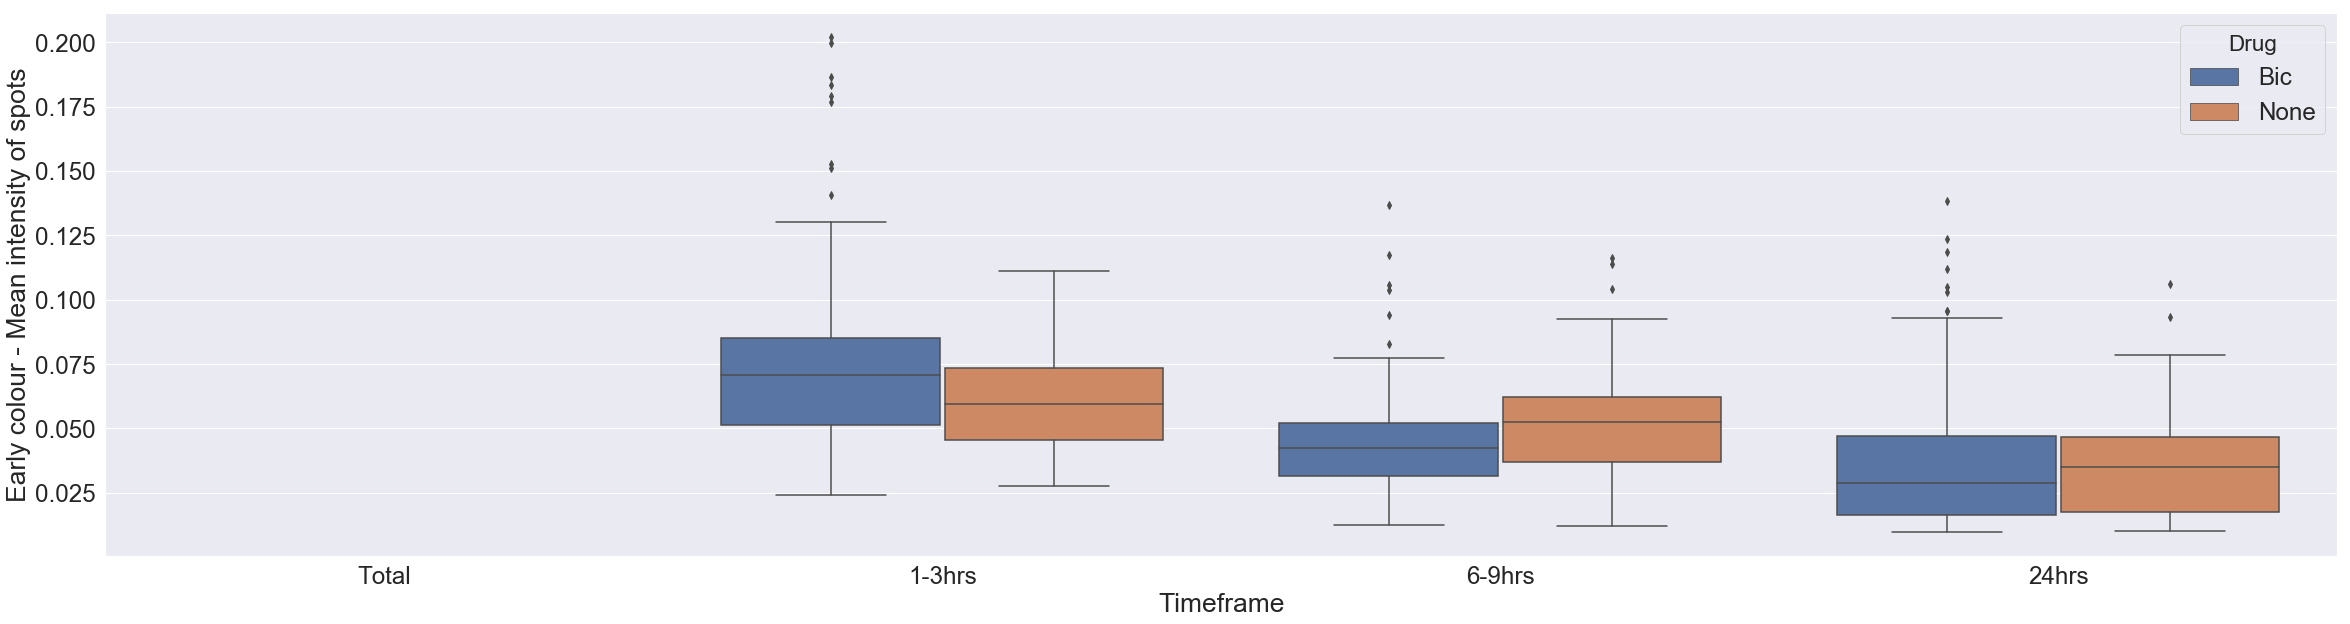

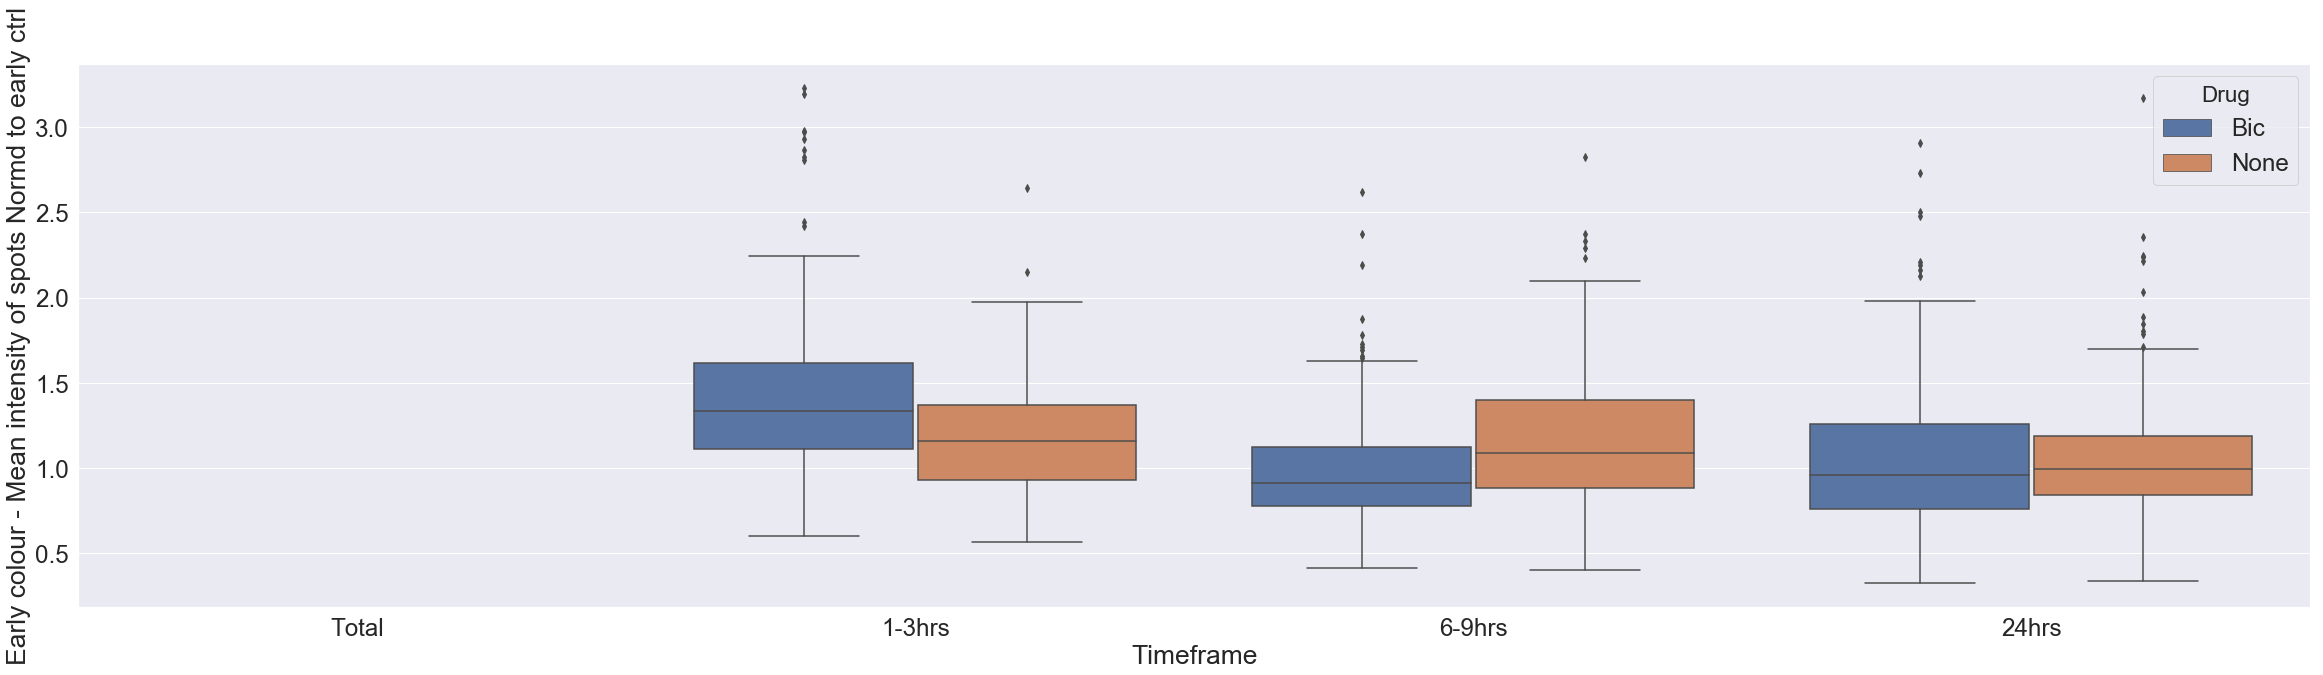

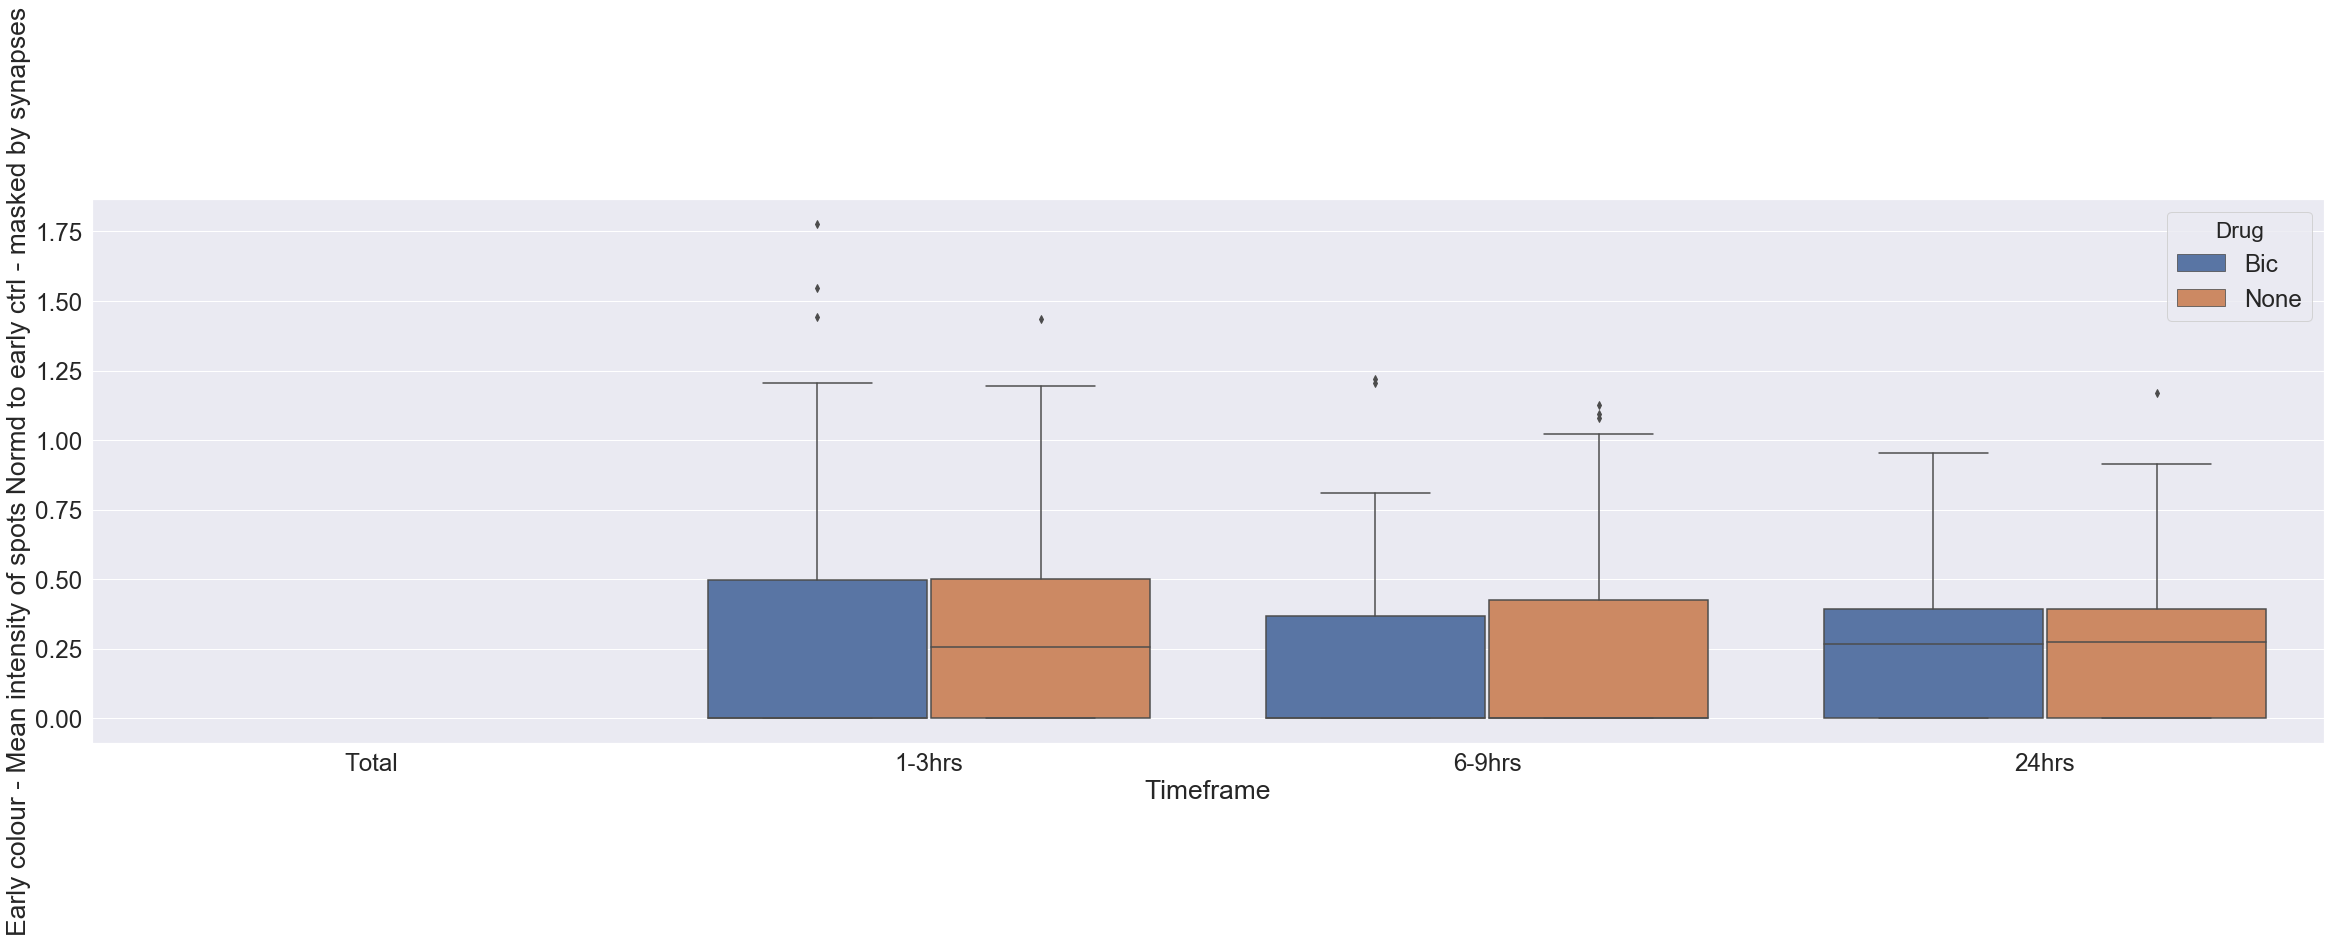

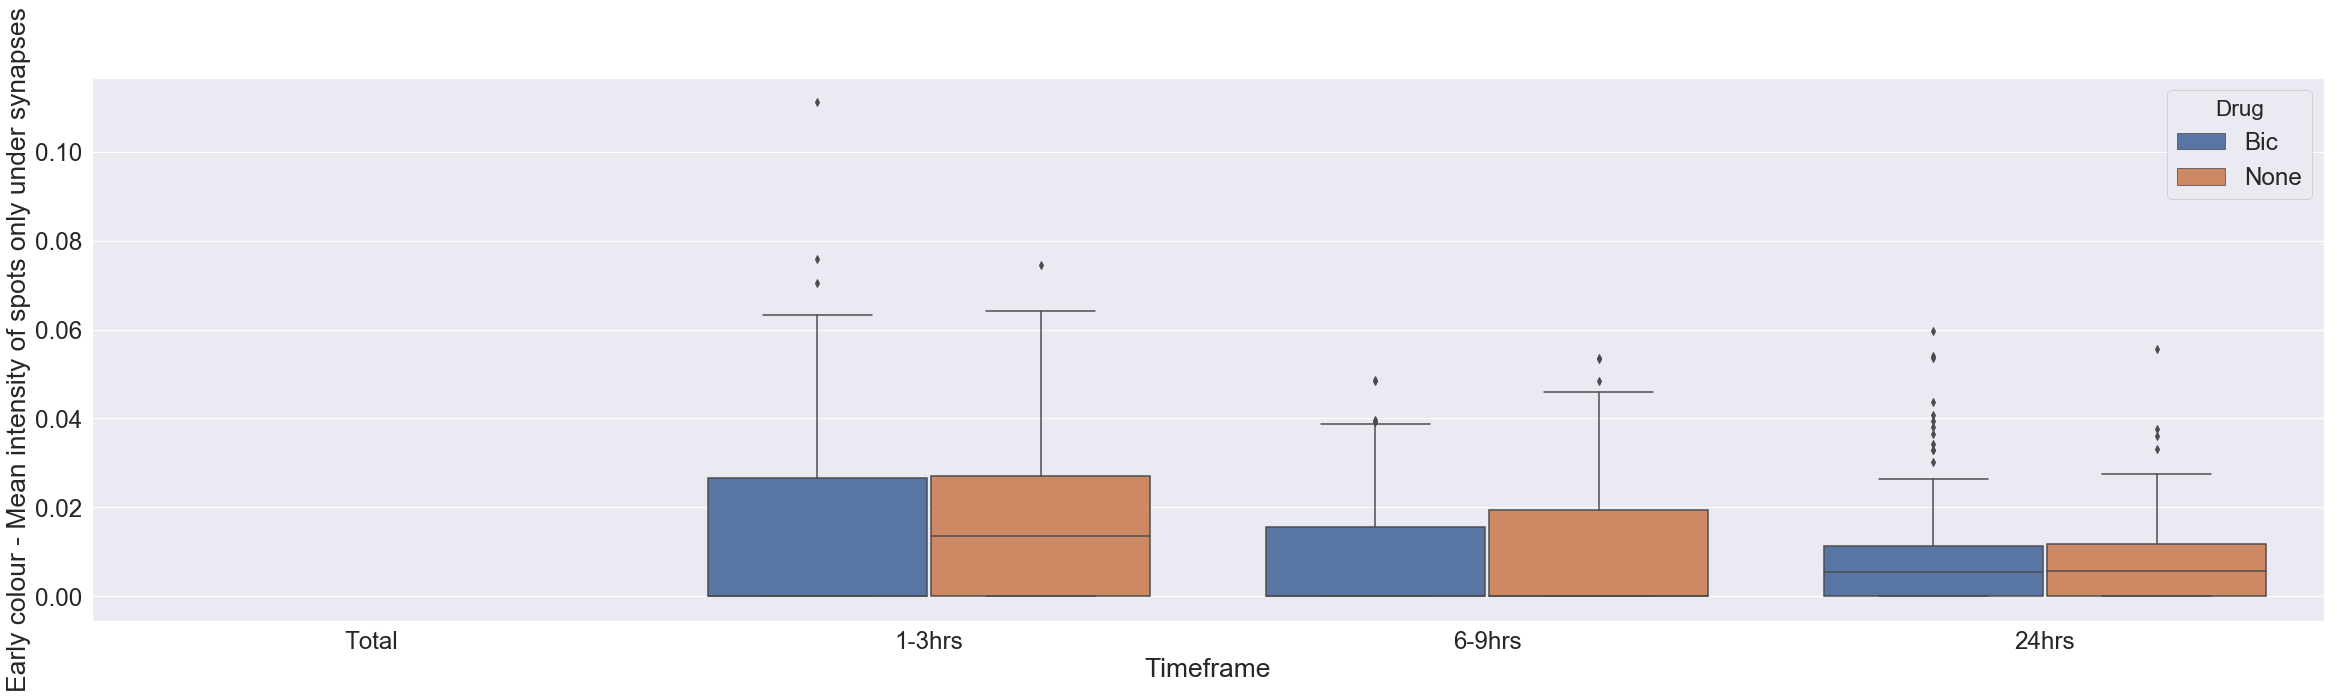

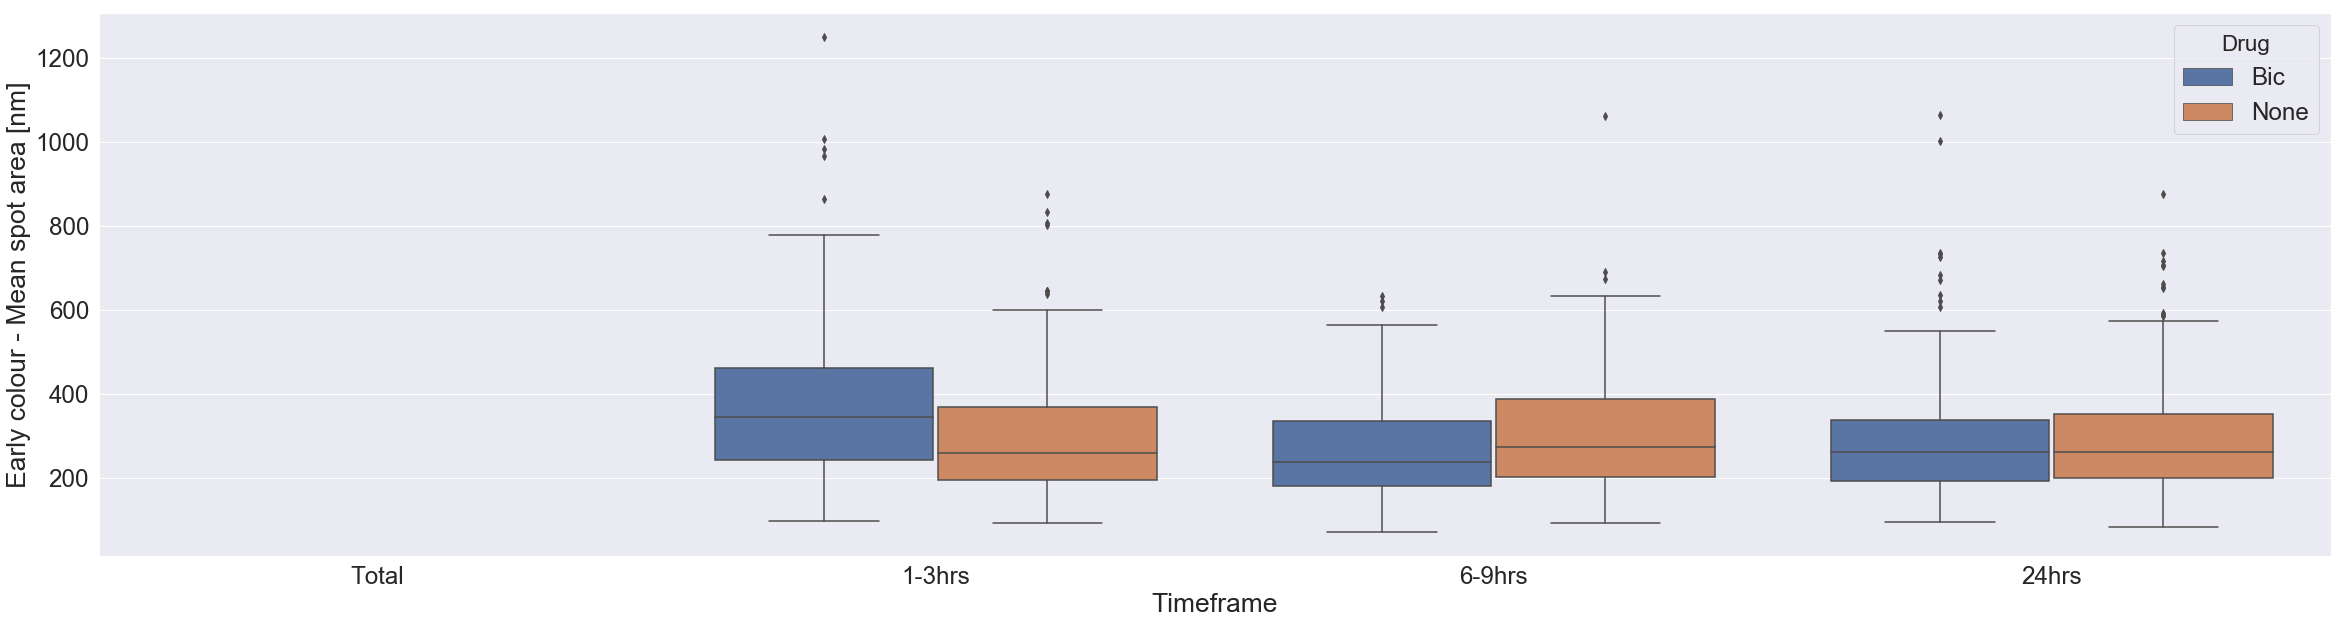

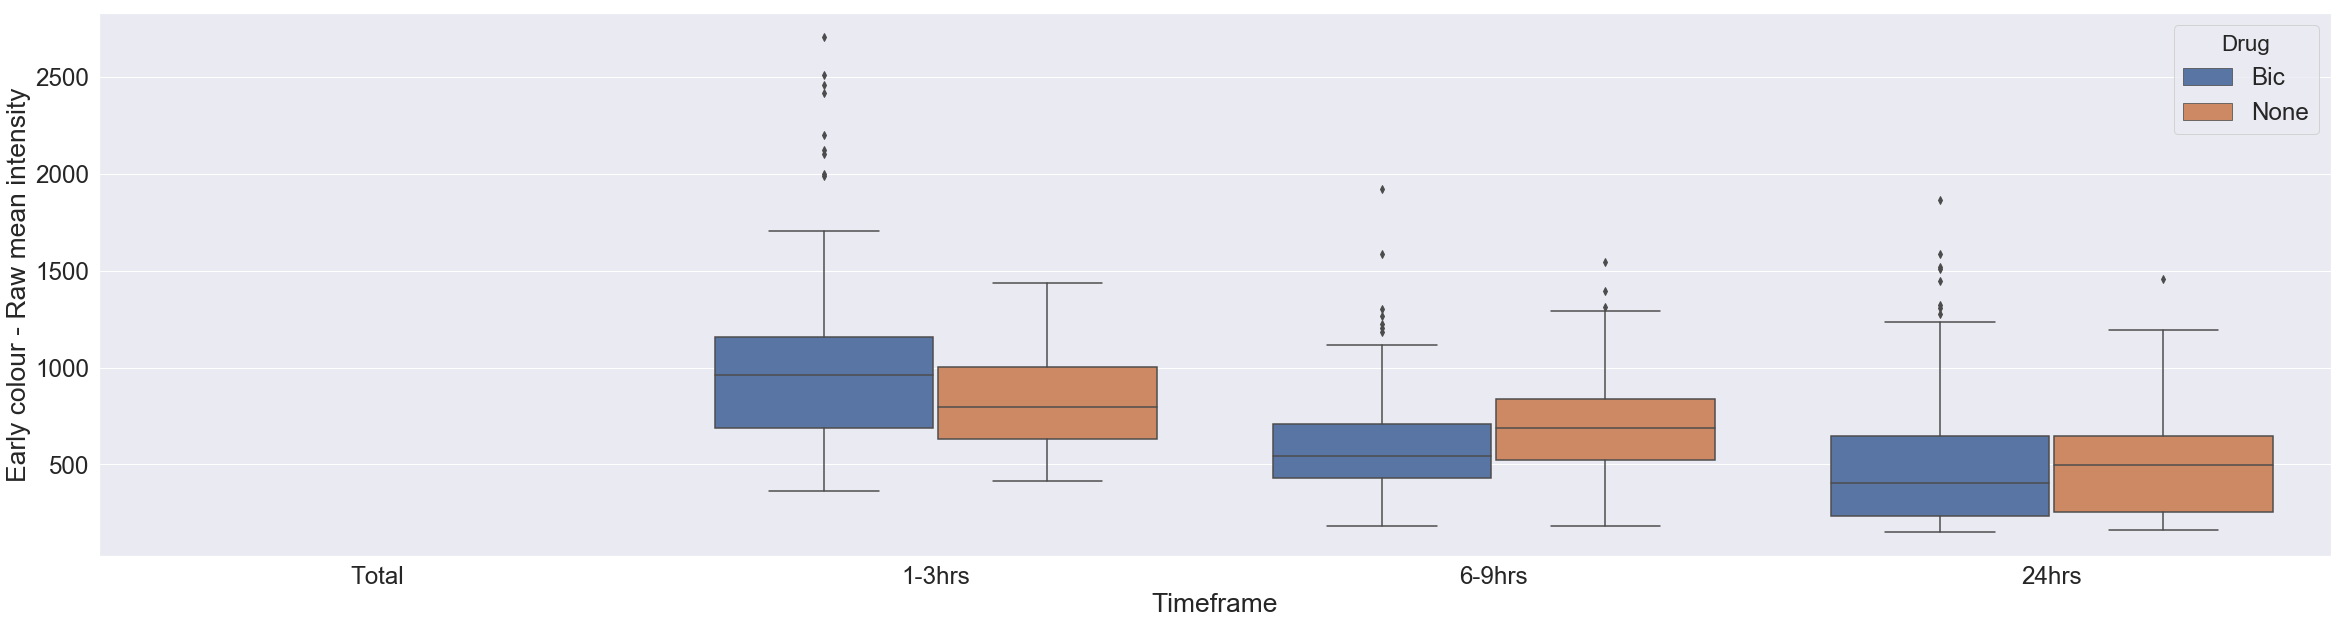

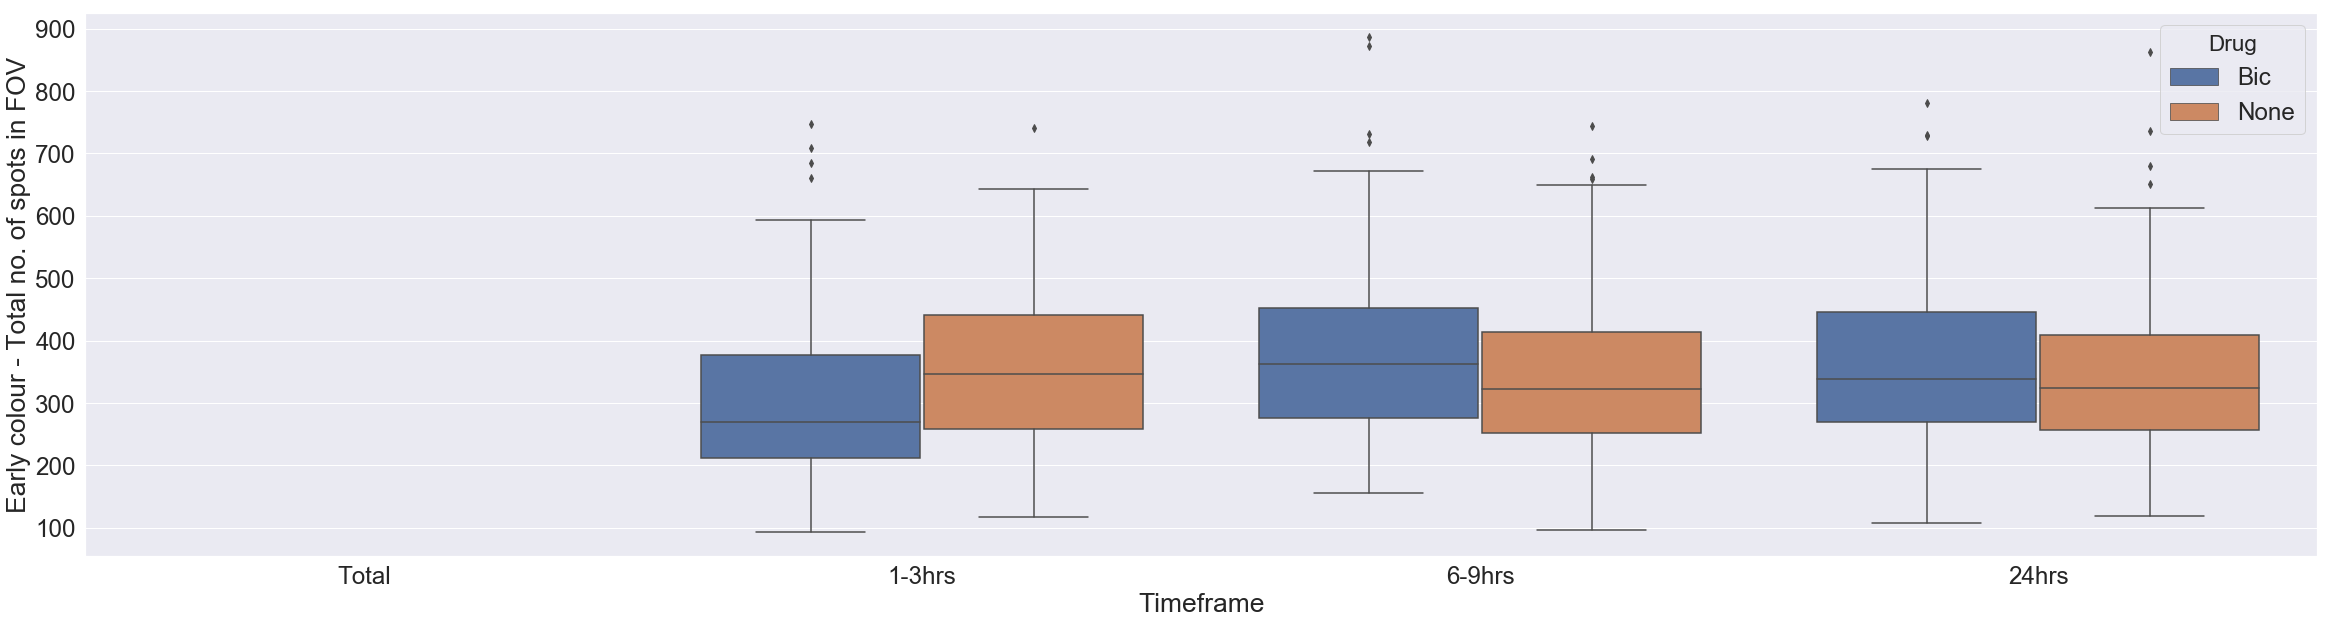

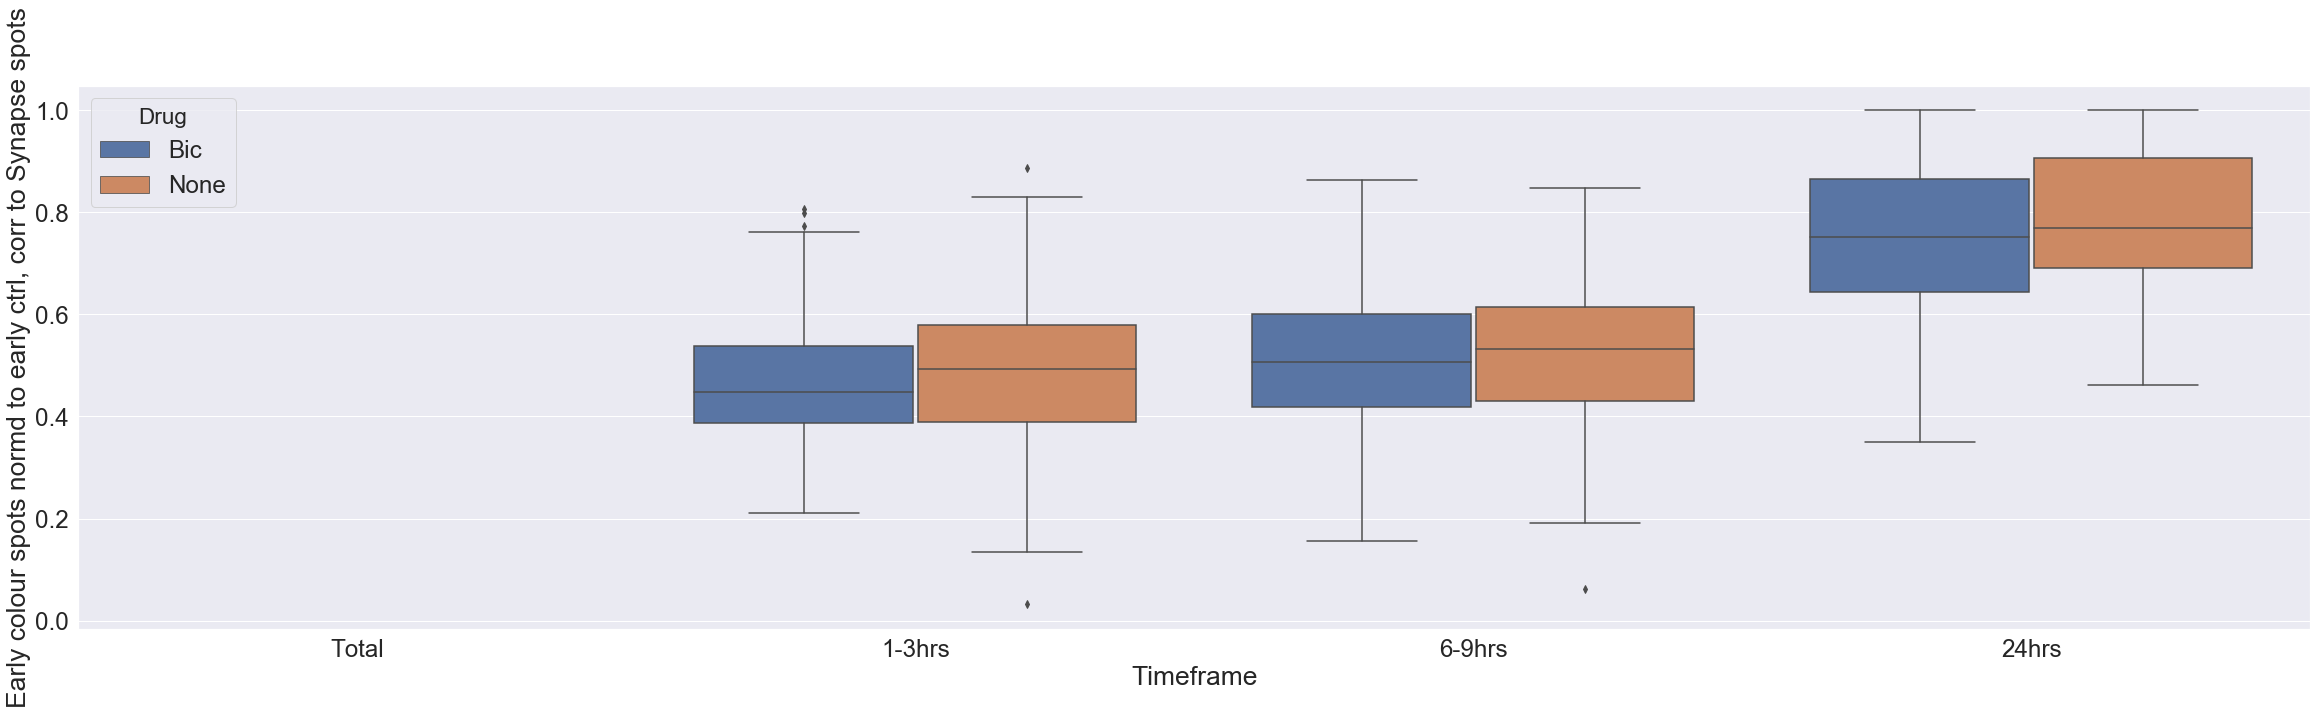

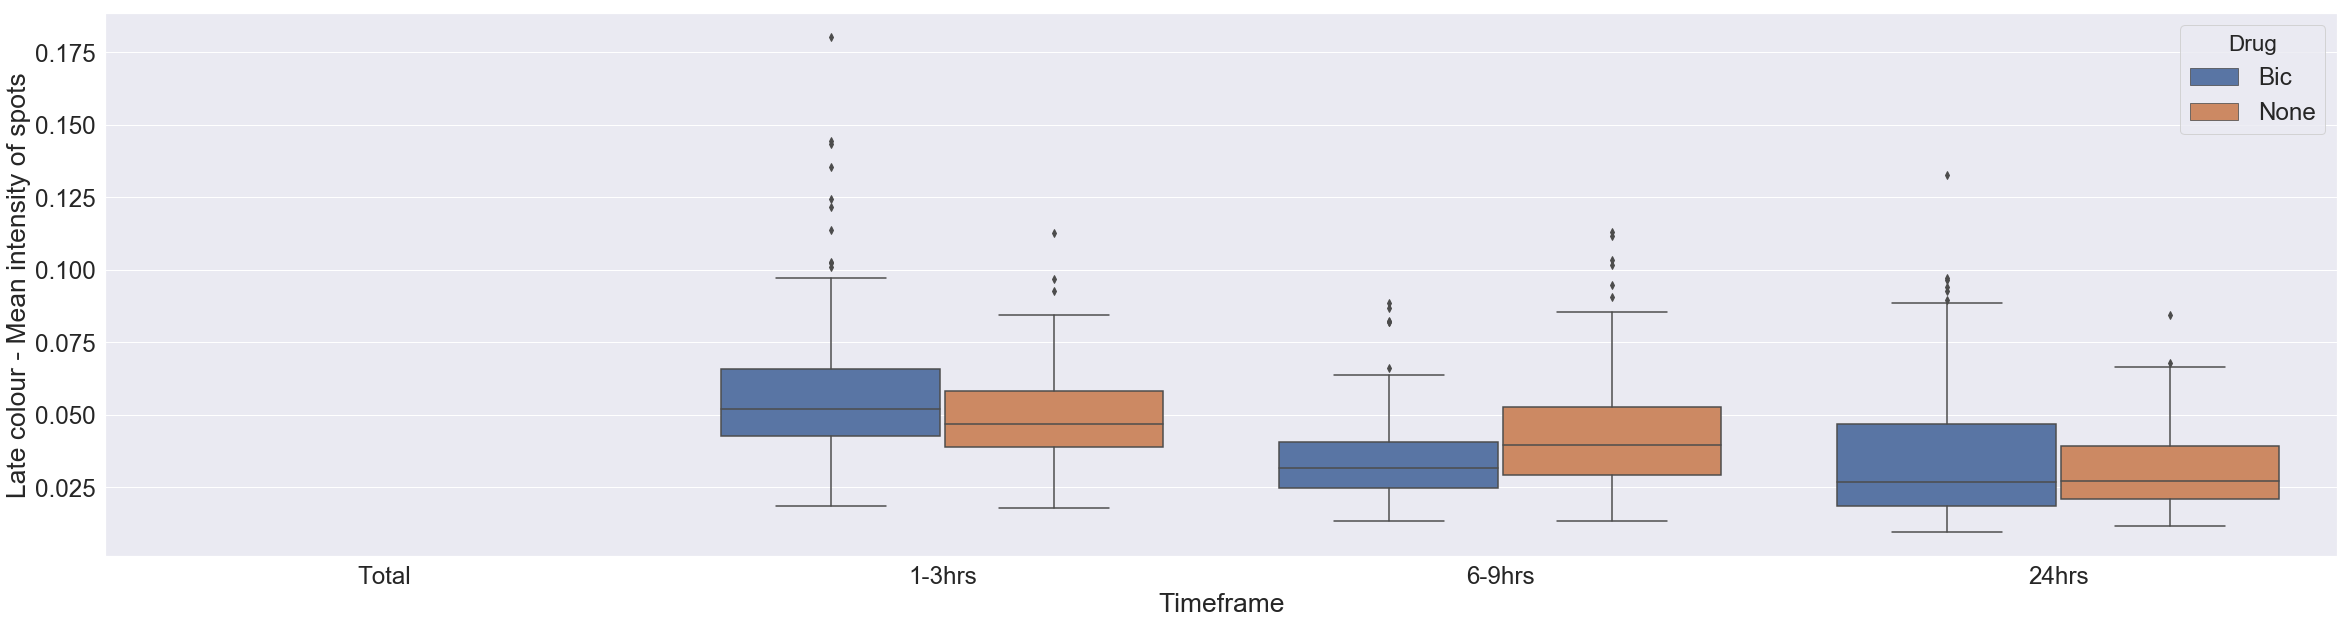

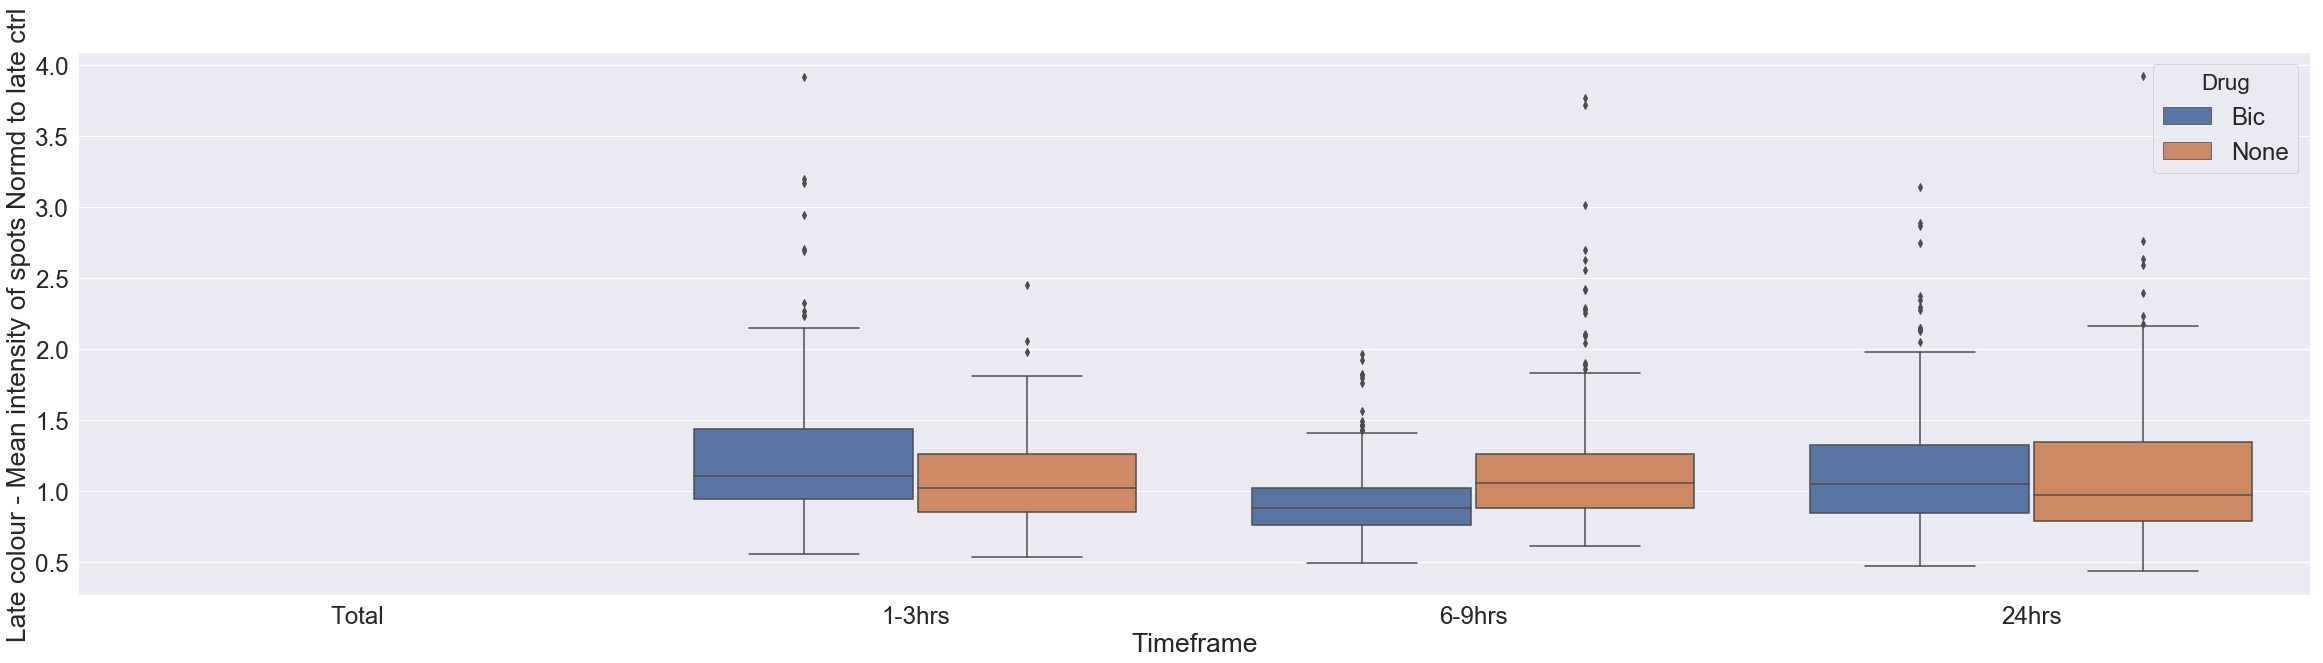

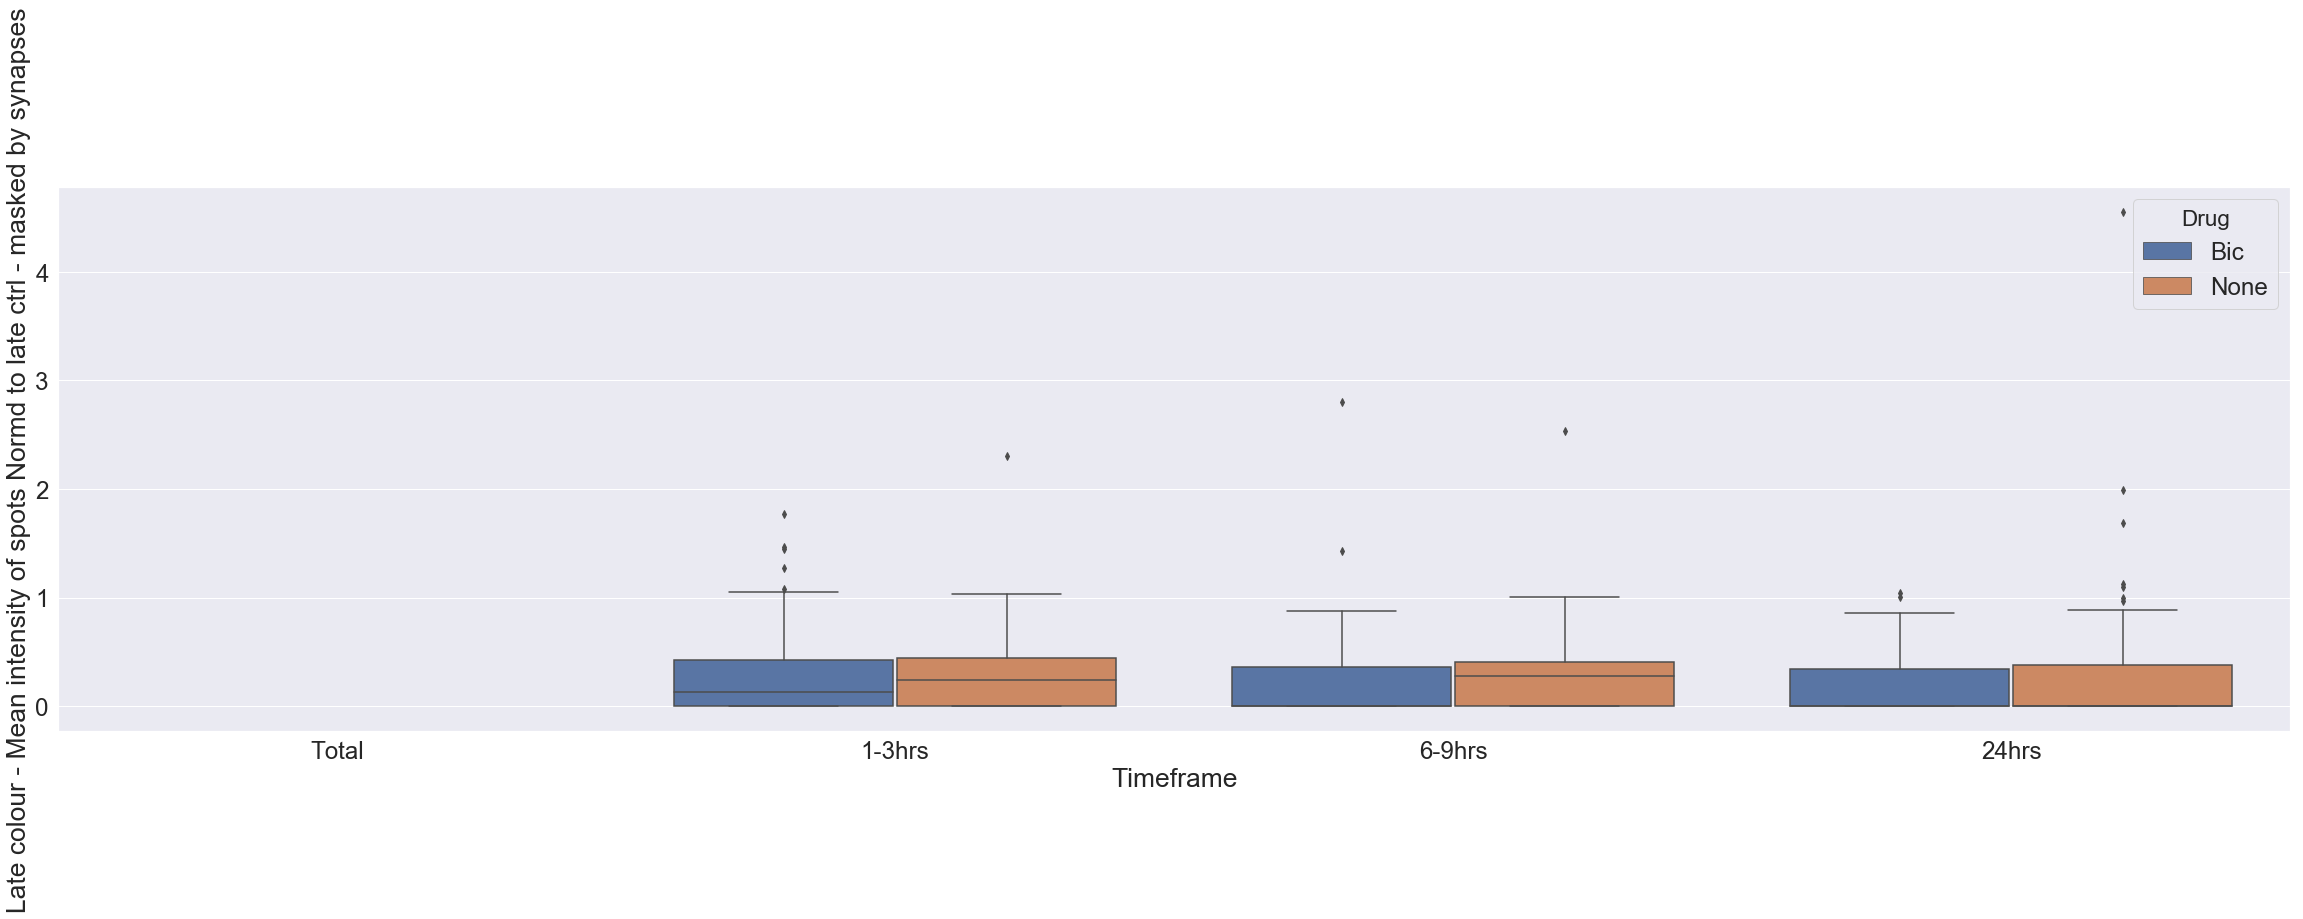

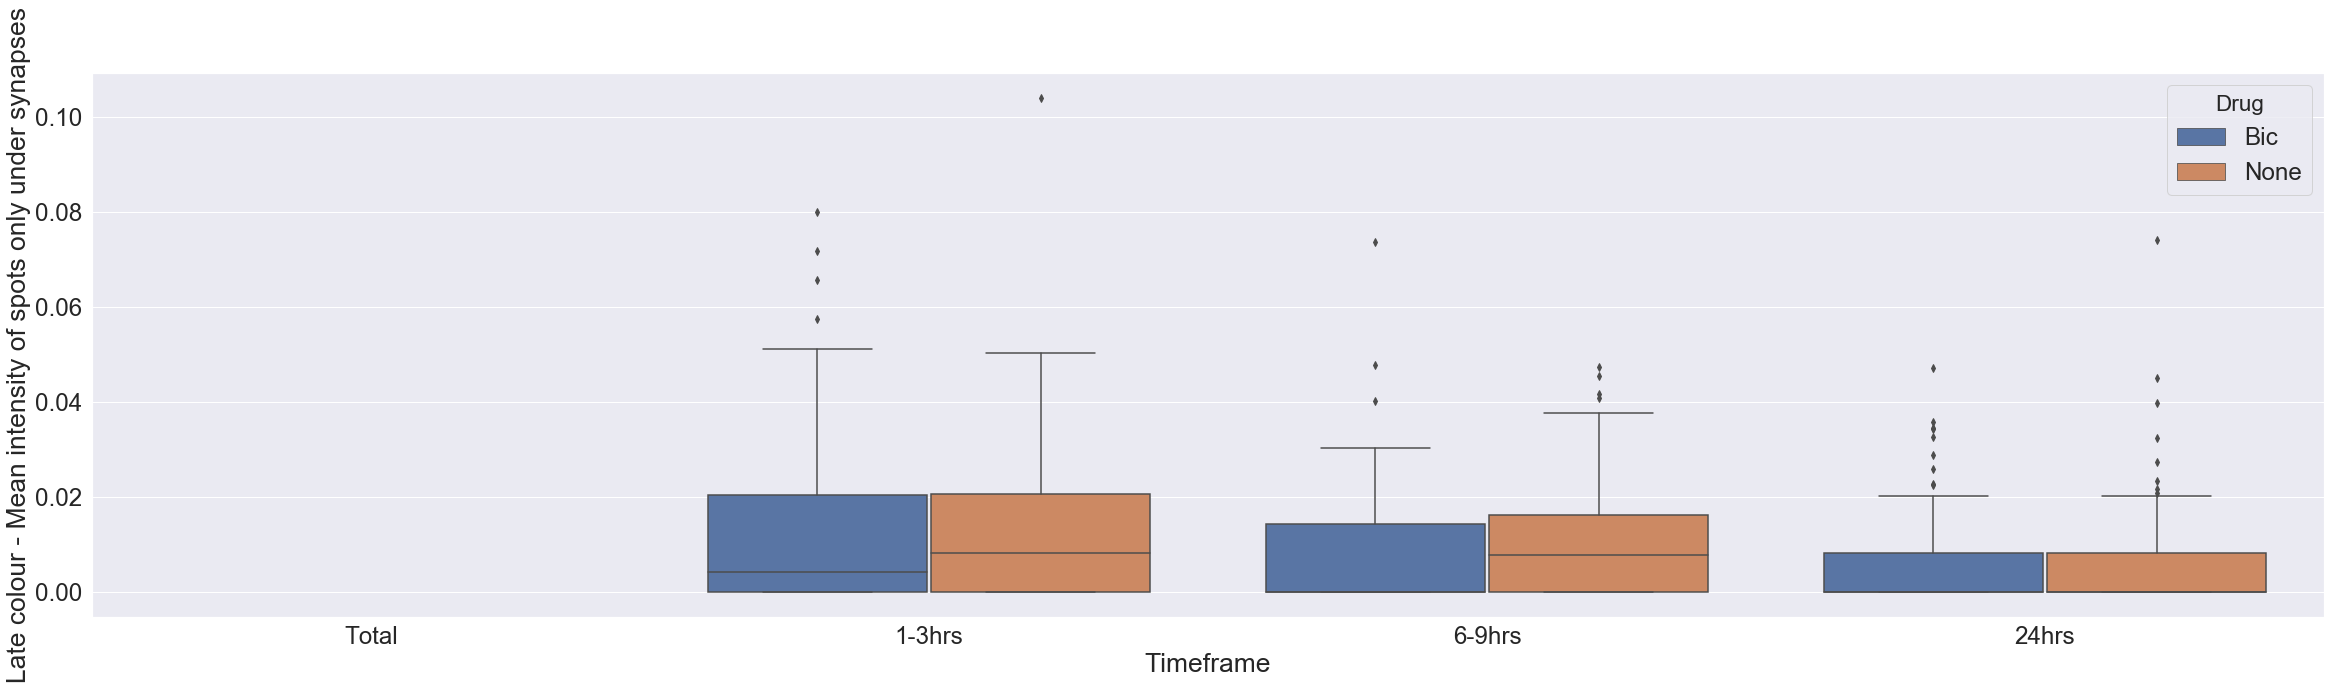

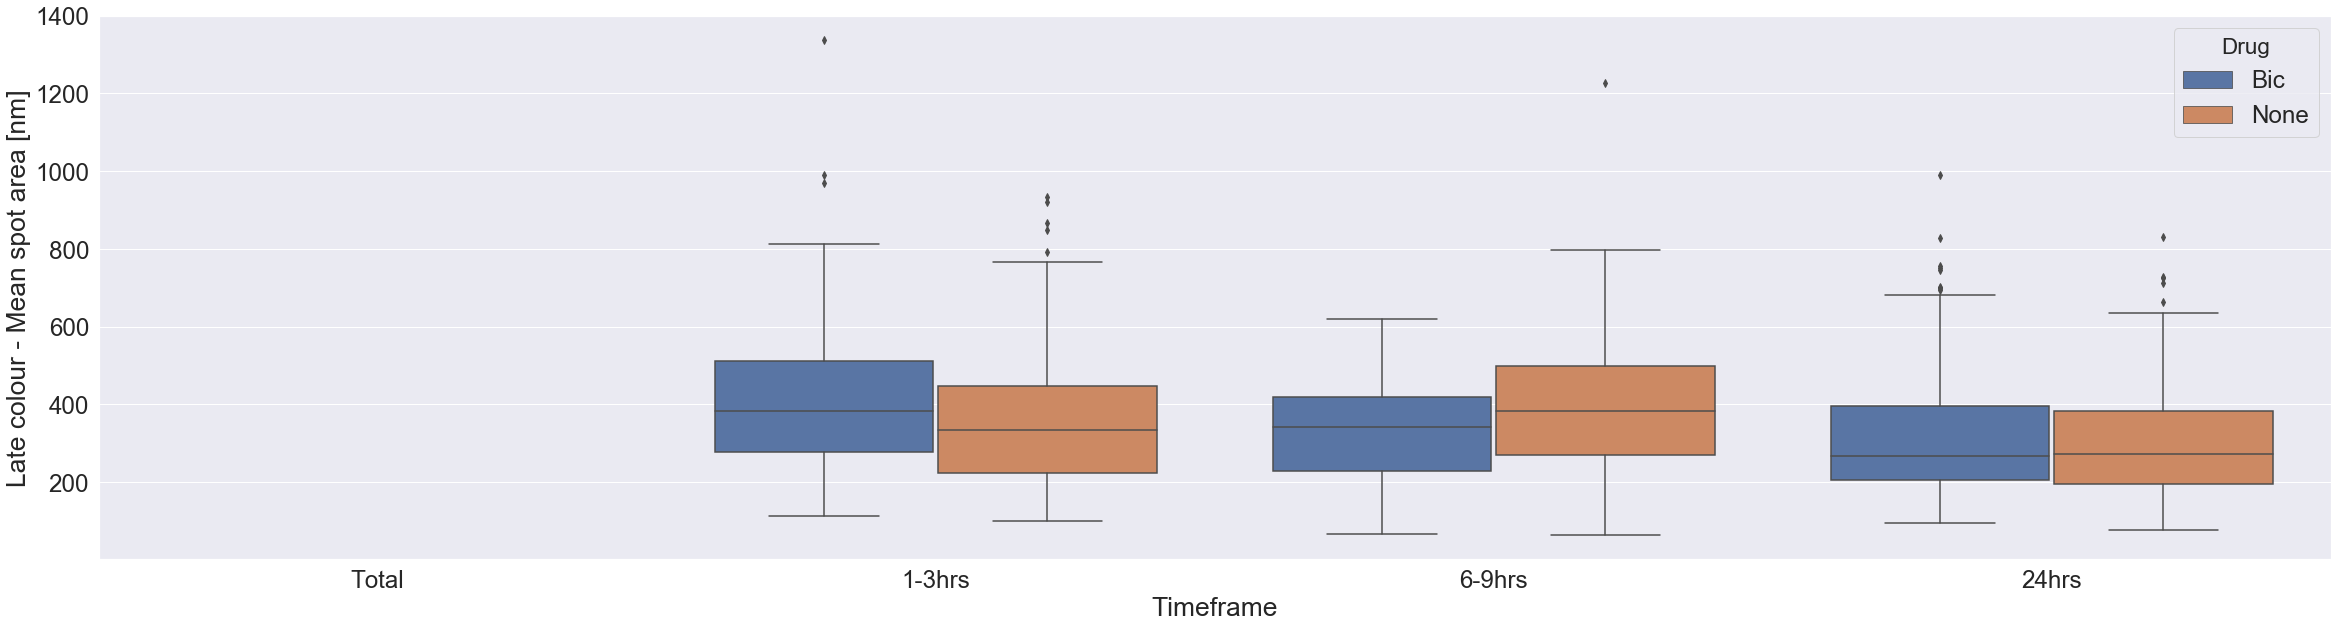

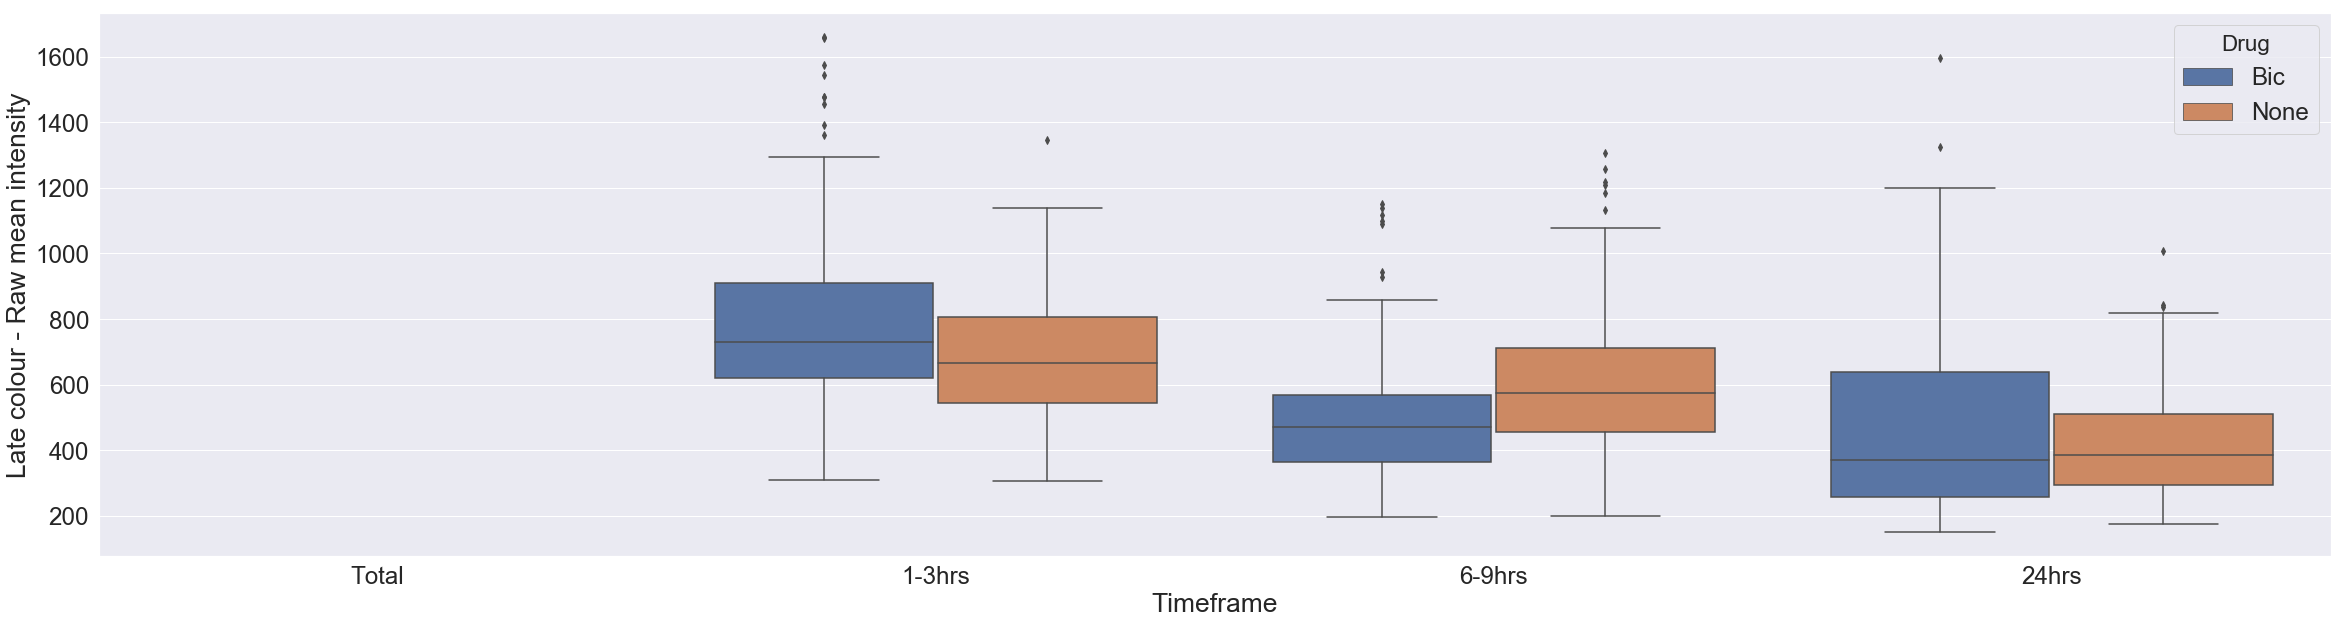

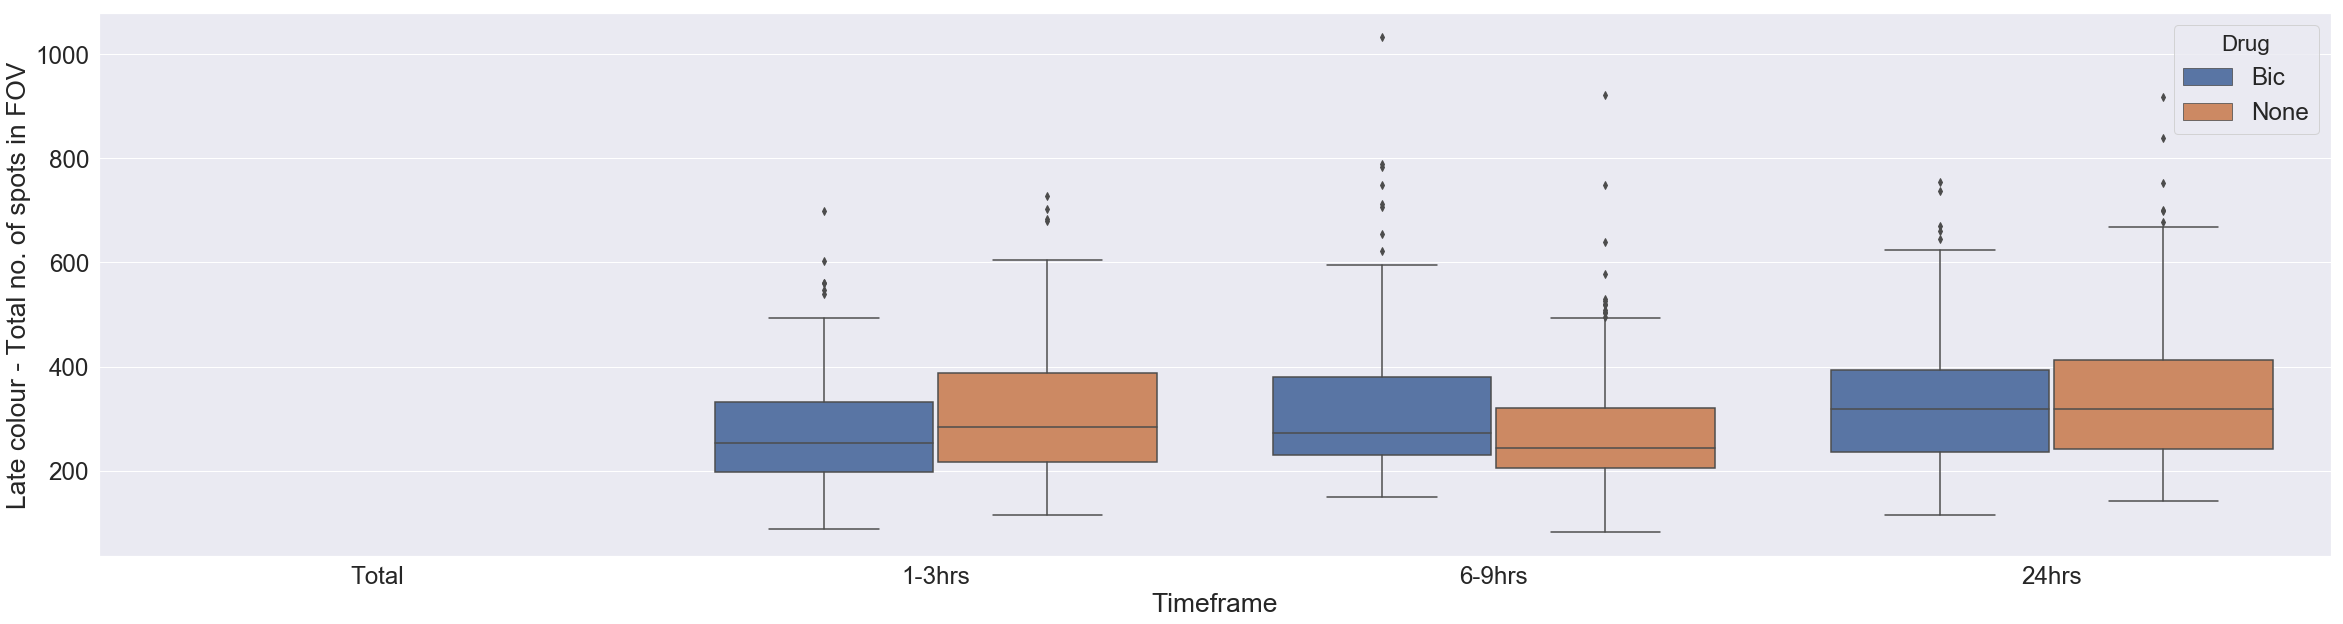

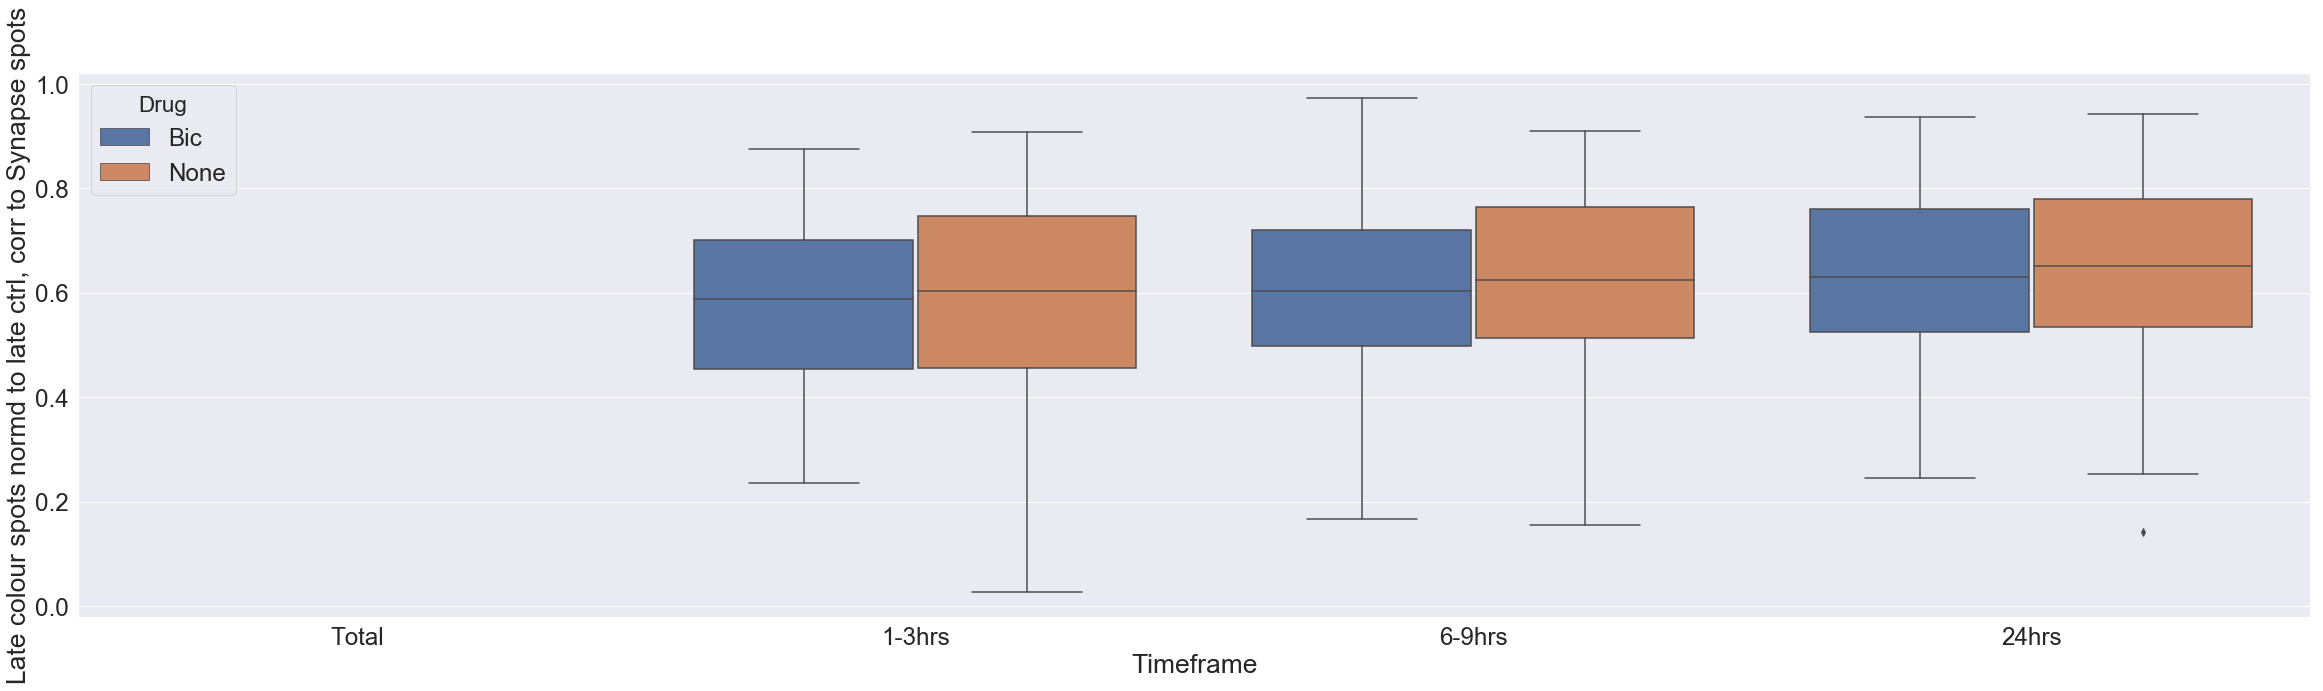

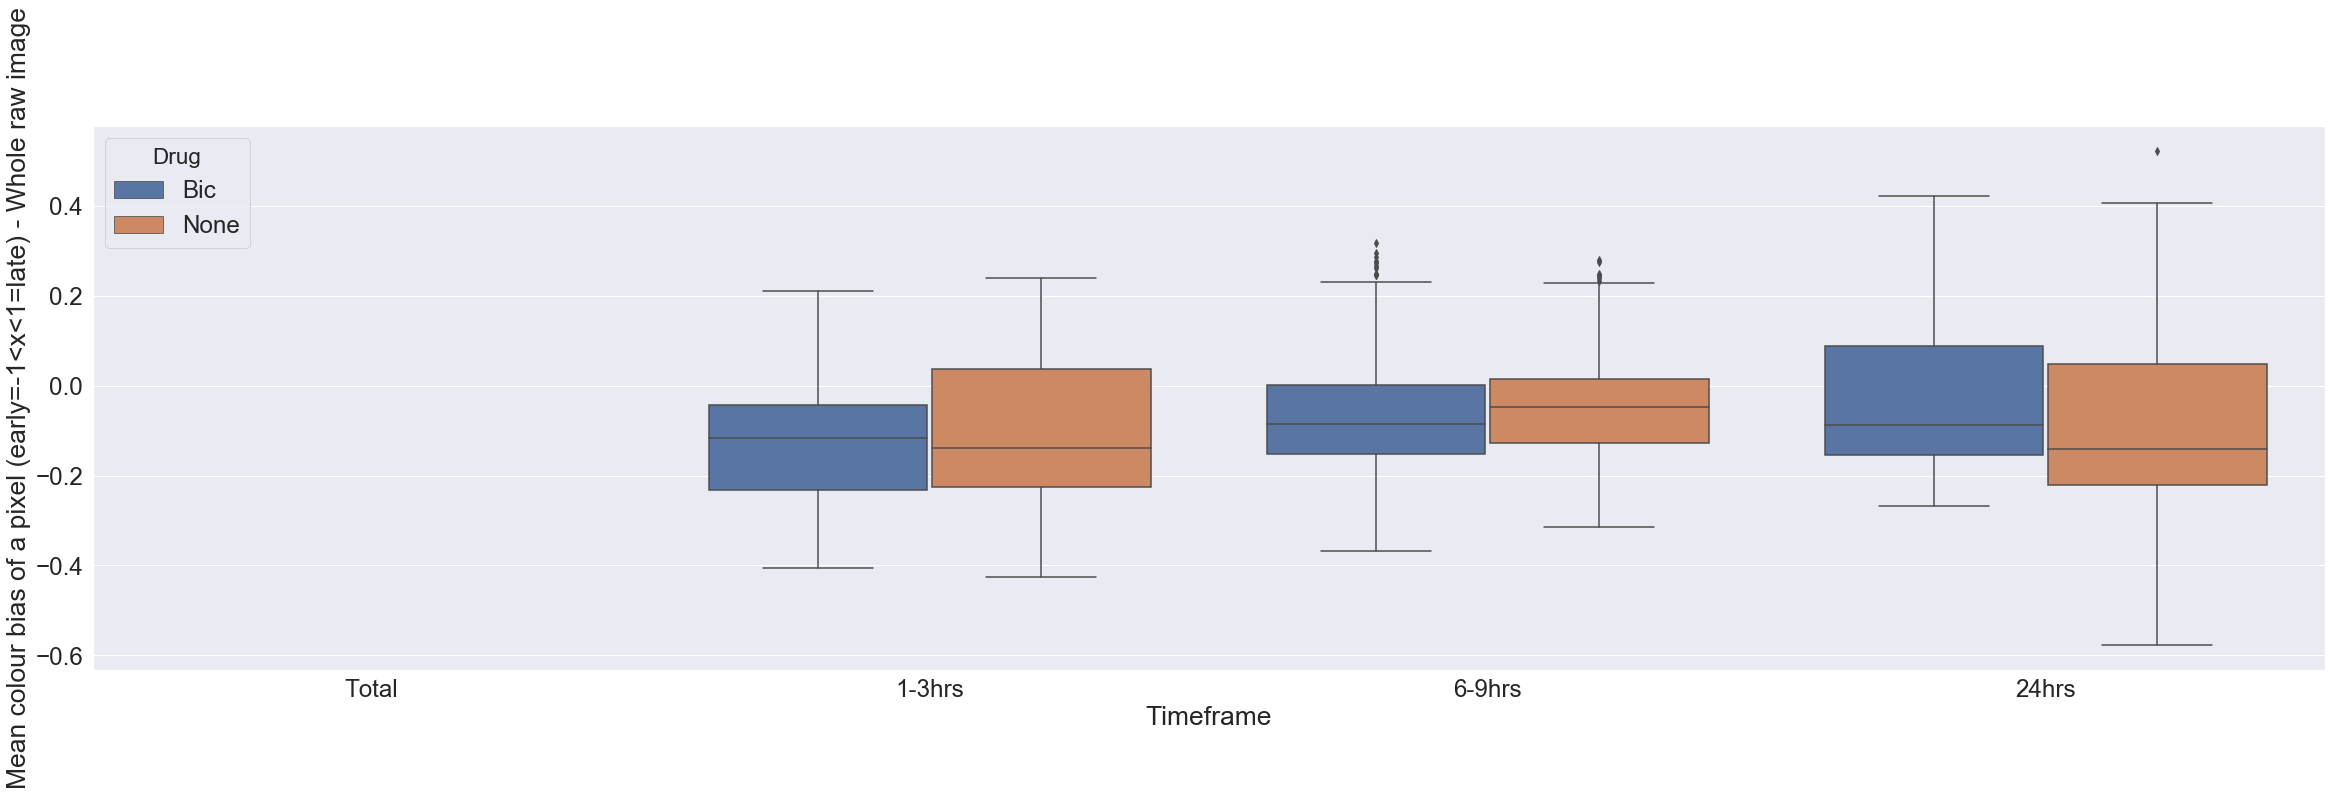

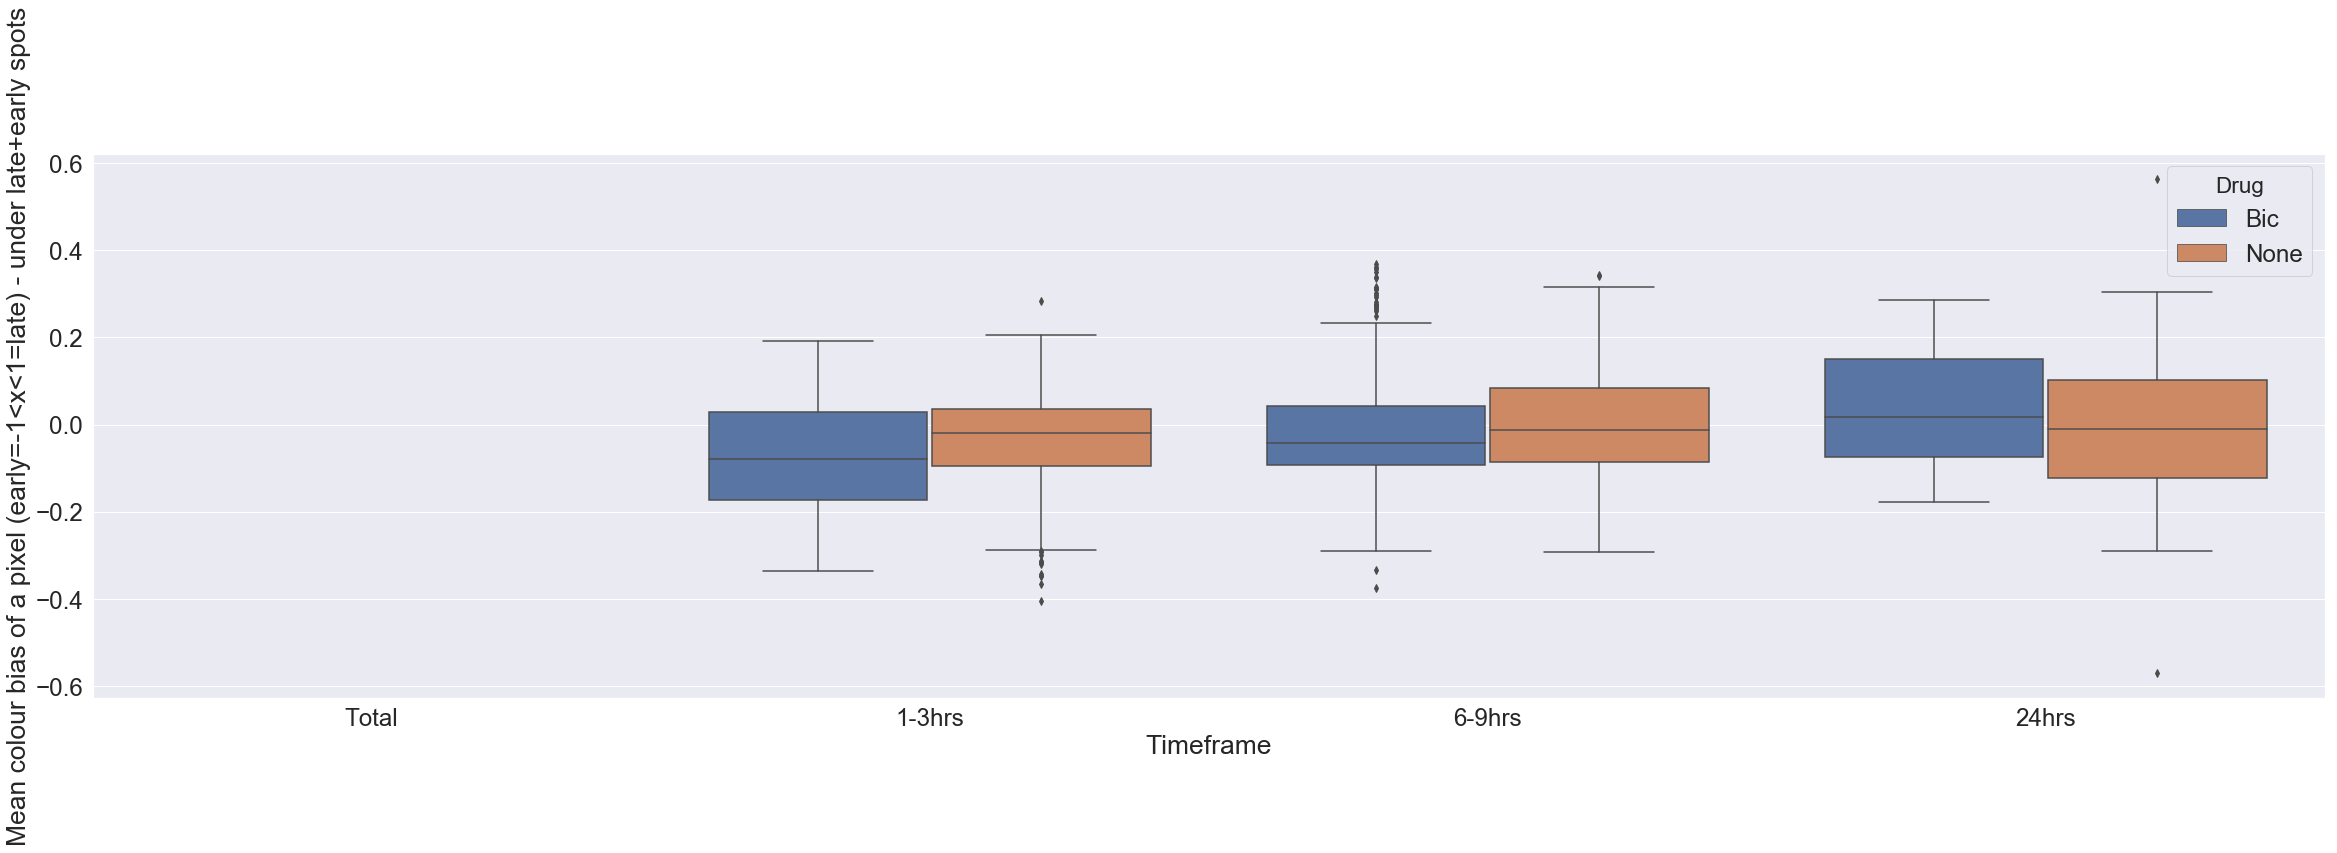

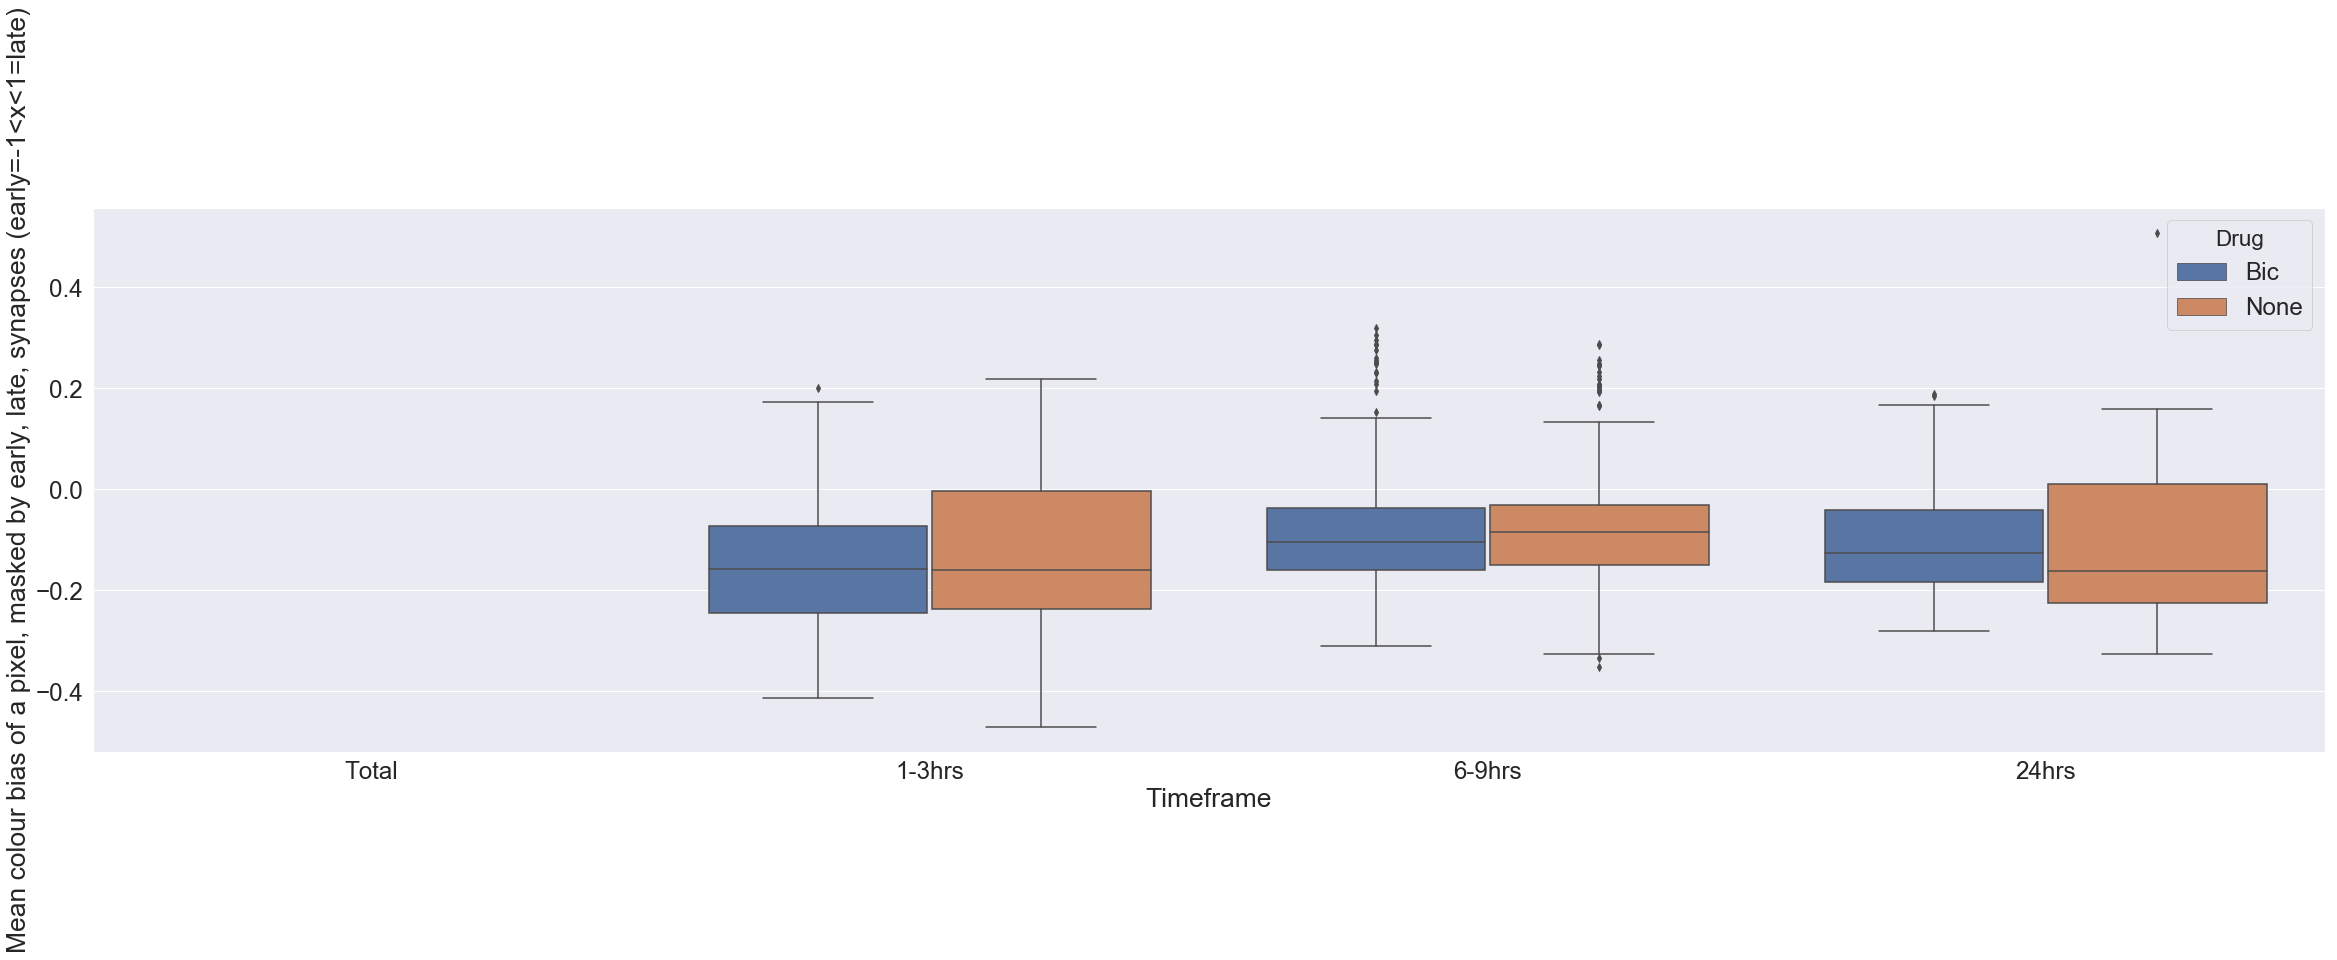

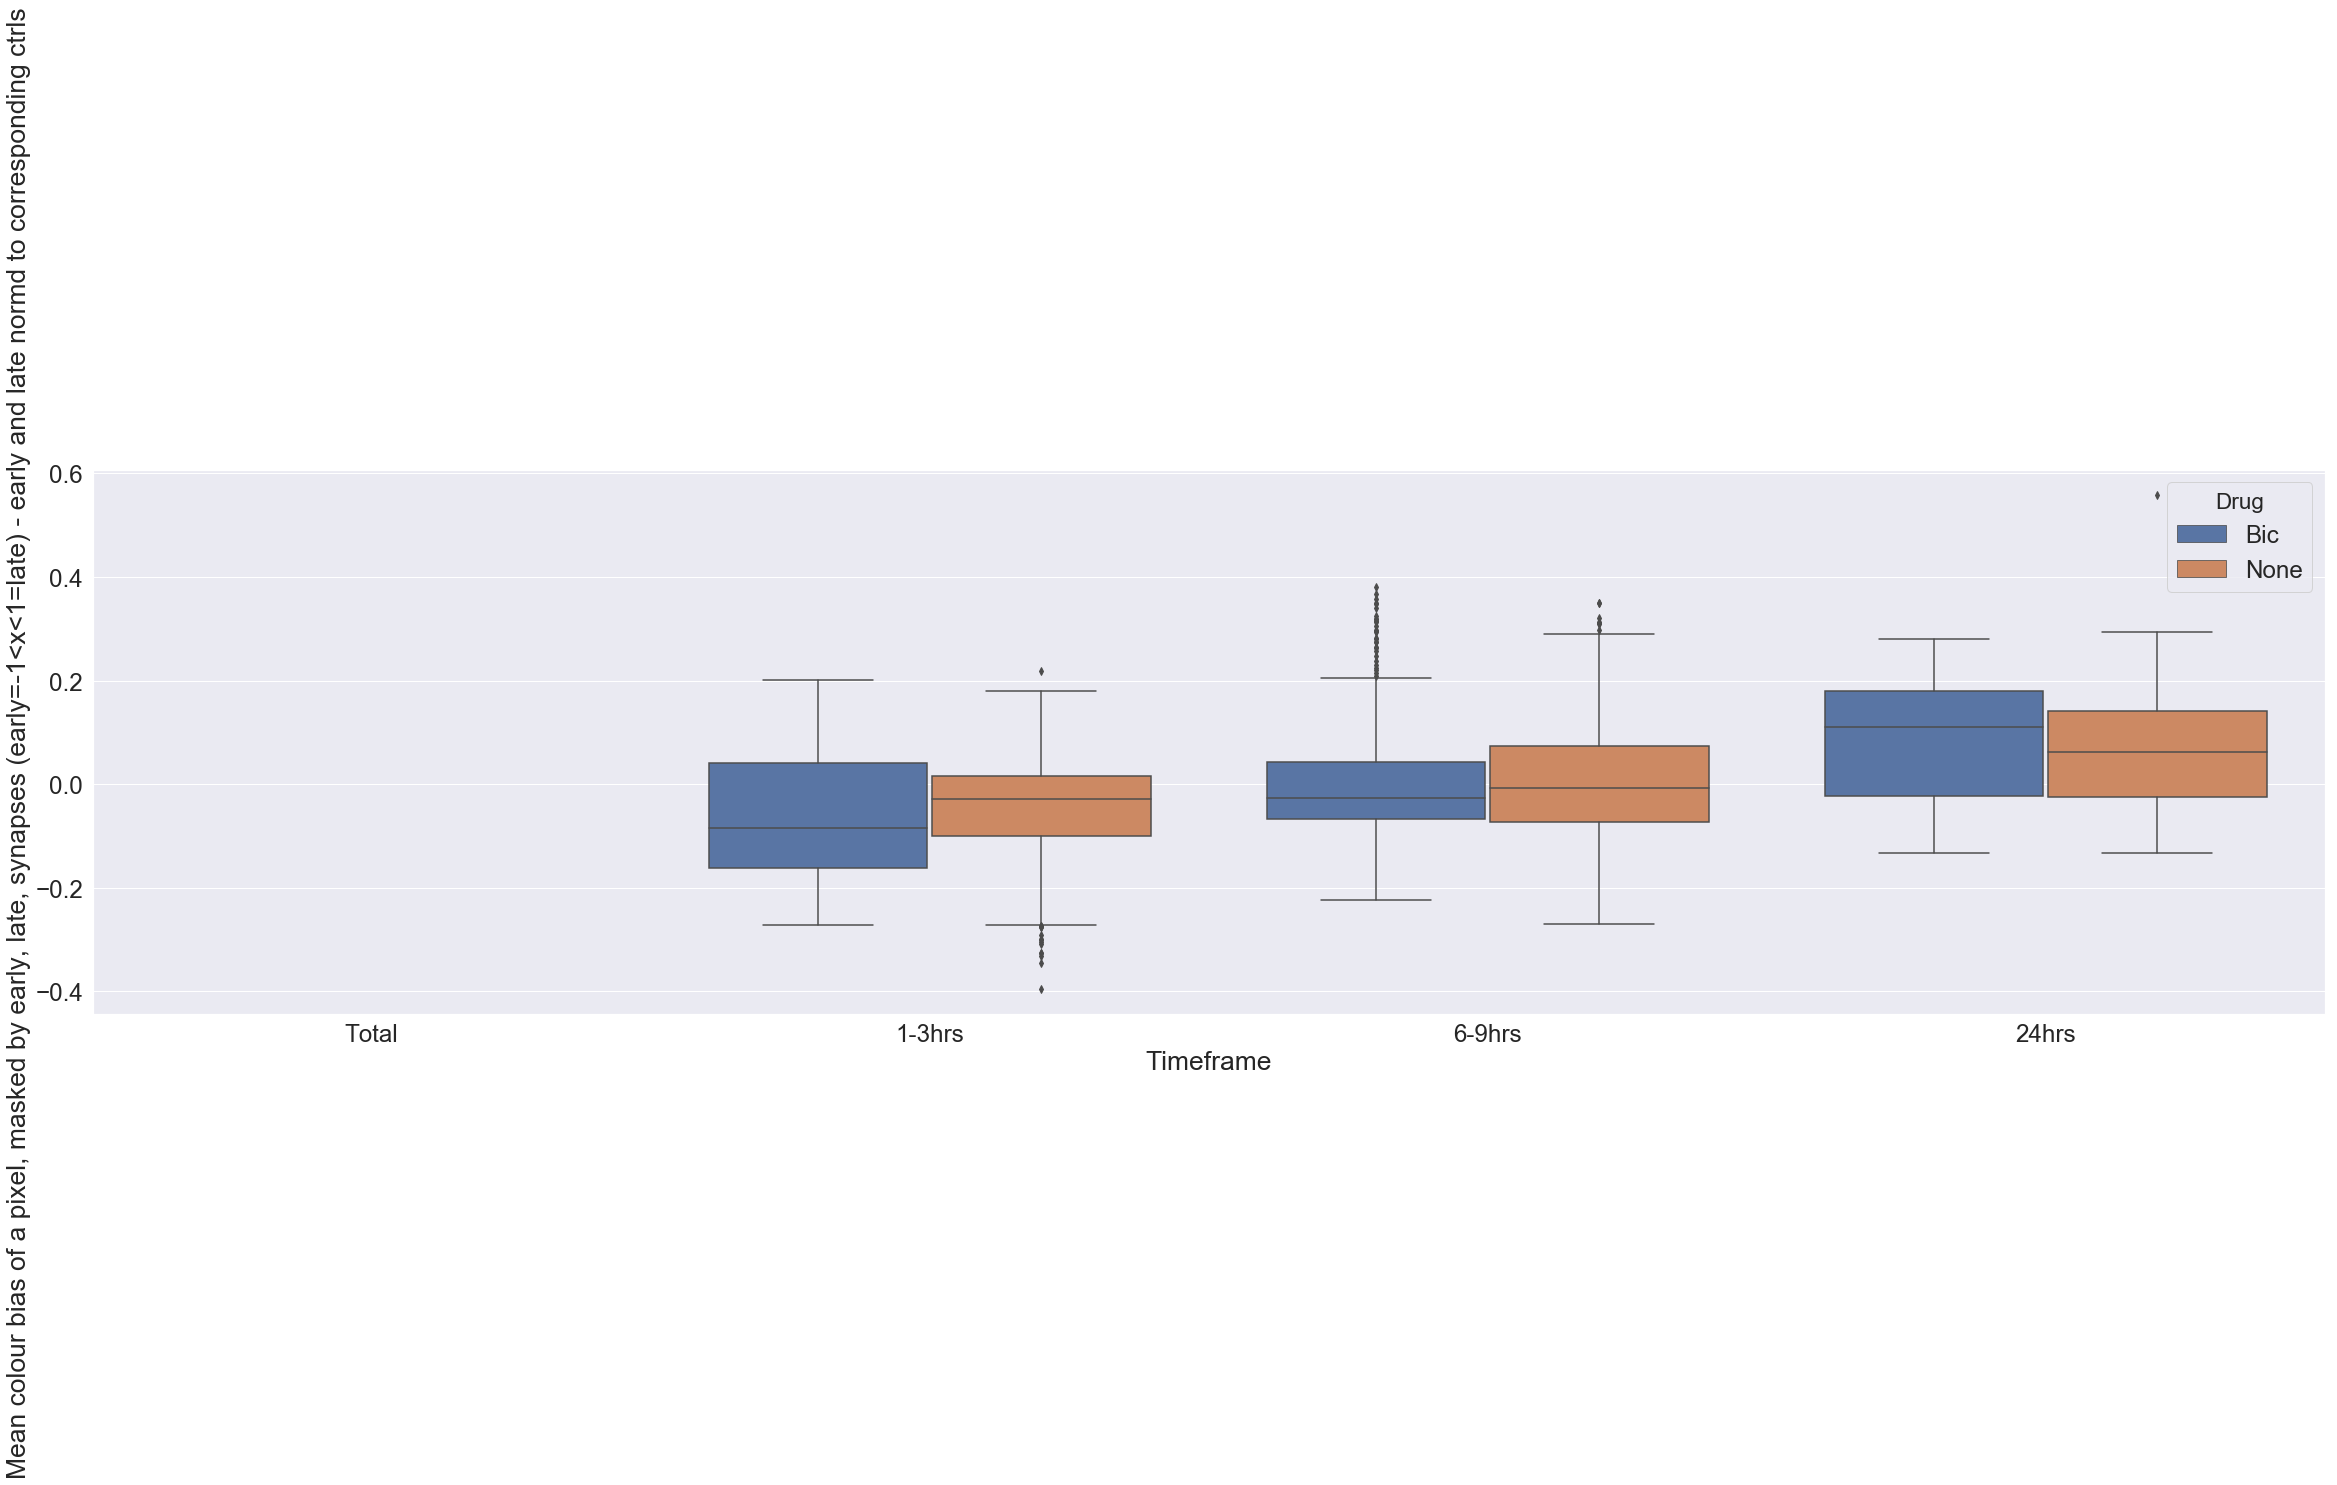

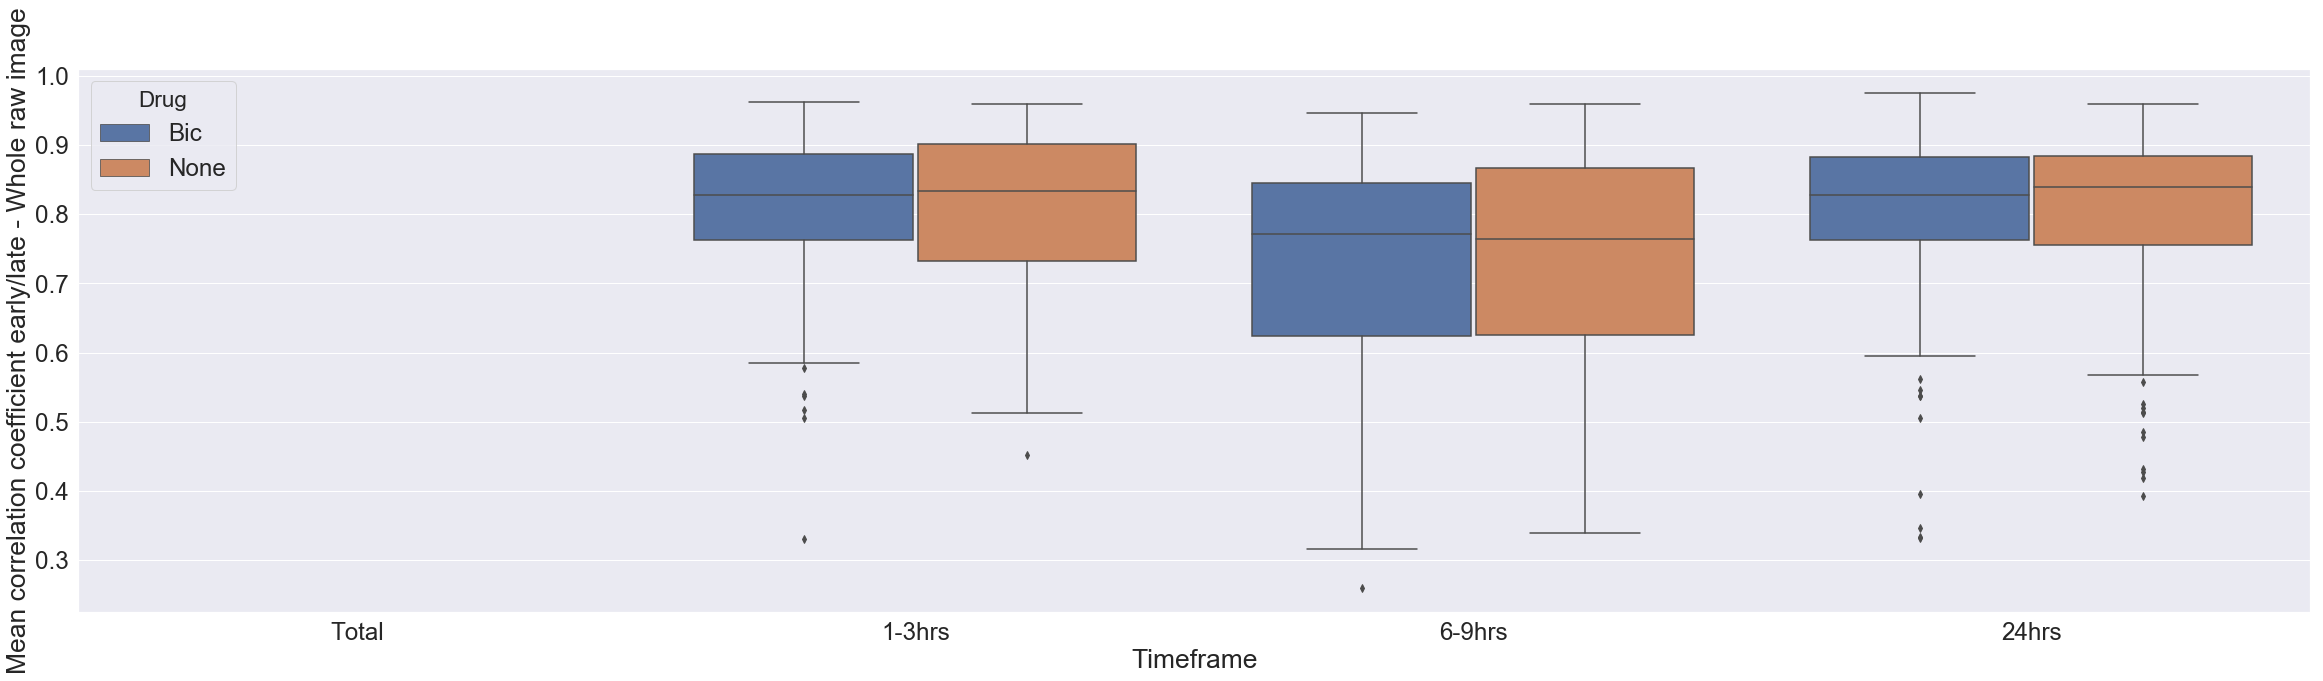

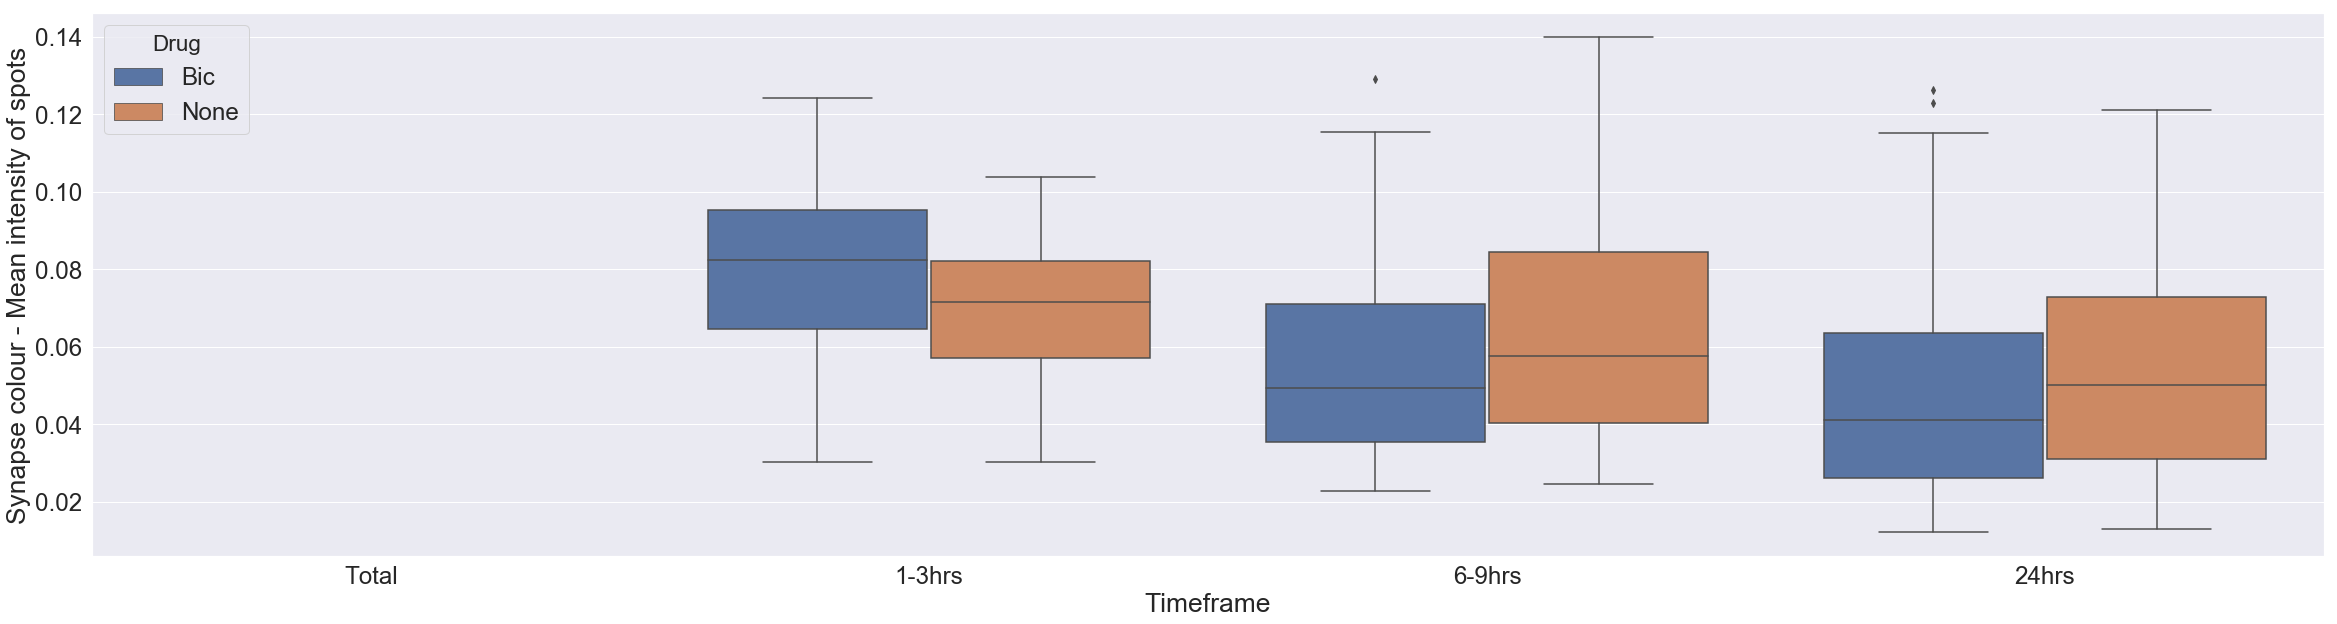

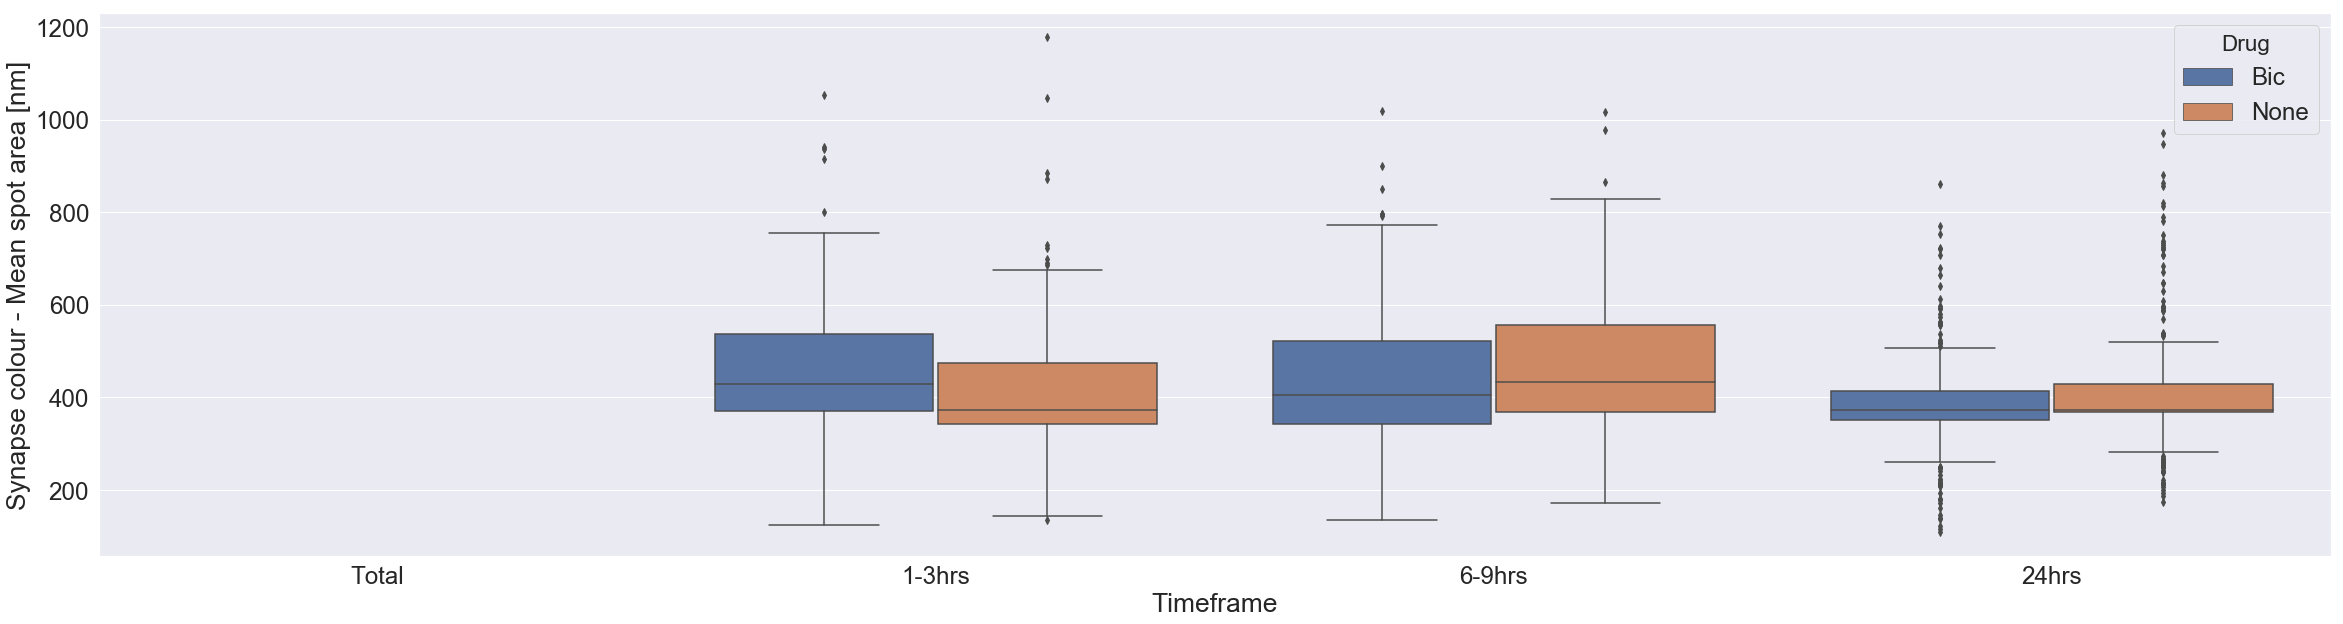

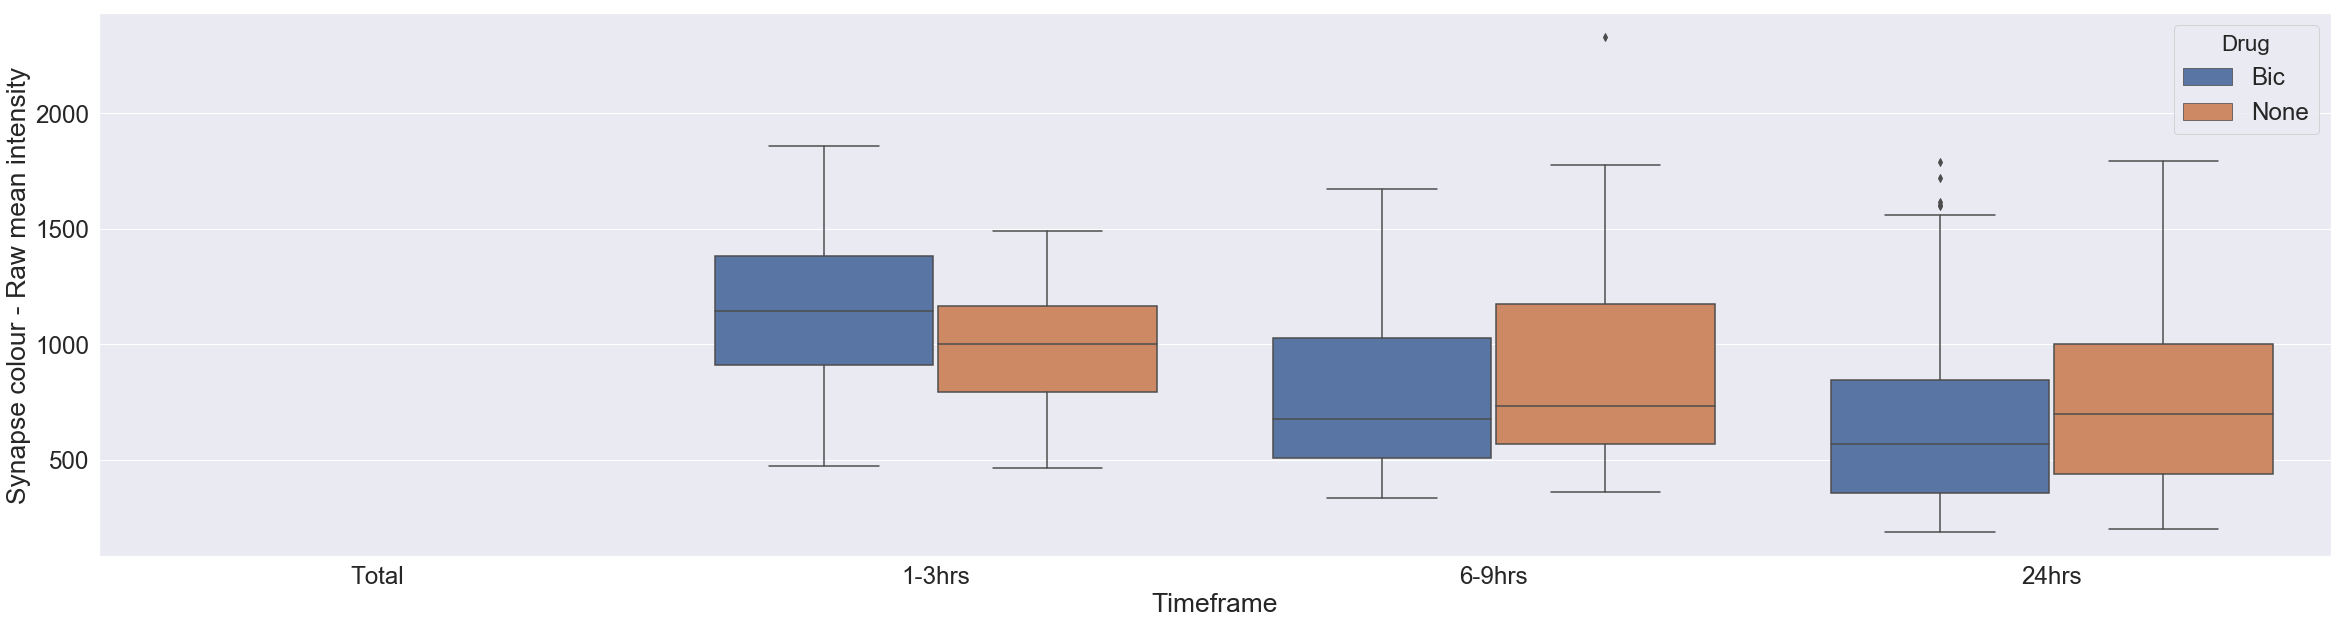

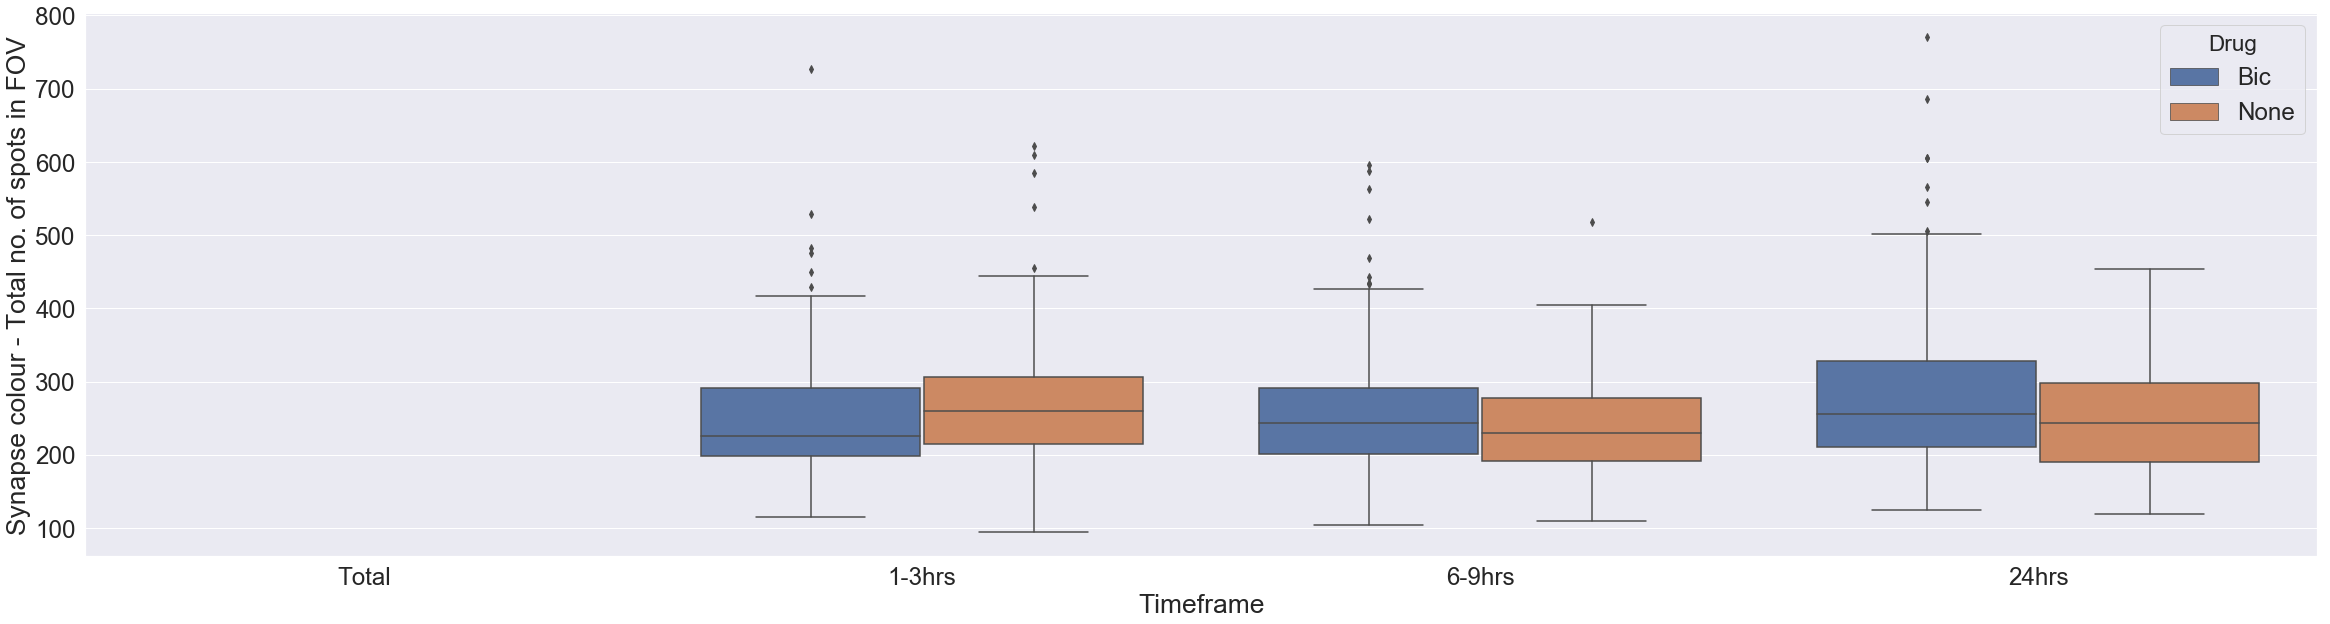

In [225]:
vars=['Early colour - Mean intensity of spots',
       'Early colour - Mean intensity of spots Normd to early ctrl',
       'Early colour - Mean intensity of spots Normd to early ctrl - masked by synapses',
       'Early colour - Mean intensity of spots only under synapses',
       'Early colour - Mean spot area [nm]',
       'Early colour - Raw mean intensity',
       'Early colour - Total no. of spots in FOV', 
       'Early colour spots normd to early ctrl, corr to Synapse spots',
       'Late colour - Mean intensity of spots',
       'Late colour - Mean intensity of spots Normd to late ctrl',
       'Late colour - Mean intensity of spots Normd to late ctrl - masked by synapses',
       'Late colour - Mean intensity of spots only under synapses',
       'Late colour - Mean spot area [nm]', 'Late colour - Raw mean intensity',
       'Late colour - Total no. of spots in FOV', 
       'Late colour spots normd to late ctrl, corr to Synapse spots',
       
       'Mean colour bias of a pixel (early=-1<x<1=late) - Whole raw image',
       'Mean colour bias of a pixel (early=-1<x<1=late) - under late+early spots',
       'Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late)',
       'Mean colour bias of a pixel, masked by early, late, synapses (early=-1<x<1=late) - early and late normd to corresponding ctrls',
       'Mean correlation coefficient early/late - Whole raw image',
       'Synapse colour - Mean intensity of spots',
       'Synapse colour - Mean spot area [nm]',
       'Synapse colour - Raw mean intensity',
       'Synapse colour - Total no. of spots in FOV']
sns.set(font_scale=2.2)
for plot in vars:
    plt.figure(figsize=(40,10))
    sns.boxplot(x="Timeframe",y=plot,data=df2,order=orderlab,hue="Drug")

### Plot without controls "ctrl" in bla ==false or "Ctrl"

In [73]:
from copy import deepcopy
df3=deepcopy(df)
df2=deepcopy(df)
dfhists3=deepcopy(dfhists)
dfhists2=deepcopy(dfhists)

In [ ]:
df2[df2[""]]

In [ ]:
df2regionprops=deepcopy(dfregionprops)

In [74]:
#os.mkdir(expdir+'results_noctrls/')
df2=df2[df2["exp condition"].str.contains('ctrl|Ctrl')==False]
#dfhists2=dfhists2[dfhists2["exp condition"].str.contains('ctrl|Ctrl')==False]
df2=df2[df2["exp condition"].str.contains('TTX')==False]
#dfhists2=dfhists2[dfhists2["exp condition"].str.contains('TTX')==False]
df2.to_csv(path_or_buf=expdir+'/results_noctrls/results.csv')
#dfhists2.to_csv(path_or_buf=expdir+'/results_noctrls/histogram_results.csv')

In [ ]:
#os.mkdir(expdir+'results_noctrls/')
df2regionprops=df2regionprops[df2regionprops["exp condition"].str.contains('ctrl|Ctrl')==False]
df2regionprops=df2regionprops[df2regionprops["exp condition"].str.contains('TTX')==False]

df2regionprops.to_csv(path_or_buf=expdir+'/results_noctrls/results_regionprops.csv')


In [ ]:
df2.to_csv(path_or_buf=expdir+'/results_noctrls/results_180801.csv')



In [ ]:
df=pd.read_csv(expdir+'/results/results.csv')

In [ ]:
df2=pd.read_csv(expdir+'/results_noctrls/results.csv')

In [ ]:
df2=pd.read_csv(expdir+'/results_noctrls/results_180801.csv')

In [75]:
onedaylabel='17_24hr'
onedaybiclabel='18_24hr_Bic'
onehourlabel='03_01hr'
onehourbiclabel='04_1hr_Bic'
sevenhourlabel='007hr'
sevenhourbiclabel='007hr_Bic'
thirtyminslabel='01_30mis'
thirtyminsbiclabel='02_30mins_Bic'
twohourlabel='05_2hr'
twohourbiclabel='06_2hr_Bic'
sixhourlabel='09_6hr'
sixhourbiclabel='10_6hr_Bic'
ninehourlabel='13_9hr'
ninehourbiclabel='14_9hr_Bic'
threehourlabel='07_3hr'
threehourbiclabel='08_3hr_Bic'
twelvehourlabel='15_12hr'
twelvehourbiclabel='16_12hr_Bic'
eighthourlabel='11_8hr'
eighthourbiclabel='12_8hr_Bic'
twodaylabel='19_48hr'
twodaybiclabel='20_48hr_Bic'
threedaylabel='21_72hr'
threedaybiclabel='22_72hr_Bic'

In [76]:
df2=df2.replace(to_replace='1Day_Untreated', value=onedaylabel)
df2=df2.replace(to_replace='1DayBic', value=onedaybiclabel)
df2=df2.replace(to_replace='1day_Untreated', value=onedaylabel)
df2=df2.replace(to_replace='1daybic', value=onedaybiclabel)
df2=df2.replace(to_replace='1Day_DMSO', value=onedaylabel)
df2=df2.replace(to_replace='1Day_Bic', value=onedaybiclabel)
df2=df2.replace(to_replace='1hr_DMSO', value=onehourlabel)
df2=df2.replace(to_replace='1hr_Bic', value=onehourbiclabel)
df2=df2.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
df2=df2.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
df2=df2.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
df2=df2.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
df2=df2.replace(to_replace='2hr_DMSO', value=twohourlabel)
df2=df2.replace(to_replace='2hr_Bic', value=twohourbiclabel)
df2=df2.replace(to_replace='6hr_DMSO', value=sixhourlabel)
df2=df2.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
df2=df2.replace(to_replace='9hr_DMSO', value=ninehourlabel)
df2=df2.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
df2=df2.replace(to_replace='3hr_DMSO', value=threehourlabel)
df2=df2.replace(to_replace='3hr_Bic', value=threehourbiclabel)
df2=df2.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
df2=df2.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
df2=df2.replace(to_replace='8hr_DMSO', value=eighthourlabel)
df2=df2.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
df2=df2.replace(to_replace='2Day', value=twodaylabel)
df2=df2.replace(to_replace='2DayBic', value=twodaybiclabel)
df2=df2.replace(to_replace='3Day', value=threedaylabel)
df2=df2.replace(to_replace='3DayBic', value=threedaybiclabel)

/anaconda3/lib/python3.6/site-packages/pandas/core/missing.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [ ]:
df2regionprops=df2regionprops.replace(to_replace='1Day_Untreated', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1DayBic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1day_Untreated', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1daybic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1Day_DMSO', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1Day_Bic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1hr_DMSO', value=onehourlabel)
df2regionprops=df2regionprops.replace(to_replace='1hr_Bic', value=onehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
df2regionprops=df2regionprops.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
df2regionprops=df2regionprops.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
df2regionprops=df2regionprops.replace(to_replace='2hr_DMSO', value=twohourlabel)
df2regionprops=df2regionprops.replace(to_replace='2hr_Bic', value=twohourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='6hr_DMSO', value=sixhourlabel)
df2regionprops=df2regionprops.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='9hr_DMSO', value=ninehourlabel)
df2regionprops=df2regionprops.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='3hr_DMSO', value=threehourlabel)
df2regionprops=df2regionprops.replace(to_replace='3hr_Bic', value=threehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
df2regionprops=df2regionprops.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='8hr_DMSO', value=eighthourlabel)
df2regionprops=df2regionprops.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='2Day', value=twodaylabel)
df2regionprops=df2regionprops.replace(to_replace='2DayBic', value=twodaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='3Day', value=threedaylabel)
df2regionprops=df2regionprops.replace(to_replace='3DayBic', value=threedaybiclabel)

In [ ]:
dfhists2=dfhists2.replace(to_replace='1Day_Untreated', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1DayBic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1day_Untreated', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1daybic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1Day_DMSO', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1Day_Bic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1hr_DMSO', value=onehourlabel)
dfhists2=dfhists2.replace(to_replace='1hr_Bic', value=onehourbiclabel)
dfhists2=dfhists2.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
dfhists2=dfhists2.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
dfhists2=dfhists2.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
dfhists2=dfhists2.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
dfhists2=dfhists2.replace(to_replace='2hr_DMSO', value=twohourlabel)
dfhists2=dfhists2.replace(to_replace='2hr_Bic', value=twohourbiclabel)
dfhists2=dfhists2.replace(to_replace='6hr_DMSO', value=sixhourlabel)
dfhists2=dfhists2.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
dfhists2=dfhists2.replace(to_replace='9hr_DMSO', value=ninehourlabel)
dfhists2=dfhists2.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
dfhists2=dfhists2.replace(to_replace='3hr_DMSO', value=threehourlabel)
dfhists2=dfhists2.replace(to_replace='3hr_Bic', value=threehourbiclabel)
dfhists2=dfhists2.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
dfhists2=dfhists2.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
dfhists2=dfhists2.replace(to_replace='8hr_DMSO', value=eighthourlabel)
dfhists2=dfhists2.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
dfhists2=dfhists2.replace(to_replace='2Day', value=twodaylabel)
dfhists2=dfhists2.replace(to_replace='2DayBic', value=twodaybiclabel)
dfhists2=dfhists2.replace(to_replace='3Day', value=threedaylabel)
dfhists2=dfhists2.replace(to_replace='3DayBic', value=threedaybiclabel)

NameError: name 'dfhists2' is not defined

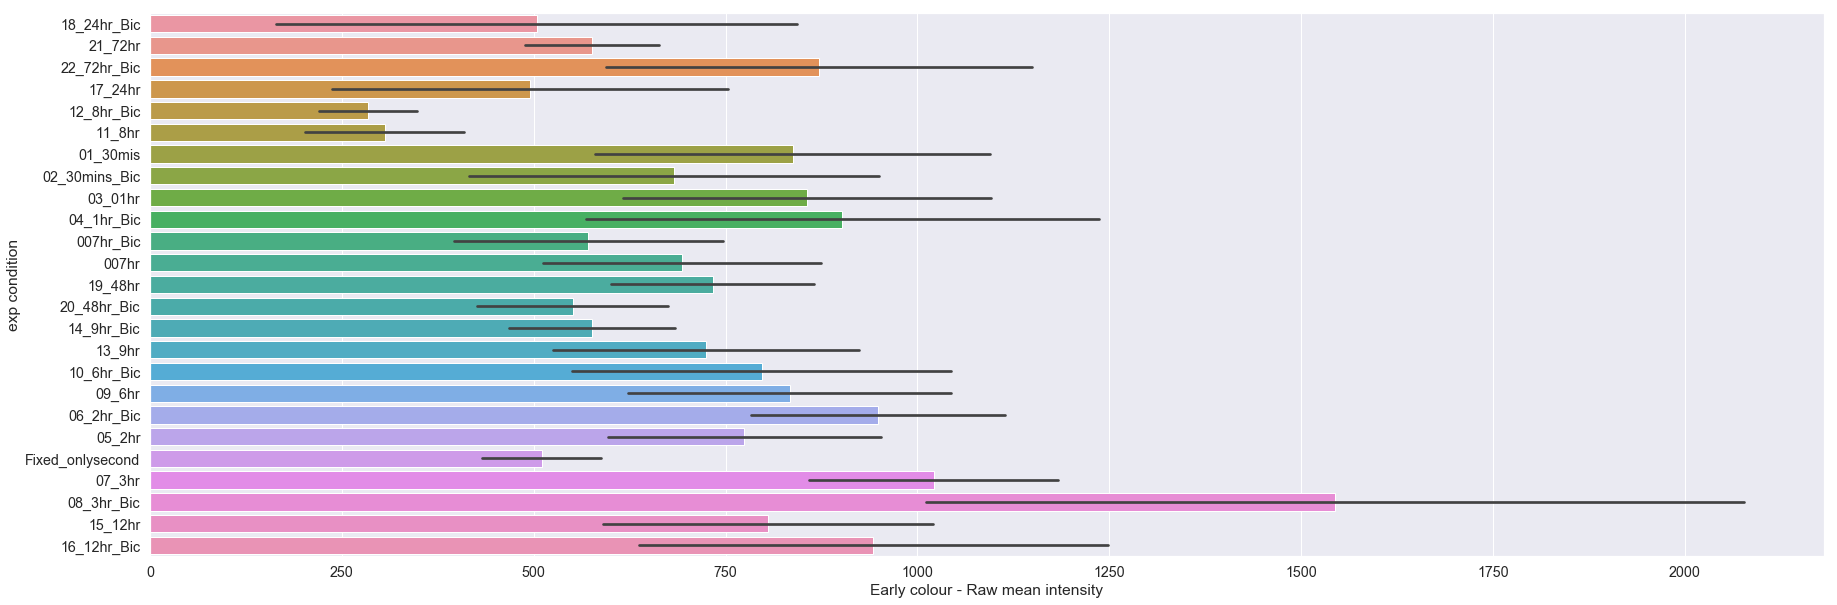

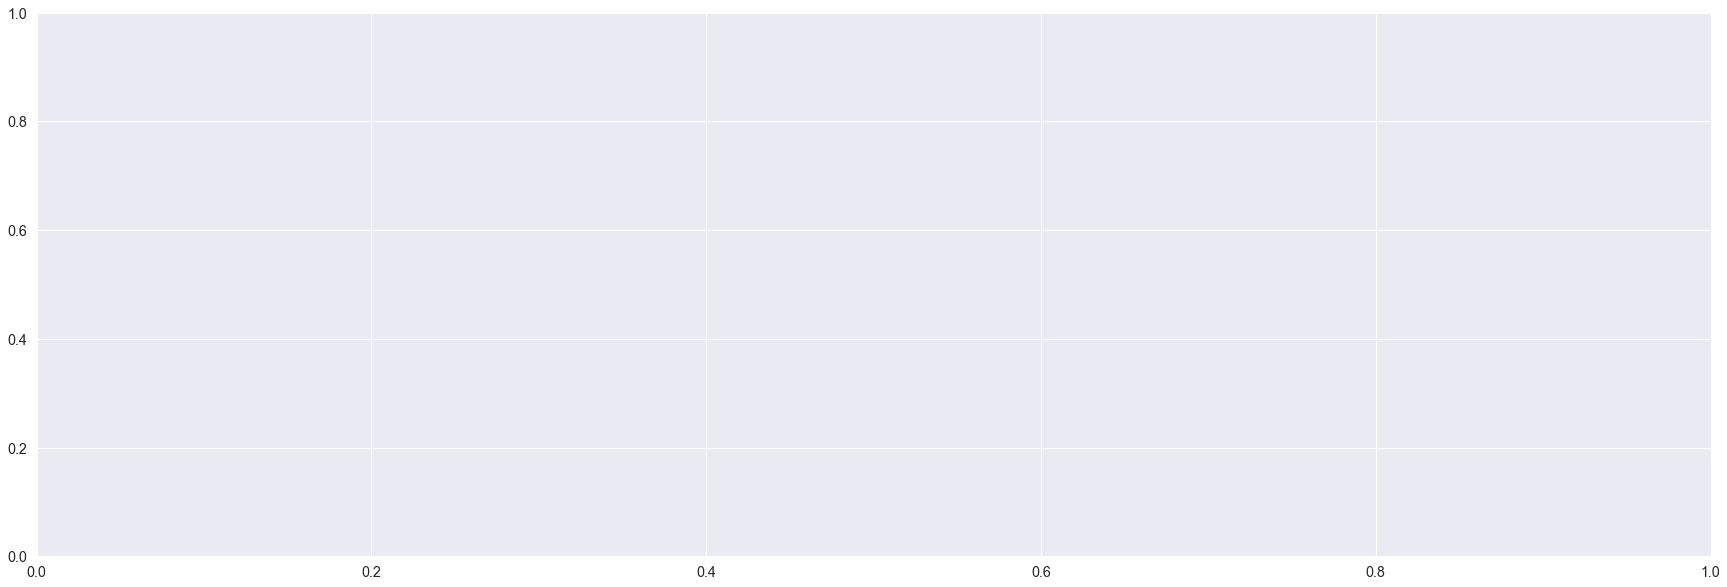

In [77]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
sns.set(font_scale=1.3)

fig1=plt.figure(figsize=(30,10))
d=sns.barplot(x="Early colour - Raw mean intensity", y="exp condition",data=df2,ci='sd')
#d=sns.swarmplot(x="Early colour - Raw mean intensity", y="exp condition",data=df2,color='black')
fig1.savefig(expdir+'/results/plot01_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Early colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram')
fig.savefig(expdir+'/results/plot01_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Early colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot01_hist2.png',bbox_inches='tight')
fig3=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Early colour - Mean intensity of spots', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Mean intensity of spots", y="exp condition",data=df2,color='black')
fig3.savefig(expdir+'/results/plot01_2.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - masked by synapses', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Early colour - masked by synapses", y="exp condition",data=df2.dropna(),color='black')
fig6.savefig(expdir+'/results/plot01_5.png',bbox_inches='tight')
fig5=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - Total no. of spots in FOV', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Total no. of spots in FOV", y="exp condition",data=df2,color='black')
fig5.savefig(expdir+'/results/plot01_3.png',bbox_inches='tight')
fig7=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - Mean spot area [nm]', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Mean spot area [nm]", y="exp condition",data=df2,color='black')
fig7.savefig(expdir+'/results/plot01_4.png',bbox_inches='tight')


fig2=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Raw mean intensity', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Raw mean intensity", y="exp condition",data=df2,color='black')
fig2.savefig(expdir+'/results/plot02_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Late colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram')
fig.savefig(expdir+'/results/plot02_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Late colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot02_hist2.png',bbox_inches='tight')
fig4=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Late colour - Mean intensity of spots', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Mean intensity of spots", y="exp condition",data=df2,color='black')
fig4.savefig(expdir+'/results/plot02_2.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - masked by synapses', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Late colour - masked by synapses", y="exp condition",data=df2.dropna(),color='black')
fig6.savefig(expdir+'/results/plot02_5.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Total no. of spots in FOV', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Total no. of spots in FOV", y="exp condition",data=df2,color='black')
fig6.savefig(expdir+'/results/plot02_3.png',bbox_inches='tight')
fig8=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Mean spot area [nm]', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Mean spot area [nm]", y="exp condition",data=df2,color='black')
fig8.savefig(expdir+'/results/plot02_4.png',bbox_inches='tight')

fig2_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Raw mean intensity', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Raw mean intensity", y="exp condition",data=df2.dropna(),color='black')
fig2_.savefig(expdir+'/results/plot03_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Synapse colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram')
fig.savefig(expdir+'/results/plot03_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Synapse colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot03_hist2.png',bbox_inches='tight')
fig4_=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Synapse colour - Mean intensity of spots', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Mean intensity of spots", y="exp condition",data=df2.dropna(),color='black')
fig4_.savefig(expdir+'/results/plot03_2.png',bbox_inches='tight')
fig6_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Total no. of spots in FOV', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Total no. of spots in FOV", y="exp condition",data=df2.dropna(),color='black')
fig6_.savefig(expdir+'/results/plot03_3.png',bbox_inches='tight')
fig8_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Mean spot area [nm]', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Mean spot area [nm]", y="exp condition",data=df2.dropna(),color='black')
fig8_.savefig(expdir+'/results/plot03_4_.png',bbox_inches='tight')

fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot04.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot04_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot05.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot05_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot06.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot06_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot07.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot07_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot08.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot08_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot09.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot09_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram')
fig.savefig(expdir+'/results/plot10_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot11.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot11_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot12.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot13.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot14.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot15.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')



'''fig10=plt.figure(figsize=(30,10))
Nobic = df2[df2['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df2[df2['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2[df2['exp condition'].isin(['1Day', '2Day'])], ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2[df2['exp condition'].isin(['1Day', '2Day'])],color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')'''

'''Nobic = df2[df2['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df2[df2['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)'''




In [ ]:
#other plots

In [ ]:
df2.columns

In [ ]:
vari='Early colour - Mean intensity of spots Normd to ctrls'
mean_1daybic=np.mean(df2[df2['exp condition']==onedaybiclabel][vari])
mean_1day=np.mean(df2[df2['exp condition']==onedaylabel][vari])
mean_1hourbic=np.mean(df2[df2['exp condition']==onehourbiclabel][vari])
mean_1hour=np.mean(df2[df2['exp condition']==onehourlabel][vari])
mean_7hourbic=np.mean(df2[df2['exp condition']==sevenhourbiclabel][vari])
mean_7hour=np.mean(df2[df2['exp condition']==sevenhourlabel][vari])
mean30minbic=np.mean(df2[df2['exp condition']==thirtyminsbiclabel][vari])
mean_30min=np.mean(df2[df2['exp condition']==thirtyminslabel][vari])
#mean_2hourbic=np.mean(df2[df2['exp condition']==twohourbiclabel][vari])
#mean_2hour=np.mean(df2[df2['exp condition']==twohourlabel][vari])
mean_6hourbic=np.mean(df2[df2['exp condition']==sixhourbiclabel][vari])
mean_6hour=np.mean(df2[df2['exp condition']==sixhourlabel][vari])
mean_9hourbic=np.mean(df2[df2['exp condition']==ninehourbiclabel][vari])
mean_9hour=np.mean(df2[df2['exp condition']==ninehourlabel][vari])
mean_3hourbic=np.mean(df2[df2['exp condition']==threehourbiclabel][vari])
mean_3hour=np.mean(df2[df2['exp condition']==threehourlabel][vari])
mean_12hourbic=np.mean(df2[df2['exp condition']==twelvehourbiclabel][vari])
mean_12hour=np.mean(df2[df2['exp condition']==twelvehourlabel][vari])
mean_8hourbic=np.mean(df2[df2['exp condition']==eighthourbiclabel][vari])
mean_8hour=np.mean(df2[df2['exp condition']==eighthourlabel][vari])
mean_48hourbic=np.mean(df2[df2['exp condition']==twodaybiclabel][vari])
mean_48hour=np.mean(df2[df2['exp condition']==twodaylabel][vari])
mean_72hourbic=np.mean(df2[df2['exp condition']==threedaybiclabel][vari])
mean_72hour=np.mean(df2[df2['exp condition']==threedaylabel][vari])


ratiohalfhour=mean30minbic/mean_30min
ratio1hr=mean_1hourbic/mean_1hour
#ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_1daybic/mean_1day
ratio48hr=mean_48hourbic/mean_48hour
ratio72hr=mean_72hourbic/mean_72hour

mean_1day

In [ ]:
y=[ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr]
x=np.arange(1,len(y)+1)
labels=['30mins','1','2','3','6','7','8','9','12','24']
plt.bar(x,height=np.log(y))
plt.xticks(x,labels)
plt.title('Bic induced shift of late colour bias')

In [79]:
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('30'), 'Time'] = '30mins'
df2.loc[df2['exp condition'].str.contains('1hr'), 'Time'] = '1hr'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hr'
df2.loc[df2['exp condition'].str.contains('3hr'), 'Time'] = '3hr'
df2.loc[df2['exp condition'].str.contains('6hr'), 'Time'] = '6hr'
df2.loc[df2['exp condition'].str.contains('7hr'), 'Time'] = '7hr'
df2.loc[df2['exp condition'].str.contains('8hr'), 'Time'] = '8hr'
df2.loc[df2['exp condition'].str.contains('9hr'), 'Time'] = '9hr'
df2.loc[df2['exp condition'].str.contains('12hr'), 'Time'] = '12hr'
df2.loc[df2['exp condition'].str.contains('24hr'), 'Time'] = '24hr'

In [ ]:
df2regionprops['Time']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('30'), 'Time'] = '30mins'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('1hr'), 'Time'] = '1hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('2hr'), 'Time'] = '2hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('3hr'), 'Time'] = '3hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('6hr'), 'Time'] = '6hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('7hr'), 'Time'] = '7hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('8hr'), 'Time'] = '8hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('9hr'), 'Time'] = '9hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('12hr'), 'Time'] = '12hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('24hr'), 'Time'] = '24hr'
df2regionprops['Timeframe']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('30'), 'Timeframe'] = np.nan
df2regionprops.loc[df2regionprops['exp condition'].str.contains('1hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('2hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('3hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('6hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('7hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('8hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('9hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('12hr'), 'Timeframe'] = '12hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('24hr'), 'Timeframe'] = '24hrs'

In [80]:
df2['Timeframe']='None'
df2.loc[df2['exp condition'].str.contains('30'), 'Timeframe'] = np.nan
df2.loc[df2['exp condition'].str.contains('1hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('3hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('6hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('7hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('8hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('9hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('12hr'), 'Timeframe'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('24hr'), 'Timeframe'] = '24hrs'

In [81]:
df2['Drug']='None'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'

In [ ]:
df2regionprops['Drug']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'

In [ ]:
df2.columns

In [ ]:
len(df2[(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")])

In [ ]:
vari="Late colour - Raw mean intensity"

'''mean30minbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="30mins")].mean()
n30minbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="30mins")])
mean30min=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="30mins")].mean()
n30min=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="30mins")])

mean_1hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="1hr")].mean()
n1hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="1hr")])
mean_1hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="1hr")].mean()
n1hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="1hr")])

mean_2hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="2hr")].mean()
n2hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="2hr")])
mean_2hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="2hr")].mean()
n2hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="2hr")])

mean_3hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")].mean()
n3hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")])
mean_3hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="3hr")].mean()
n3hr=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")])

mean_6hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="6hr")].mean()
n6hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="6hr")])
mean_6hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="6hr")].mean()
n6hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="6hr")])

mean_7hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="7hr")].mean()
n7hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="7hr")])
mean_7hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="7hr")].mean()
n7hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="7hr")])

mean_8hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="8hr")].mean()
n8hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="8hr")])
mean_8hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="8hr")].mean()
n8hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="8hr")])

mean_9hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="9hr")].mean()
n9hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="9hr")])
mean_9hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="9hr")].mean()
n9hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="9hr")])

mean_12hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="12hr")].mean()
n12hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="12hr")])
mean_12hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="12hr")].mean()
n12hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="12hr")])

mean_24hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="24hr")].mean()
n24hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="24hr")])
mean_24hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="24hr")].mean()
n24hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="24hr")])'''

mean1to3bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="1-3hrs")].mean()
n1to3bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="1-3hrs")])
mean1to3=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="1-3hrs")].mean()
n1to3=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="1-3hrs")])
mean6to9bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="6-9hrs")].mean()
n6to9bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="6-9hrs")])
mean6to9=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="6-9hrs")].mean()
n6to9=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="6-9hrs")])
mean12bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="12hrs")].mean()
n12bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="12hrs")])
mean12=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="12hrs")].mean()
n12=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="12hrs")])
mean24bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="24hrs")].mean()
n24bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="24hrs")])
mean24=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")].mean()
n24=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")])
ratio1to3=mean1to3bic/mean1to3
ratio6to9=mean6to9bic/mean6to9
#ratio12=mean12bic/mean12
ratio24=mean24bic/mean24



diff30=mean30minbic-mean30min
diff1=mean_1hourbic-mean_1hour
diff2=mean_2hourbic-mean_2hour
diff3=mean_3hourbic-mean_3hour
diff6=mean_6hourbic-mean_6hour
diff7=mean_7hourbic-mean_7hour
diff8=mean_8hourbic-mean_8hour
diff9=mean_9hourbic-mean_9hour
diff12=mean_12hourbic-mean_12hour
diff24=mean_24hourbic-mean_24hour

'''ratiohalfhour=mean30minbic/mean30min
ratio1hr=mean_1hourbic/mean_1hour
#ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_24hourbic/mean_24hour'''

twofoldchange_halfhour=np.log2(mean30minbic)-np.log2(mean30min)
twofoldchange_1hr=np.log2(mean_1hourbic)-np.log2(mean_1hour)
twofoldchange_2hr=np.log2(mean_2hourbic)-np.log2(mean_2hour)
twofoldchange_3hr=np.log2(mean_3hourbic)-np.log2(mean_3hour)
twofoldchange_6hr=np.log2(mean_6hourbic)-np.log2(mean_6hour)
twofoldchange_7hr=np.log2(mean_7hourbic)-np.log2(mean_7hour)
twofoldchange_8hr=np.log2(mean_8hourbic)-np.log2(mean_8hour)
twofoldchange_9hr=np.log2(mean_9hourbic)-np.log2(mean_9hour)
twofoldchange_12hr=np.log2(mean_12hourbic)-np.log2(mean_12hour)
twofoldchange_24hr=np.log2(mean_24hourbic)-np.log2(mean_24hour)


#ns=[n1hr+n1hrbic,n2hr+n2hrbic,n3hr+n3hrbic,n6hr+n6hrbic,n7hr+n7hrbic,n8hr+n8hrbic,n9hr+n9hrbic,n12hr+n12hrbic,n24hr+n24hrbic]
ns=[n1to3bic+n1to3,n6to9bic+n6to9,n24+n24bic]

print(ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,mean_2hour,mean_3hourbic,mean_3hour,mean_6hourbic,mean_6hour,
     mean_7hourbic,mean_7hour,mean_8hourbic,mean_8hour,mean_9hourbic,mean_9hour,mean_12hourbic,mean_12hour,
     mean_24hourbic,mean_24hour)

print(twofoldchange_halfhour,twofoldchange_1hr,twofoldchange_2hr,twofoldchange_3hr,twofoldchange_6hr,
     twofoldchange_7hr,twofoldchange_8hr,twofoldchange_9hr,twofoldchange_12hr,twofoldchange_24hr)

In [ ]:
y1 = np.log2([ratio1to3,ratio6to9,ratio12hr,ratio24hr])
print(y1)

In [ ]:
sns.set(style="white", context="talk")
# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(9, 5))

# Generate some sequential data
y2 = np.log2([ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr])
#labels=['1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
labels=['1-3hrs','6-9hrs','24hrs']
y1 = ([twofoldchange_1hr,twofoldchange_2hr,twofoldchange_3hr,twofoldchange_6hr,
     twofoldchange_7hr,twofoldchange_8hr,twofoldchange_9hr,twofoldchange_24hr])
y1=([diff1,diff2,diff3,diff6,diff7,diff8,diff9,diff12,diff24])
y3 = np.log2([ratio1to3,ratio6to9,ratio24])


x1 = np.array(labels)
sns.barplot(x=x1, y=y3, palette="GnBu_d", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("log(Bic/Ctrl)")
plt.xticks(rotation=45)
ax1.set_title('Bic-induced change in '+vari)
ax1.set_ylim(top=np.max(y3)+0.2,bottom=np.min(y3)-0.2)
#ax1.set_xlim(left=0,right=5)
ax2=plt.bar(x=np.arange(0,len(y3)),height=y3,visible=False)
counter=0
for i in ax2:
    samples=ns[counter]
    counter=counter+1
    height=i.get_height()
    print(height)
    ax1.text(i.get_x() + i.get_width()/2.0, height+np.sign(height)*0.05, str(samples), ha='center',va='bottom',
             fontsize=15,fontstyle='italic')

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [ ]:
df2.columns

In [82]:
def expname(x):
    return("/".join(x.split("/")[:-2]))


In [193]:
df2[df2["Timeframe"]=="24hrs"]["exp_id"].iloc[400]

IndexError: single positional indexer is out-of-bounds

In [84]:
df2["expdate"]=df2.apply(lambda row: expname(row["filename"]),axis=1)

In [199]:
df2["expid"].unique()

array(['20180220', '20180511', '20180710_TP', '20180710_TP2', '20180501',
       '20180602_TP', '20180214', '20180620_TP', '20180705_TP',
       '20180426'], dtype=object)

In [ ]:
df2=df2.append({'Timeframe':'Total','Early colour - Mean intensity Normd to ctrls':1.,'Late colour - Mean intensity Normd to ctrls':1.,'Drug':'Bic'},ignore_index=True)

In [200]:
df2['Early colour - Mean intensity of spots norm2max'] = df2["Early colour - Mean intensity of spots"]/df2.groupby(["expid"])["Early colour - Mean intensity of spots"].transform('max')
df2['Late colour - Mean intensity of spots norm2max'] = df2["Late colour - Mean intensity of spots"]/df2.groupby(["expid"])["Late colour - Mean intensity of spots"].transform('max')



In [201]:
df2[df2["Late colour - Mean intensity Normd to ctrls"]>1].iloc[100]["Latecontroldir"]

KeyError: 'Late colour - Mean intensity Normd to ctrls'

In [85]:

df2.loc[df2['expdate'].str.contains("20180220_Turnover_Bic_TNR_nb580first_nb653psecond_use"), 'expid'] = "20180220"
df2.loc[df2['expdate'].str.contains("20180511_Turnover_Bic_nb580first_635psecond_use/TNR"), 'expid'] = "20180511"
df2.loc[df2['expdate'].str.contains("20180710_Turnover_Bic_Timepoints_TNR_nb_use/635first_580second"), 'expid'] = "20180710_TP"
df2.loc[df2['expdate'].str.contains("20180710_Turnover_Bic_Timepoints_TNR_nb_use/580first_635second"), 'expid'] = "20180710_TP2"
df2.loc[df2['expdate'].str.contains("20180501_Turnover_3colours_Bic_TTX_nb580first_635second_use/TNR"), 'expid'] = "20180501"
df2.loc[df2['expdate'].str.contains("20180602_Turnover_Bic_Timepoints_nb635first_580second_use"), 'expid'] = "20180602_TP"
df2.loc[df2['expdate'].str.contains("20180214_Turnover_Bic_TNR_nb580first_nb653psecond_use"), 'expid'] = "20180214"
df2.loc[df2['expdate'].str.contains("20180620_Turnover_Bic_TNR_Timepoints_nb635first_580second_use"), 'expid'] = "20180620_TP"
df2.loc[df2['expdate'].str.contains("20180705_Turnover_Bic_TNR_Timepoints_nb580first_635second_use"), 'expid'] = "20180705_TP"
df2.loc[df2['expdate'].str.contains("20180426_Turnover_TNR_Bic_TTX_nb635first_580second_use"), 'expid'] = "20180426"










In [202]:
df2.columns

Index(['Autofluorescencedir', 'Early colour - Mean intensity of spots',
       'Early colour - Mean intensity of spots Normd to early ctrl',
       'Early colour - Mean intensity of spots Normd to early ctrl - masked by synapses',
       'Early colour - Mean intensity of spots only under synapses',
       'Early colour - Mean spot area [nm]',
       'Early colour - Raw mean intensity',
       'Early colour - Total no. of spots in FOV', 'Early colour - spots mask',
       'Early colour spots normd to early ctrl, corr to Synapse spots',
       'Earlycontroldir', 'Late colour - Mean intensity of spots',
       'Late colour - Mean intensity of spots Normd to late ctrl',
       'Late colour - Mean intensity of spots Normd to late ctrl - masked by synapses',
       'Late colour - Mean intensity of spots only under synapses',
       'Late colour - Mean spot area [nm]', 'Late colour - Raw mean intensity',
       'Late colour - Total no. of spots in FOV', 'Late colour - spots mask',
       'Lat

'd=sns.pointplot(y=vari, x=\'Timeframe\',data=df3[df3["Drug"]=="None"],hue=\'expid\',\n                 ci=None,\n                 order=orderlab)'

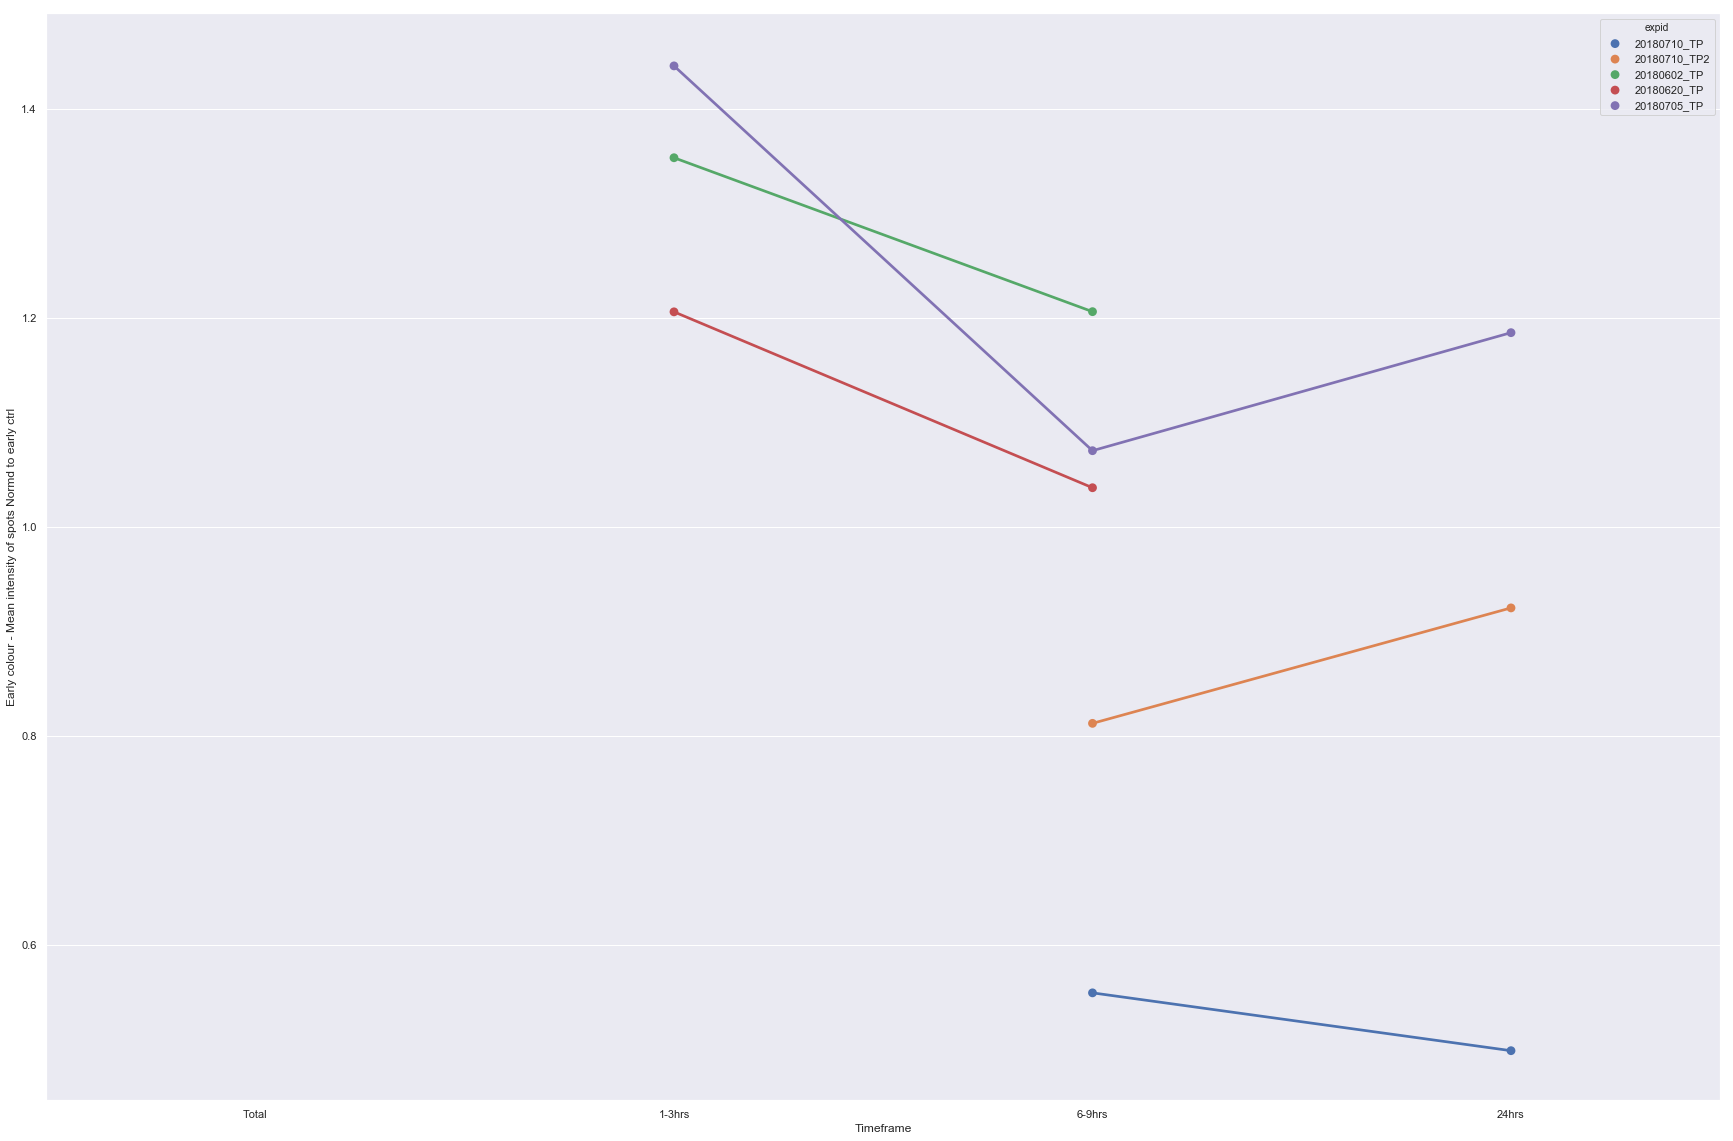

In [205]:
vari="Early colour - Mean intensity of spots Normd to early ctrl"
#vari2="Mean colour bias of a pixel (early=-1<x<1=late) - under late+early spots"


sns.set(font_scale=1)


#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['Total','1-3hrs','6-9hrs','24hrs']
orderlabfull=['1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
fig10=plt.figure(figsize=(30,20))#

#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y=vari, x='Timeframe',data=df3,hue='expid',
                 ci=None,
                 order=orderlab)
'''d=sns.pointplot(y=vari, x='Timeframe',data=df3[df3["Drug"]=="None"],hue='expid',
                 ci=None,
                 order=orderlab)'''


In [ ]:
df2.columns

<Container object of 3 artists>

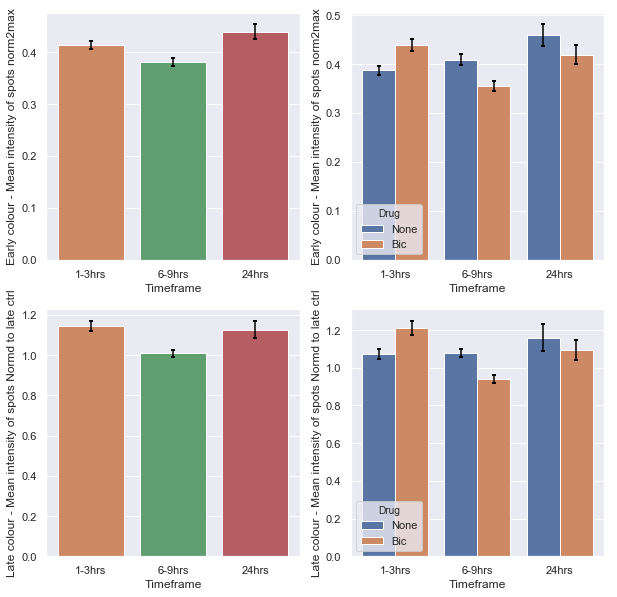

In [149]:
df3=df2[df2["expdate"].str.contains("Timepoints")]

vari="Early colour - Mean intensity of spots norm2max"

vari2="Late colour - Mean intensity of spots Normd to late ctrl"

sns.set(font_scale=1)

early1to3=df3[df3["Timeframe"]=="1-3hrs"][vari]
late1to3=df3[df3["Timeframe"]=="1-3hrs"][vari2]
early6to9=df3[df3["Timeframe"]=="6-9hrs"][vari]
late6to9=df3[df3["Timeframe"]=="6-9hrs"][vari2]
early24=df3[df3["Timeframe"]=="24hrs"][vari]
late24=df3[df3["Timeframe"]=="24hrs"][vari2]

earlyBic1to3=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="1-3hrs")][vari]
earlyNoBic1to3=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="1-3hrs")][vari]
lateBic1to3=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="1-3hrs")][vari2]
lateNoBic1to3=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="1-3hrs")][vari2]
earlyBic6to9=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="6-9hrs")][vari]
earlyNoBic6to9=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="6-9hrs")][vari]
lateBic6to9=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="6-9hrs")][vari2]
lateNoBic6to9=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="6-9hrs")][vari2]
earlyBic24=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="24hrs")][vari]
earlyNoBic24=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="24hrs")][vari]
lateBic24=df3[(df3["Drug"]=="Bic")&(df3["Timeframe"]=="24hrs")][vari2]
lateNoBic24=df3[(df3["Drug"]=="None")&(df3["Timeframe"]=="24hrs")][vari2]
#all
#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['Total','1-3hrs','6-9hrs','24hrs']
orderlabfull=['1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(10,10))#
fig10.add_subplot(221)
d=sns.barplot(y=vari, x='Timeframe',data=df3,ci=None,
                 order=orderlab)
plt.errorbar(x=[1,2,3],
             y=[early1to3.mean(),early6to9.mean(),early24.mean()],
             yerr=[early1to3.sem(),early6to9.sem(),early24.sem()],xerr=None,ecolor='black',fmt='none',capsize=2,capthick=2)

fig10.add_subplot(223)
d=sns.barplot(y=vari2, x='Timeframe',data=df3,ci=None,
                 order=orderlab)
plt.errorbar(x=[1,2,3],
             y=[late1to3.mean(),late6to9.mean(),late24.mean()],
             yerr=[late1to3.sem(),late6to9.sem(),late24.sem()],xerr=None,ecolor='black',fmt='none',capsize=2,capthick=2)

fig10.add_subplot(222)
d=sns.barplot(y=vari, x='Timeframe',data=df3,hue="Drug",hue_order=["None","Bic"],ci=None,
                 order=orderlab)
plt.errorbar(x=[.8,1.2,1.8,2.2,2.8,3.2],
             y=[earlyNoBic1to3.mean(),earlyBic1to3.mean(),earlyNoBic6to9.mean(),earlyBic6to9.mean(),earlyNoBic24.mean(),earlyBic24.mean()],
             yerr=[earlyNoBic1to3.sem(),earlyBic1to3.sem(),earlyNoBic6to9.sem(),earlyBic6to9.sem(),earlyNoBic24.sem(),earlyBic24.sem()],
             xerr=None,ecolor='black',fmt='none',capsize=2,capthick=2)

fig10.add_subplot(224)
d=sns.barplot(y=vari2, x='Timeframe',data=df3,hue="Drug",hue_order=["None","Bic"],ci=None,
                 order=orderlab)
plt.errorbar(x=[.8,1.2,1.8,2.2,2.8,3.2],
             y=[lateNoBic1to3.mean(),lateBic1to3.mean(),lateNoBic6to9.mean(),lateBic6to9.mean(),lateNoBic24.mean(),lateBic24.mean()],
             yerr=[lateNoBic1to3.sem(),lateBic1to3.sem(),lateNoBic6to9.sem(),lateBic6to9.sem(),lateNoBic24.sem(),lateBic24.sem()],
             xerr=None,ecolor='black',fmt='none',capsize=2,capthick=2)



<Container object of 3 artists>

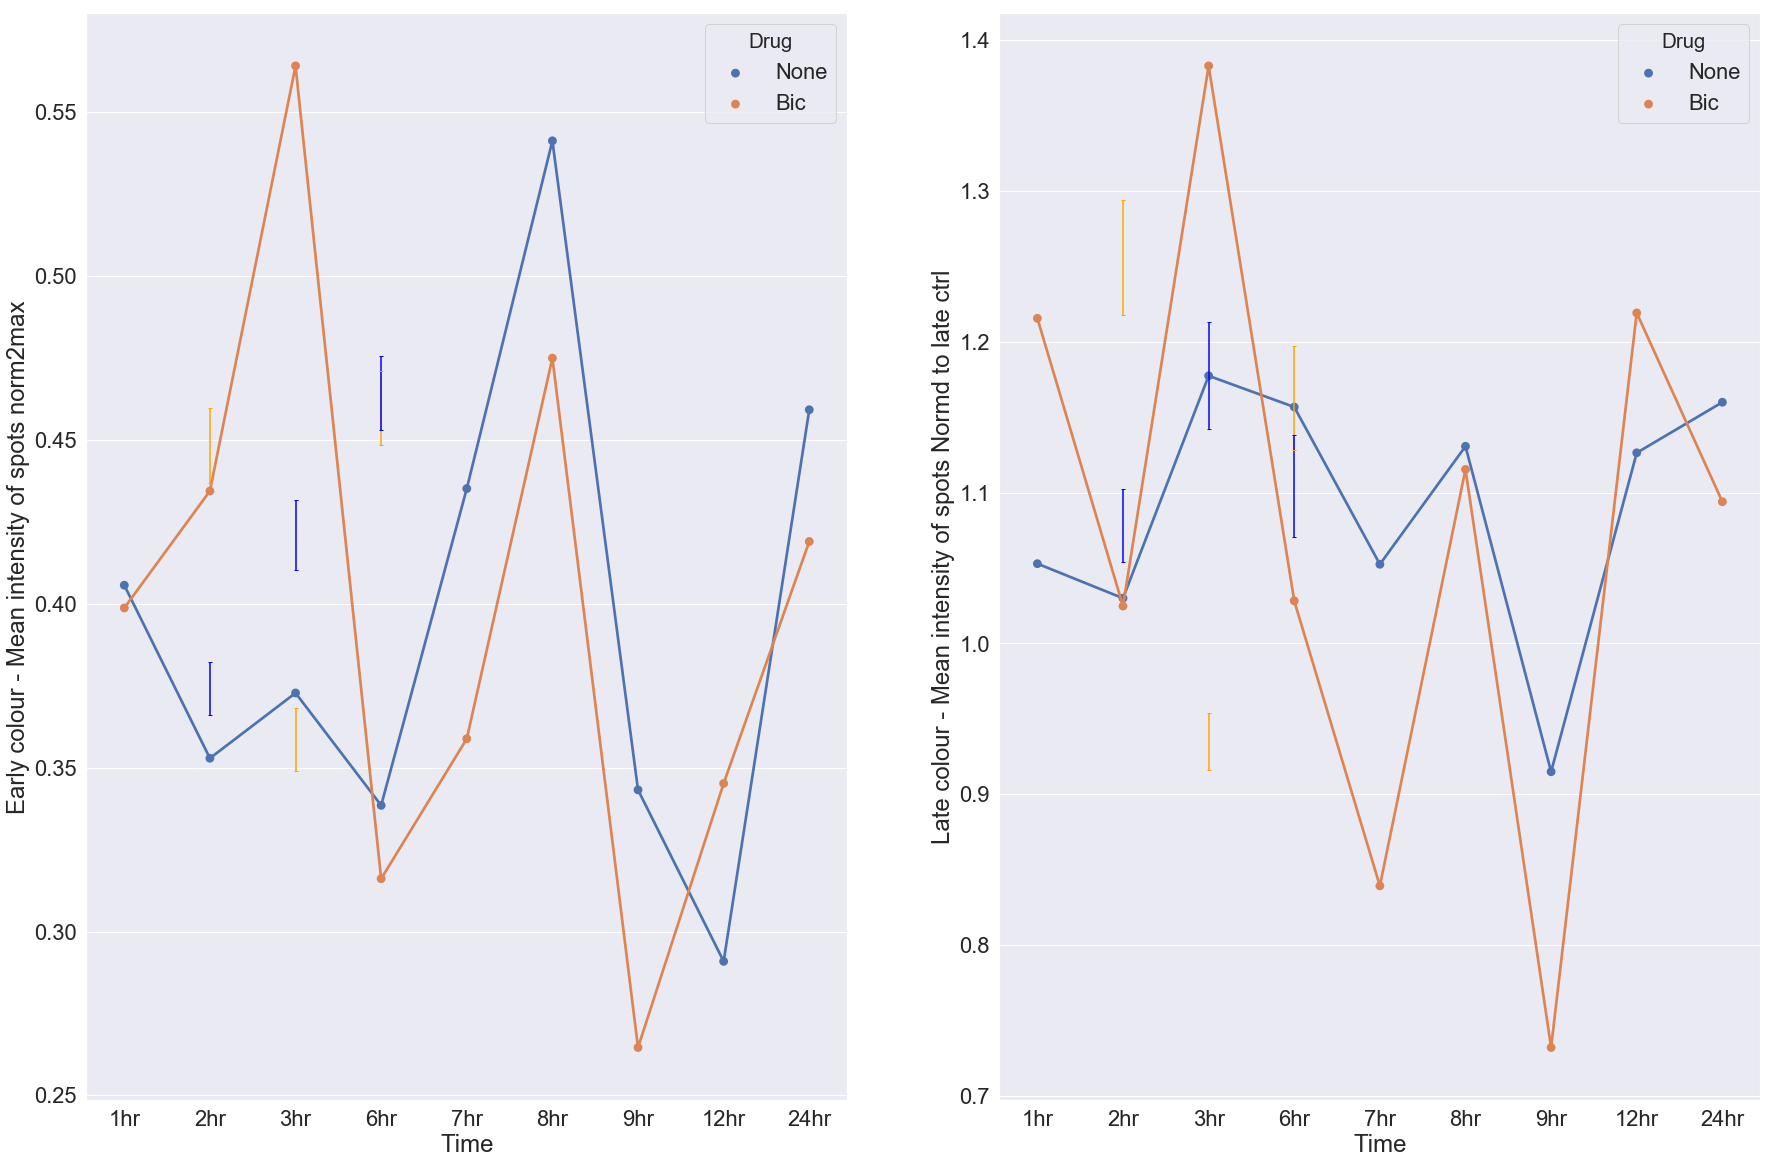

In [150]:
#vari="Early colour - Mean intensity of spots Normd to ctrls"

#vari2="Late colour - Mean intensity of spots Normd to ctrls"


sns.set(font_scale=2)


#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['Total','1-3hrs','6-9hrs','24hrs']
orderlab=['1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
fig10=plt.figure(figsize=(30,20))#
fig10.add_subplot(121)
d=sns.pointplot(y=vari, x='Time',data=df2[df2["expdate"].str.contains("Timepoints")],hue='Drug',
                 hue_order=['None','Bic'],ci=None,
                 split=True,order=orderlab,legend_out=True)

NoBic0=1
Bic0=1
Bic1to3=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="1-3hrs")][vari]
NoBic1to3=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="1-3hrs")][vari]
Bic6to9=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="6-9hrs")][vari]
NoBic6to9=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="6-9hrs")][vari]
#Bic12=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="12hrs")][vari]
#NoBic12=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="12hrs")][vari]
Bic24=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="24hrs")][vari]
NoBic24=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="24hrs")][vari]

yerrorsbic=[Bic1to3.sem(),Bic6to9.sem(),Bic24.sem()]
yerrorsnobic=[NoBic1to3.sem(),NoBic6to9.sem(),NoBic24.sem()]

plt.errorbar(x=[1,2,3],
             y=[Bic1to3.mean(),Bic6to9.mean(),Bic24.mean()],
             yerr=yerrorsbic,xerr=None,ecolor='orange',fmt='none',capsize=2)
plt.errorbar(x=[1,2,3],
             y=[NoBic1to3.mean(),NoBic6to9.mean(),NoBic24.mean()],
             yerr=yerrorsnobic,xerr=None,ecolor='blue',fmt='none',capsize=2)

fig10.add_subplot(122)
d=sns.pointplot(y=vari2, x='Time',data=df2[df2["expdate"].str.contains("Timepoints")],hue='Drug',
                 hue_order=['None','Bic'],ci=None,
                 split=True,order=orderlab,legend_out=True,row="expdate")

NoBic0=1
Bic0=1
aBic1to3=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="1-3hrs")][vari2]
aNoBic1to3=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="1-3hrs")][vari2]
aBic6to9=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="6-9hrs")][vari2]
aNoBic6to9=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="6-9hrs")][vari2]
aBic12=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="12hrs")][vari]
aNoBic12=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="12hrs")][vari]
aBic24=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="24hrs")][vari2]
aNoBic24=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="24hrs")][vari2]

yerrorsbic=[aBic1to3.sem(),aBic6to9.sem(),aBic24.sem()]
yerrorsnobic=[aNoBic1to3.sem(),aNoBic6to9.sem(),aNoBic24.sem()]

plt.errorbar(x=[1,2,3],
             y=[aBic1to3.mean(),aBic6to9.mean(),aBic24.mean()],
             yerr=yerrorsbic,xerr=None,ecolor='orange',fmt='none',capsize=2)
plt.errorbar(x=[1,2,3],
             y=[aNoBic1to3.mean(),aNoBic6to9.mean(),aNoBic24.mean()],
             yerr=yerrorsnobic,xerr=None,ecolor='blue',fmt='none',capsize=2)

In [ ]:
df2[df2["Timeframe"]=="24hrs"]["Earlycontroldir"][0]

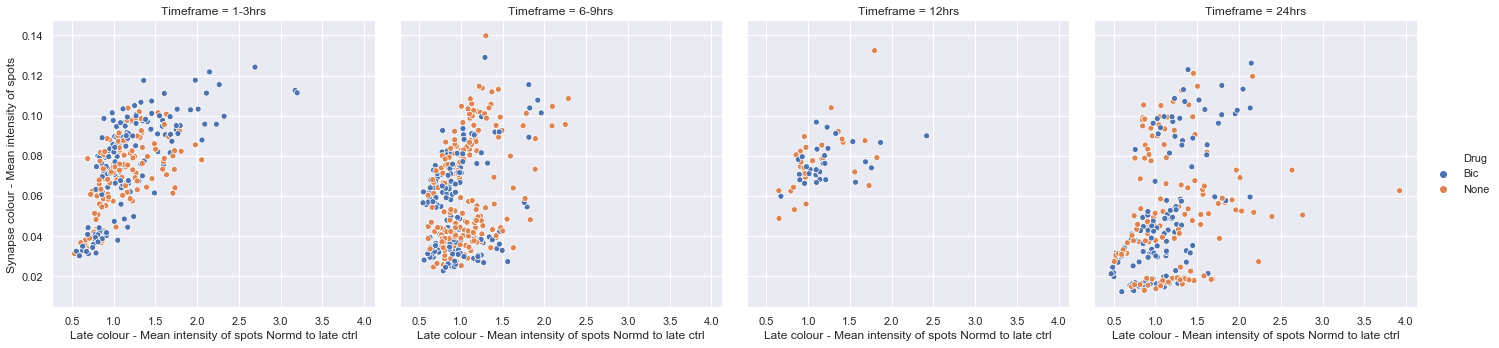

In [114]:
vari1="Late colour - Mean intensity of spots Normd to late ctrl"
vari2="Synapse colour - Mean intensity of spots"

sns.set(font_scale=1)


#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['1-3hrs','6-9hrs','12hrs','24hrs']
plt.figure(figsize=(60,30)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.relplot(x=vari1, y=vari2,col="Timeframe",data=df2,
                  hue='Drug',col_order=orderlab)



In [125]:
sns.set(font_scale=1)
varib="Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df2[df2["Timeframe"]=="24hrs"],ci=90,)
Nobic = df2[(df2["Timeframe"]=="24hrs") & (df2["Drug"]=="None")][varib]
Bic = df2[(df2["Timeframe"]=="24hrs") & (df2["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df2[df2["Timeframe"]=="24hrs"][varib].mean() + 0.15, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)



ValueError: Could not interpret input 'Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls'

In [ ]:
sns.set(font_scale=2)


orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(30,10)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y='Late colour - Raw mean intensity', x='Time',data=df2,hue='Drug',
                 order=orderlab,hue_order=['None','Bic'],
                 split=True)
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')

In [ ]:
sns.set(font_scale=2)


orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(30,10)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y='Late colour - Mean intensity of spots', x='Time',data=df2,hue='Drug',
                 order=orderlab,hue_order=['None','Bic'],
                 split=True)
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')

In [ ]:
mean_1daybic=np.mean(df2[df2['exp condition']==onedaybiclabel]['Late colour - Mean intensity of spots'])
mean_1day=np.mean(df2[df2['exp condition']==onedaylabel]['Late colour - Mean intensity of spots'])
mean_1hourbic=np.mean(df2[df2['exp condition']==onehourbiclabel]['Late colour - Mean intensity of spots'])
mean_1hour=np.mean(df2[df2['exp condition']==onehourlabel]['Late colour - Mean intensity of spots'])
mean_7hourbic=np.mean(df2[df2['exp condition']==sevenhourbiclabel]['Late colour - Mean intensity of spots'])
mean_7hour=np.mean(df2[df2['exp condition']==sevenhourlabel]['Late colour - Mean intensity of spots'])
mean30minbic=np.mean(df2[df2['exp condition']==thirtyminsbiclabel]['Late colour - Mean intensity of spots'])
mean_30min=np.mean(df2[df2['exp condition']==thirtyminslabel]['Late colour - Mean intensity of spots'])
mean_2hourbic=np.mean(df2[df2['exp condition']==twohourbiclabel]['Late colour - Mean intensity of spots'])
mean_2hour=np.mean(df2[df2['exp condition']==twohourlabel]['Late colour - Mean intensity of spots'])
mean_6hourbic=np.mean(df2[df2['exp condition']==sixhourbiclabel]['Late colour - Mean intensity of spots'])
mean_6hour=np.mean(df2[df2['exp condition']==sixhourlabel]['Late colour - Mean intensity of spots'])
mean_9hourbic=np.mean(df2[df2['exp condition']==ninehourbiclabel]['Late colour - Mean intensity of spots'])
mean_9hour=np.mean(df2[df2['exp condition']==ninehourlabel]['Late colour - Mean intensity of spots'])
mean_3hourbic=np.mean(df2[df2['exp condition']==threehourbiclabel]['Late colour - Mean intensity of spots'])
mean_3hour=np.mean(df2[df2['exp condition']==threehourlabel]['Late colour - Mean intensity of spots'])
mean_12hourbic=np.mean(df2[df2['exp condition']==twelvehourbiclabel]['Late colour - Mean intensity of spots'])
mean_12hour=np.mean(df2[df2['exp condition']==twelvehourlabel]['Late colour - Mean intensity of spots'])
mean_8hourbic=np.mean(df2[df2['exp condition']==eighthourbiclabel]['Late colour - Mean intensity of spots'])
mean_8hour=np.mean(df2[df2['exp condition']==eighthourlabel]['Late colour - Mean intensity of spots'])
mean_48hourbic=np.mean(df2[df2['exp condition']==twodaybiclabel]['Late colour - Mean intensity of spots'])
mean_48hour=np.mean(df2[df2['exp condition']==twodaylabel]['Late colour - Mean intensity of spots'])
mean_72hourbic=np.mean(df2[df2['exp condition']==threedaybiclabel]['Late colour - Mean intensity of spots'])
mean_72hour=np.mean(df2[df2['exp condition']==threedaylabel]['Late colour - Mean intensity of spots'])


ratiohalfhour=mean30minbic/mean_30min
ratio1hr=mean_1hourbic/mean_1hour
ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_1daybic/mean_1day
ratio48hr=mean_48hourbic/mean_48hour
ratio72hr=mean_72hourbic/mean_72hour

y=[ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr]
x=np.arange(1,len(x)+1)
labels=['30mins','1','2','3','6','7','8','9','12','24']
plt.bar(x,height=np.log10(y))
plt.xticks(x,labels)
plt.title('Bic induced shift of Late colour bias')

In [ ]:
props=df2regionprops["Early colour - regionprops"].iloc[0]

In [ ]:
df3regionprops.columns

In [ ]:
df3regionprops=deepcopy(df2regionprops)

In [ ]:
for j in range(0,len(props)):
    print(props[j].perimeter)

In [ ]:
df3regionprops['Eccentricity early']=[list() for x in range(len(df3regionprops.index))]
df3regionprops['Eccentricity late']=[list() for x in range(len(df3regionprops.index))]
df3regionprops['Eccentricity early plus late']=[list() for x in range(len(df3regionprops.index))]

In [ ]:
for i in range(0,len(df3regionprops)):
    #empty vecs
    
    props_early=df3regionprops["Early colour - regionprops"].iloc[i]
    props_early_perim=np.zeros((len(props_early),1))
    for j in range(0,len(props_early)):
        props_early_perim[j]=props_early[j].perimeter
    df3regionprops['Perimeter early'].iloc[i]=props_early_perim
    
    props_late=df3regionprops["Late colour - regionprops"].iloc[i]
    props_late_perim=np.zeros((len(props_late),1))
    for j in range(0,len(props_late)):
        props_late_perim[j]=props_late[j].perimeter
    df3regionprops['Perimeter late'].iloc[i]=props_late_perim
    
    props_earlylate=df3regionprops["Late + early colour combined - regionprops"].iloc[i]
    props_earlylate_perim=np.zeros((len(props_earlylate),1))
    for j in range(0,len(props_earlylate)):
        props_earlylate_perim[j]=props_earlylate[j].perimeter
    df3regionprops['Perimeter early plus late'].iloc[i]=props_earlylate_perim

### Regionprops plots

In [ ]:
df3regionprops['Eccentricity early plus late mean']=np.nan

In [ ]:
for i in range(0,len(df3regionprops)):
    
    df3regionprops['Perimeter early plus late mean'].iloc[i]=df3regionprops["Perimeter early plus late"].iloc[i].mean()

In [ ]:
sns.set(font_scale=1)
varib1=df3regionprops["Perimeter early mean"].values.tolist()
varib2=df3regionprops["Perimeter early plus late mean"].values.tolist()

sns.kdeplot(varib1, shade=True, cut=0, label="early")
sns.kdeplot(varib2, shade=True, cut=0,label="early+late")



In [ ]:
sns.set(font_scale=1)
varib="Perimeter early mean"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df3regionprops,hue="Timeframe",ci=90,)
Nobic = df3regionprops[(df3regionprops["Timeframe"]=="24hrs") & (df3regionprops["Drug"]=="None")][varib]
Bic = df3regionprops[(df3regionprops["Timeframe"]=="24hrs") & (df3regionprops["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df3regionprops[df3regionprops["Timeframe"]=="24hrs"][varib].mean() + 0.15, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)





In [ ]:
sns.set(font_scale=1)
varib="Perimeter early mean"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df3regionprops[df3regionprops["Timeframe"]=="1-3hrs"],ci=None,)
Nobic = df3regionprops[(df3regionprops["Timeframe"]=="1-3hrs") & (df3regionprops["Drug"]=="None")][varib]
Bic = df3regionprops[(df3regionprops["Timeframe"]=="1-3hrs") & (df3regionprops["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df3regionprops[df3regionprops["Timeframe"]=="1-3hrs"][varib].mean() + 50, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.errorbar(theta, E, yerr=0.09, xerr=0.023, capsize=0, color='#0000ff', fmt='none')

if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)


    
#ax2=plt.bar(x=[0,1],height=[Nobic.mean(),Bic.mean()],visible=False)
yerrors=[Nobic.sem(),Bic.sem()]
plt.errorbar(x=[0,1],y=[Nobic.mean(),Bic.mean()],yerr=yerrors,xerr=None,ecolor='black',fmt='none',capsize=2)


In [ ]:
yerrors

### Make bias image files for printing

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


'''for condition in np.unique(df["exp condition"]):
    pdf_pages = PdfPages(expdir+'/results/'+condition + '_images_print.pdf')

    #make dictionary for files in this condition only
    exp_condition_images = [df["filename"][idx] for idx, x in enumerate(df["exp condition"]) if x == condition ]
    exp_condition_images=np.unique(exp_condition_images)
    no_images_cond=len(exp_condition_images)

    figno=1
    fig=plt.figure(figsize=(20,70))'''

for i in range(1600,1601):    
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    early_channel_no=results["earlychannelno"][i]
    late_channel_no=results["latechannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        #read the images
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        #convert to array
        early_image=early_image.astype(np.int16)
        late_image=late_image.astype(np.int16)
        #normalize intensity to value between 0 and 1
        early_image=np.divide(early_image,16383.)
        late_image=np.divide(late_image,16383.)
        #small detour to calculate the autofluorescence
        autof={"filename":[]}
        autofpath=results["Autofluorescencedir"][i]
        if autofpath==0:
            early_autoint_mean=0
            late_autoint_mean=0
            if synapse_flag:
                synapse_autoint_mean=0
        else:
            pathy = os.path.dirname(autofpath+"/")  
            autoffilelist = []
            for root, _, filenames in os.walk(pathy):
                 for filename in filenames:
                     autoffilelist.append(os.path.join(root, filename))
            for i in range(0,len(autoffilelist)):
                if autoffilelist[i].endswith(".nd2"): 
                    autof["filename"].append(autoffilelist[i])
            earlycolour_autoint=np.zeros((len(autof["filename"]),1))
            latecolour_autoint=np.zeros((len(autof["filename"]),1))
            if synapse_flag:
                synapsecolour_autoint=np.zeros((len(autof["filename"]),1))
            for im in range(0,len(autof["filename"])):
                with ND2Reader(autof["filename"][im]) as images:
                    early_image=images[early_channel_no-1]
                    late_image=images[late_channel_no-1]
                    if synapse_flag:
                        synapse_image=images[synapse_channel_no-1]
                    #convert to array
                    early_image=early_image.astype(np.int16)
                    late_image=late_image.astype(np.int16)
                    if synapse_flag:
                        synapse_image=synapse_image.astype(np.int16)
                    #normalize intensity to value between 0 and 1
                    early_image=np.divide(early_image,16383.)
                    late_image=np.divide(late_image,16383.)
                    if synapse_flag:
                        synapse_image=np.divide(synapse_image,16383.)
                    #append mean intensity
                    earlycolour_autoint[i]=np.mean(early_image)
                    latecolour_autoint[i]=np.mean(late_image)  
                    if synapse_flag:
                        synapsecolour_autoint[i]=np.mean(synapse_image)
            #average the vectors
            early_autoint_mean=np.mean(earlycolour_autoint)
            late_autoint_mean=np.mean(latecolour_autoint) 
        #subtract autofluorescence in each channel; subtract the normalized pixel value times the max autofluorescence int
        early_image=np.subtract(early_image,early_autoint_mean)
        early_image[early_image<0]=0
        late_image=np.subtract(late_image,late_autoint_mean)
        late_image[late_image<0]=0
        #read spots masks
        early_spots=results["Early colour - spots mask"][i]
        late_spots=results["Late colour - spots mask"][i]
        lateplusearly_spots=results["Late plus early colour - spots mask"][i]
        a=late_image#[lateplusearly_spots]
        b=early_image#[lateplusearly_spots]
        spots_bias_image=(a-b)/(a+b)
        biastoearly=deepcopy(spots_bias_image)
        biasonlylate_image=deepcopy(spots_bias_image)
        biasonlylate_image=biasonlylate_image-biasonlylate_image.min()
        biasonlylate_image[~lateplusearly_spots]=0
        biasonlylate_image[biasonlylate_image<0.6*biasonlylate_image.max()]=0
        biasonlylate_mask=biasonlylate_image>0
        earlyimageverylatebias=deepcopy(early_image)
        earlyimageverylatebias[biasonlylate_mask]=np.nan

In [ ]:
cmap = plt.cm.jet
cmap.set_bad('r',1.)
plt.imshow(earlyimageverylatebias, interpolation='none', cmap=cmap,
           vmin=3*early_image.min(),
           vmax=0.65*early_image.max())


In [ ]:
fig=plt.figure()
fig.add_subplot(121)
plt.imshow(verybiased,cmap='gray',vmin=verybiased.min(),vmax=verybiased.max())
plt.colorbar()
fig.add_subplot(122)
plt.imshow(early_image,interpolation='none',cmap='gray')

In [ ]:

    
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(y="Early colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Early colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],color='black')
#ig1.savefig(expdir+'plot1.png',bbox_inches='tight')
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Early colour - Raw mean intensity']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Early colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Early colour - Raw mean intensity'].mean() + 0.005, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

fig2=plt.figure()
d=sns.barplot(y="Late colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Late colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],color='black')
#ig1.savefig(expdir+'plot1.png',bbox_inches='tight')
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Late colour - Raw mean intensity']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Late colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Late colour - Raw mean intensity'].mean() + 0.005, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
#fig2.savefig(expdir+'plot2.png',bbox_inches='tight')

fig10=plt.figure()
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
d=sns.barplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected,color='black')
#fig10.savefig(expdir+'plot10.png',bbox_inches='tight')
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Mean colour bias of a pixel (early=-1<x<1=late)'].mean() + 0.25, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

In [ ]:
data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])]

In [ ]:
'''fig10=plt.figure()
Nobic = df[df['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df[df['exp condition'] == '2Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected[df_corrected['exp condition'].isin(['1Day', '2Day'])], ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected[df_corrected['exp condition'].isin(['1Day', '2Day'])],color='black')
fig10.savefig(expdir+'plot10.png',bbox_inches='tight')'''


fig10=plt.figure()
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df_corrected[df_corrected['exp condition'] == '2Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
d=sns.barplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','2Day'])])
#d=sns.swarmplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected,color='black')
#fig10.savefig(expdir+'plot10.png',bbox_inches='tight')
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Mean colour bias of a pixel (early=-1<x<1=late)'].mean() + 0.8, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)